In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
num_particles = (100,)

In [16]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [17]:
def attach_proposal(model, guide, inclusive_kl=False):
    if inclusive_kl:
        return importance.Propose(guide, model)
    else:
        return importance.Propose(model, guide)

In [18]:
def attach_proposals(model, num_particles, inclusive_kl=False):
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)

    init_selector = lambda m: m.name == 'InitBallDynamics'
    init_attach = lambda m: attach_proposal(m, init_proposal, inclusive_kl)
    model = model.apply(init_attach, init_selector)
    
    step_selector = lambda m: m.name == 'StepBallDynamics'
    step_attach = lambda m: attach_proposal(m, step_proposal, inclusive_kl)
    return model.apply(step_attach, step_selector)

In [19]:
def training_model(num_particles, inference_strategy, inclusive_kl=False):
    model = generative_model(num_particles)
    if inclusive_kl:
        model = inference_strategy(model)
    model = attach_proposals(model, num_particles, inclusive_kl)
    if not inclusive_kl:
        model = inference_strategy(model)
    return model

In [20]:
trajectory, displacements, data = generate_trajectory_trace()

In [21]:
def train_model(num_particles, inference_strategy, inclusive_kl=False, plot_bounds=True):
    sampler = training_model(num_particles, inference_strategy, inclusive_kl=inclusive_kl)
    
    tau, params, evidence_bounds = importance.variational_importance(
        sampler, 1000, data, use_cuda=False, lr=1e-1,
        inclusive_kl=inclusive_kl, patience=100,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(evidence_bounds, not inclusive_kl)
    
    return sampler, tau, evidence_bounds

In [22]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [23]:
sample_sizes = [1, 10, 100]
SAMPLING_STRATEGIES = ['Importance weighting', 'Sequential Monte Carlo', 'Resample-Move Sequential Monte Carlo']
sampling_strategies = [lambda m: m, lambda m: importance.smc(m), lambda m: mcmc.resample_move_smc(m, moves=5)]
kl_directions = [False, True]

03/01/2019 14:17:25 Experimenting with sampling strategy: Importance weighting
03/01/2019 14:17:25 Experimenting with Variational training
03/01/2019 14:17:25 Experimenting with sample size of 1
03/01/2019 14:17:25 ELBO=-1.19332141e+03 at epoch 1
03/01/2019 14:17:25 ELBO=-2.51345483e+03 at epoch 2
03/01/2019 14:17:25 ELBO=-1.48429565e+03 at epoch 3
03/01/2019 14:17:26 ELBO=-4.16121094e+02 at epoch 4
03/01/2019 14:17:26 ELBO=-8.17986511e+02 at epoch 5
03/01/2019 14:17:26 ELBO=-4.81570465e+02 at epoch 6
03/01/2019 14:17:26 ELBO=-9.07201416e+02 at epoch 7
03/01/2019 14:17:26 ELBO=-4.26996857e+02 at epoch 8
03/01/2019 14:17:26 ELBO=-1.49232410e+03 at epoch 9
03/01/2019 14:17:27 ELBO=-8.48436646e+02 at epoch 10
03/01/2019 14:17:27 ELBO=-3.96593689e+02 at epoch 11
03/01/2019 14:17:27 ELBO=-7.97405212e+02 at epoch 12
03/01/2019 14:17:27 ELBO=-5.51714111e+02 at epoch 13
03/01/2019 14:17:27 ELBO=-7.17770386e+02 at epoch 14
03/01/2019 14:17:28 ELBO=-5.90450195e+02 at epoch 15
03/01/2019 14:17:28

Epoch   569: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:19:05 ELBO=-1.48062653e+02 at epoch 572
03/01/2019 14:19:05 ELBO=-1.46002563e+02 at epoch 573
03/01/2019 14:19:05 ELBO=-1.52573029e+02 at epoch 574
03/01/2019 14:19:05 ELBO=-1.53171768e+02 at epoch 575
03/01/2019 14:19:06 ELBO=-1.83692566e+02 at epoch 576
03/01/2019 14:19:06 ELBO=-1.19907997e+02 at epoch 577
03/01/2019 14:19:06 ELBO=-1.54378494e+02 at epoch 578
03/01/2019 14:19:06 ELBO=-1.48156372e+02 at epoch 579
03/01/2019 14:19:06 ELBO=-1.64774109e+02 at epoch 580
03/01/2019 14:19:06 ELBO=-1.33874985e+02 at epoch 581
03/01/2019 14:19:07 ELBO=-1.62997696e+02 at epoch 582
03/01/2019 14:19:07 ELBO=-1.38589325e+02 at epoch 583
03/01/2019 14:19:07 ELBO=-1.37967209e+02 at epoch 584
03/01/2019 14:19:07 ELBO=-1.44190842e+02 at epoch 585
03/01/2019 14:19:07 ELBO=-1.44005692e+02 at epoch 586
03/01/2019 14:19:07 ELBO=-1.69676392e+02 at epoch 587
03/01/2019 14:19:08 ELBO=-1.39036438e+02 at epoch 588
03/01/2019 14:19:08 ELBO=-1.42932663e+02 at epoch 589
03/01/2019 14:19:08 ELBO=-1.

Epoch   787: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:19:42 ELBO=-1.09285973e+02 at epoch 790
03/01/2019 14:19:42 ELBO=-1.17897881e+02 at epoch 791
03/01/2019 14:19:42 ELBO=-1.45231033e+02 at epoch 792
03/01/2019 14:19:42 ELBO=-1.32774841e+02 at epoch 793
03/01/2019 14:19:43 ELBO=-1.35800827e+02 at epoch 794
03/01/2019 14:19:43 ELBO=-1.19848076e+02 at epoch 795
03/01/2019 14:19:43 ELBO=-1.20678116e+02 at epoch 796
03/01/2019 14:19:43 ELBO=-1.13806664e+02 at epoch 797
03/01/2019 14:19:43 ELBO=-1.47425980e+02 at epoch 798
03/01/2019 14:19:43 ELBO=-1.41673203e+02 at epoch 799
03/01/2019 14:19:44 ELBO=-1.28047729e+02 at epoch 800
03/01/2019 14:19:44 ELBO=-1.39284180e+02 at epoch 801
03/01/2019 14:19:44 ELBO=-9.55705566e+01 at epoch 802
03/01/2019 14:19:44 ELBO=-1.24756508e+02 at epoch 803
03/01/2019 14:19:44 ELBO=-1.28712280e+02 at epoch 804
03/01/2019 14:19:44 ELBO=-1.20604698e+02 at epoch 805
03/01/2019 14:19:45 ELBO=-1.26061707e+02 at epoch 806
03/01/2019 14:19:45 ELBO=-1.30040909e+02 at epoch 807
03/01/2019 14:19:45 ELBO=-1.

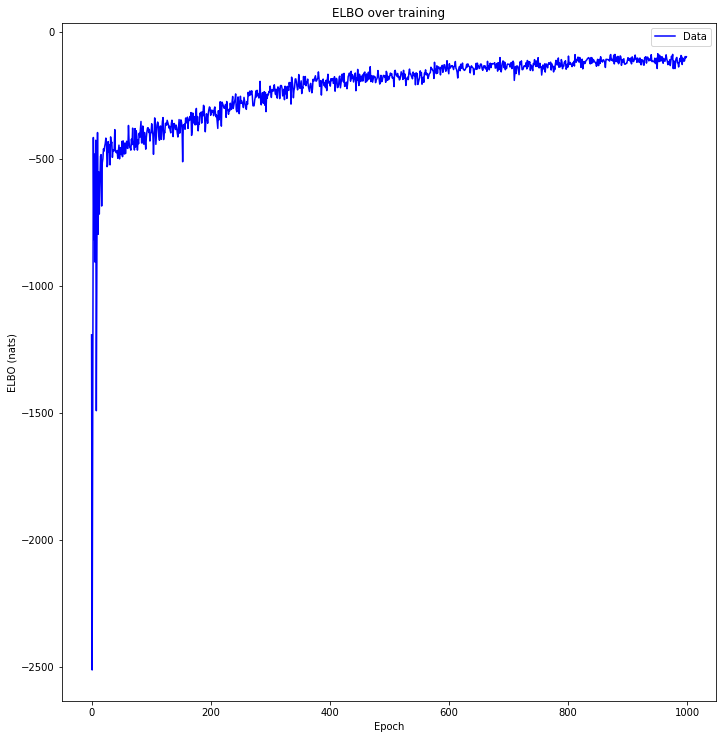

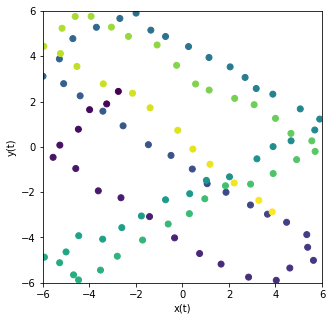

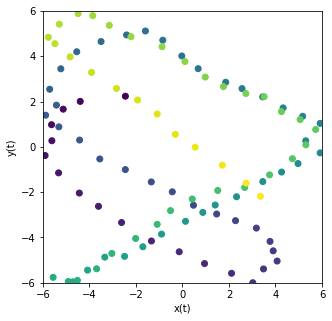

03/01/2019 14:20:21 MSE at time 0: tensor(0.1364)
03/01/2019 14:20:21 MSE at time 1: tensor(1.3073)
03/01/2019 14:20:21 MSE at time 2: tensor(1.2901)
03/01/2019 14:20:21 MSE at time 3: tensor(1.3707)
03/01/2019 14:20:21 MSE at time 4: tensor(0.1552)
03/01/2019 14:20:21 MSE at time 5: tensor(0.1248)
03/01/2019 14:20:21 MSE at time 6: tensor(0.5830)
03/01/2019 14:20:21 MSE at time 7: tensor(0.6767)
03/01/2019 14:20:21 MSE at time 8: tensor(1.0793)
03/01/2019 14:20:21 MSE at time 9: tensor(1.5153)
03/01/2019 14:20:21 MSE at time 10: tensor(1.0112)
03/01/2019 14:20:21 MSE at time 11: tensor(0.7739)
03/01/2019 14:20:21 MSE at time 12: tensor(0.5056)
03/01/2019 14:20:21 MSE at time 13: tensor(0.5660)
03/01/2019 14:20:21 MSE at time 14: tensor(1.0311)
03/01/2019 14:20:21 MSE at time 15: tensor(1.2808)
03/01/2019 14:20:21 MSE at time 16: tensor(2.4417)
03/01/2019 14:20:21 MSE at time 17: tensor(2.2238)
03/01/2019 14:20:21 MSE at time 18: tensor(2.5884)
03/01/2019 14:20:21 MSE at time 19: tenso

Epoch   460: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:21:40 ELBO=-1.52914581e+02 at epoch 463
03/01/2019 14:21:40 ELBO=-1.51507645e+02 at epoch 464
03/01/2019 14:21:40 ELBO=-1.49177689e+02 at epoch 465
03/01/2019 14:21:41 ELBO=-1.45678955e+02 at epoch 466
03/01/2019 14:21:41 ELBO=-1.24153442e+02 at epoch 467
03/01/2019 14:21:41 ELBO=-1.33394531e+02 at epoch 468
03/01/2019 14:21:41 ELBO=-1.28274078e+02 at epoch 469
03/01/2019 14:21:41 ELBO=-1.30970932e+02 at epoch 470
03/01/2019 14:21:42 ELBO=-1.30804367e+02 at epoch 471
03/01/2019 14:21:42 ELBO=-1.19664146e+02 at epoch 472
03/01/2019 14:21:42 ELBO=-1.21377106e+02 at epoch 473
03/01/2019 14:21:42 ELBO=-1.24471909e+02 at epoch 474
03/01/2019 14:21:42 ELBO=-1.26461899e+02 at epoch 475
03/01/2019 14:21:42 ELBO=-1.07502304e+02 at epoch 476
03/01/2019 14:21:43 ELBO=-1.22673889e+02 at epoch 477
03/01/2019 14:21:43 ELBO=-1.24823814e+02 at epoch 478
03/01/2019 14:21:43 ELBO=-1.13991486e+02 at epoch 479
03/01/2019 14:21:43 ELBO=-1.30006271e+02 at epoch 480
03/01/2019 14:21:43 ELBO=-1.

Epoch   655: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:22:14 ELBO=-1.22225685e+02 at epoch 658
03/01/2019 14:22:14 ELBO=-1.07966393e+02 at epoch 659
03/01/2019 14:22:14 ELBO=-1.08637283e+02 at epoch 660
03/01/2019 14:22:15 ELBO=-1.07313843e+02 at epoch 661
03/01/2019 14:22:15 ELBO=-1.06631828e+02 at epoch 662
03/01/2019 14:22:15 ELBO=-1.11554443e+02 at epoch 663
03/01/2019 14:22:15 ELBO=-1.08512436e+02 at epoch 664
03/01/2019 14:22:15 ELBO=-9.45447693e+01 at epoch 665
03/01/2019 14:22:15 ELBO=-9.95359955e+01 at epoch 666
03/01/2019 14:22:16 ELBO=-9.95134048e+01 at epoch 667
03/01/2019 14:22:16 ELBO=-1.14984459e+02 at epoch 668
03/01/2019 14:22:16 ELBO=-1.13943558e+02 at epoch 669
03/01/2019 14:22:16 ELBO=-1.08104523e+02 at epoch 670
03/01/2019 14:22:16 ELBO=-9.32195663e+01 at epoch 671
03/01/2019 14:22:16 ELBO=-1.08308022e+02 at epoch 672
03/01/2019 14:22:17 ELBO=-1.08548492e+02 at epoch 673
03/01/2019 14:22:17 ELBO=-1.02446747e+02 at epoch 674
03/01/2019 14:22:17 ELBO=-1.05337608e+02 at epoch 675
03/01/2019 14:22:17 ELBO=-1.

Epoch   756: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:22:32 ELBO=-9.46729202e+01 at epoch 759
03/01/2019 14:22:32 ELBO=-8.78302307e+01 at epoch 760
03/01/2019 14:22:32 ELBO=-9.74375916e+01 at epoch 761
03/01/2019 14:22:33 ELBO=-9.22808075e+01 at epoch 762
03/01/2019 14:22:33 ELBO=-1.00193367e+02 at epoch 763
03/01/2019 14:22:33 ELBO=-9.56340103e+01 at epoch 764
03/01/2019 14:22:33 ELBO=-1.05394188e+02 at epoch 765
03/01/2019 14:22:34 ELBO=-9.68926392e+01 at epoch 766
03/01/2019 14:22:34 ELBO=-8.56899643e+01 at epoch 767
03/01/2019 14:22:34 ELBO=-9.56121368e+01 at epoch 768
03/01/2019 14:22:34 ELBO=-1.00751503e+02 at epoch 769
03/01/2019 14:22:34 ELBO=-9.43567352e+01 at epoch 770
03/01/2019 14:22:35 ELBO=-9.56884079e+01 at epoch 771
03/01/2019 14:22:35 ELBO=-8.99184189e+01 at epoch 772
03/01/2019 14:22:35 ELBO=-8.58684082e+01 at epoch 773
03/01/2019 14:22:35 ELBO=-9.33236313e+01 at epoch 774
03/01/2019 14:22:36 ELBO=-9.49389648e+01 at epoch 775
03/01/2019 14:22:36 ELBO=-9.33308487e+01 at epoch 776
03/01/2019 14:22:36 ELBO=-9.

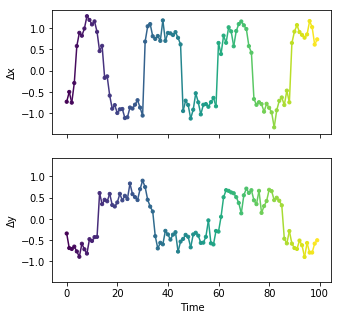

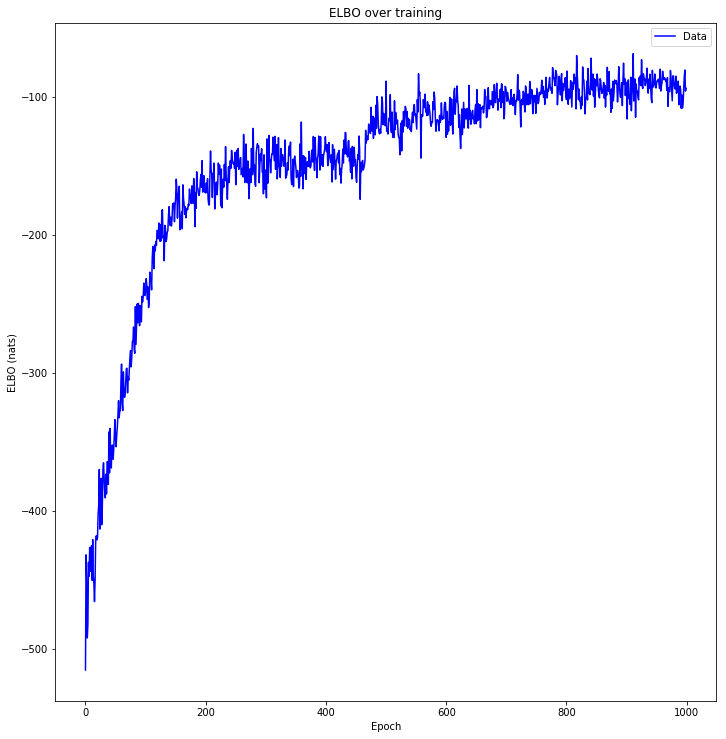

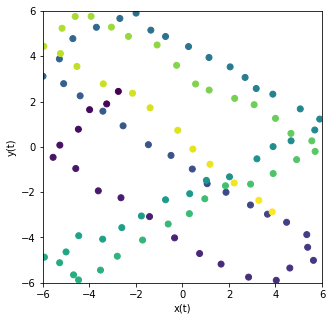

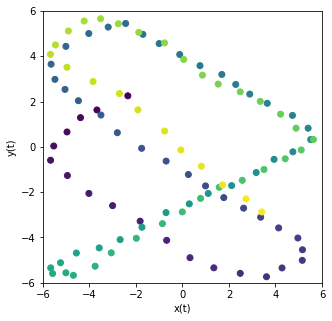

03/01/2019 14:23:25 MSE at time 0: tensor(0.2043)
03/01/2019 14:23:25 MSE at time 1: tensor(0.2474)
03/01/2019 14:23:25 MSE at time 2: tensor(0.2759)
03/01/2019 14:23:25 MSE at time 3: tensor(0.2529)
03/01/2019 14:23:25 MSE at time 4: tensor(0.0705)
03/01/2019 14:23:25 MSE at time 5: tensor(0.0282)
03/01/2019 14:23:25 MSE at time 6: tensor(0.2256)
03/01/2019 14:23:25 MSE at time 7: tensor(0.1774)
03/01/2019 14:23:25 MSE at time 8: tensor(0.2515)
03/01/2019 14:23:25 MSE at time 9: tensor(0.2042)
03/01/2019 14:23:25 MSE at time 10: tensor(0.1274)
03/01/2019 14:23:25 MSE at time 11: tensor(0.2044)
03/01/2019 14:23:25 MSE at time 12: tensor(0.1239)
03/01/2019 14:23:25 MSE at time 13: tensor(0.1566)
03/01/2019 14:23:25 MSE at time 14: tensor(0.2015)
03/01/2019 14:23:25 MSE at time 15: tensor(0.1121)
03/01/2019 14:23:25 MSE at time 16: tensor(0.2302)
03/01/2019 14:23:25 MSE at time 17: tensor(0.0618)
03/01/2019 14:23:25 MSE at time 18: tensor(0.1695)
03/01/2019 14:23:25 MSE at time 19: tenso

Epoch   405: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:24:55 ELBO=-1.45470352e+02 at epoch 408
03/01/2019 14:24:55 ELBO=-1.48192795e+02 at epoch 409
03/01/2019 14:24:55 ELBO=-1.20718033e+02 at epoch 410
03/01/2019 14:24:56 ELBO=-1.25757805e+02 at epoch 411
03/01/2019 14:24:56 ELBO=-1.23854706e+02 at epoch 412
03/01/2019 14:24:56 ELBO=-1.14685509e+02 at epoch 413
03/01/2019 14:24:56 ELBO=-1.13977852e+02 at epoch 414
03/01/2019 14:24:56 ELBO=-1.08924156e+02 at epoch 415
03/01/2019 14:24:57 ELBO=-1.12089653e+02 at epoch 416
03/01/2019 14:24:57 ELBO=-1.22314705e+02 at epoch 417
03/01/2019 14:24:57 ELBO=-1.21671951e+02 at epoch 418
03/01/2019 14:24:57 ELBO=-1.11054047e+02 at epoch 419
03/01/2019 14:24:57 ELBO=-1.14811722e+02 at epoch 420
03/01/2019 14:24:58 ELBO=-1.19542915e+02 at epoch 421
03/01/2019 14:24:58 ELBO=-1.24444160e+02 at epoch 422
03/01/2019 14:24:58 ELBO=-1.15843857e+02 at epoch 423
03/01/2019 14:24:58 ELBO=-1.23358337e+02 at epoch 424
03/01/2019 14:24:58 ELBO=-1.09869034e+02 at epoch 425
03/01/2019 14:24:59 ELBO=-1.

Epoch   605: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:25:37 ELBO=-1.04183167e+02 at epoch 608
03/01/2019 14:25:37 ELBO=-1.13486259e+02 at epoch 609
03/01/2019 14:25:37 ELBO=-1.20102333e+02 at epoch 610
03/01/2019 14:25:37 ELBO=-1.21159744e+02 at epoch 611
03/01/2019 14:25:38 ELBO=-1.11493317e+02 at epoch 612
03/01/2019 14:25:38 ELBO=-9.54351273e+01 at epoch 613
03/01/2019 14:25:38 ELBO=-1.04149887e+02 at epoch 614
03/01/2019 14:25:38 ELBO=-1.08614151e+02 at epoch 615
03/01/2019 14:25:38 ELBO=-9.86073914e+01 at epoch 616
03/01/2019 14:25:39 ELBO=-1.06539207e+02 at epoch 617
03/01/2019 14:25:39 ELBO=-9.66132812e+01 at epoch 618
03/01/2019 14:25:39 ELBO=-9.36094894e+01 at epoch 619
03/01/2019 14:25:39 ELBO=-9.74328461e+01 at epoch 620
03/01/2019 14:25:39 ELBO=-9.12640457e+01 at epoch 621
03/01/2019 14:25:40 ELBO=-1.01674576e+02 at epoch 622
03/01/2019 14:25:40 ELBO=-9.97197113e+01 at epoch 623
03/01/2019 14:25:40 ELBO=-9.83337479e+01 at epoch 624
03/01/2019 14:25:40 ELBO=-8.65125427e+01 at epoch 625
03/01/2019 14:25:41 ELBO=-9.

Epoch   934: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:26:49 ELBO=-9.58166199e+01 at epoch 937
03/01/2019 14:26:49 ELBO=-8.33982162e+01 at epoch 938
03/01/2019 14:26:49 ELBO=-9.52541962e+01 at epoch 939
03/01/2019 14:26:49 ELBO=-8.15722351e+01 at epoch 940
03/01/2019 14:26:49 ELBO=-9.00558319e+01 at epoch 941
03/01/2019 14:26:50 ELBO=-8.15237808e+01 at epoch 942
03/01/2019 14:26:50 ELBO=-8.71754761e+01 at epoch 943
03/01/2019 14:26:50 ELBO=-8.25336227e+01 at epoch 944
03/01/2019 14:26:50 ELBO=-7.86476669e+01 at epoch 945
03/01/2019 14:26:50 ELBO=-8.56166229e+01 at epoch 946
03/01/2019 14:26:51 ELBO=-8.58193512e+01 at epoch 947
03/01/2019 14:26:51 ELBO=-8.35258484e+01 at epoch 948
03/01/2019 14:26:51 ELBO=-7.22639771e+01 at epoch 949
03/01/2019 14:26:51 ELBO=-8.59045105e+01 at epoch 950
03/01/2019 14:26:51 ELBO=-9.93019867e+01 at epoch 951
03/01/2019 14:26:52 ELBO=-8.33755035e+01 at epoch 952
03/01/2019 14:26:52 ELBO=-8.12251892e+01 at epoch 953
03/01/2019 14:26:52 ELBO=-7.17595673e+01 at epoch 954
03/01/2019 14:26:52 ELBO=-7.

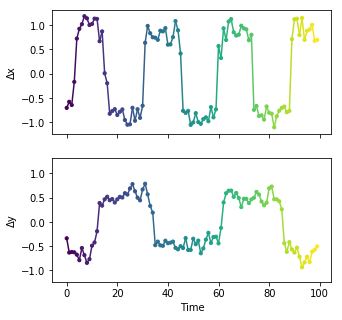

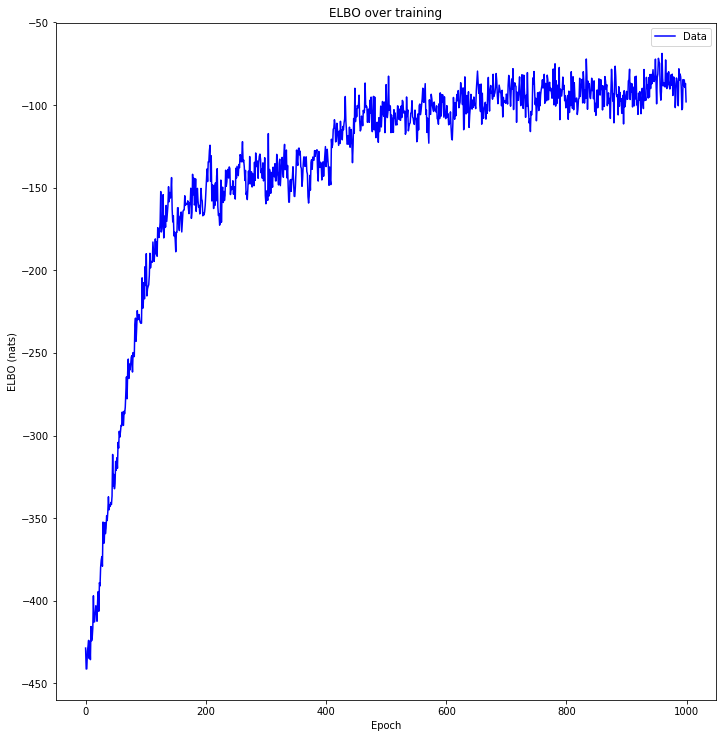

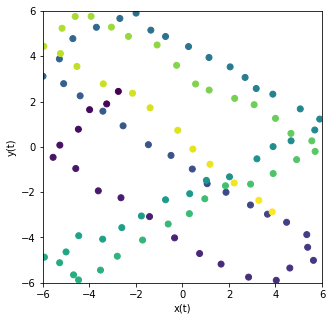

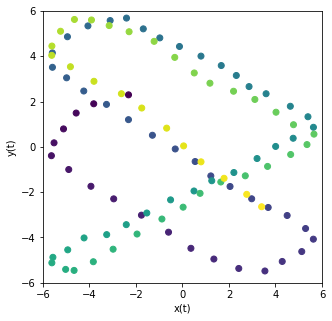

03/01/2019 14:27:02 MSE at time 0: tensor(0.2140)
03/01/2019 14:27:02 MSE at time 1: tensor(0.3108)
03/01/2019 14:27:02 MSE at time 2: tensor(0.3559)
03/01/2019 14:27:02 MSE at time 3: tensor(0.4083)
03/01/2019 14:27:02 MSE at time 4: tensor(0.0725)
03/01/2019 14:27:02 MSE at time 5: tensor(0.0103)
03/01/2019 14:27:02 MSE at time 6: tensor(0.0935)
03/01/2019 14:27:02 MSE at time 7: tensor(0.1406)
03/01/2019 14:27:02 MSE at time 8: tensor(0.1003)
03/01/2019 14:27:02 MSE at time 9: tensor(0.1251)
03/01/2019 14:27:02 MSE at time 10: tensor(0.1304)
03/01/2019 14:27:02 MSE at time 11: tensor(0.1925)
03/01/2019 14:27:02 MSE at time 12: tensor(0.1456)
03/01/2019 14:27:02 MSE at time 13: tensor(0.3245)
03/01/2019 14:27:02 MSE at time 14: tensor(0.4081)
03/01/2019 14:27:02 MSE at time 15: tensor(0.1903)
03/01/2019 14:27:02 MSE at time 16: tensor(0.4027)
03/01/2019 14:27:02 MSE at time 17: tensor(0.1884)
03/01/2019 14:27:02 MSE at time 18: tensor(0.0750)
03/01/2019 14:27:02 MSE at time 19: tenso

Epoch   228: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:27:44 EUBO=0.00000000e+00 at epoch 231
03/01/2019 14:27:45 EUBO=0.00000000e+00 at epoch 232
03/01/2019 14:27:45 EUBO=-6.80883027e-27 at epoch 233
03/01/2019 14:27:45 EUBO=0.00000000e+00 at epoch 234
03/01/2019 14:27:45 EUBO=0.00000000e+00 at epoch 235
03/01/2019 14:27:45 EUBO=-2.34166973e-17 at epoch 236
03/01/2019 14:27:46 EUBO=-1.02638953e-15 at epoch 237
03/01/2019 14:27:46 EUBO=0.00000000e+00 at epoch 238
03/01/2019 14:27:46 EUBO=-6.27772579e-07 at epoch 239
03/01/2019 14:27:46 EUBO=0.00000000e+00 at epoch 240
03/01/2019 14:27:46 EUBO=-8.74430668e-14 at epoch 241
03/01/2019 14:27:46 EUBO=0.00000000e+00 at epoch 242
03/01/2019 14:27:46 EUBO=0.00000000e+00 at epoch 243
03/01/2019 14:27:47 EUBO=0.00000000e+00 at epoch 244
03/01/2019 14:27:47 EUBO=-3.00335250e-23 at epoch 245
03/01/2019 14:27:47 EUBO=0.00000000e+00 at epoch 246
03/01/2019 14:27:47 EUBO=0.00000000e+00 at epoch 247
03/01/2019 14:27:48 EUBO=0.00000000e+00 at epoch 248
03/01/2019 14:27:48 EUBO=-4.70743572e-07

Epoch   329: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:28:02 EUBO=-4.23548041e-32 at epoch 332
03/01/2019 14:28:02 EUBO=0.00000000e+00 at epoch 333
03/01/2019 14:28:02 EUBO=0.00000000e+00 at epoch 334
03/01/2019 14:28:02 EUBO=-1.59525361e-23 at epoch 335
03/01/2019 14:28:02 EUBO=-3.69079007e-20 at epoch 336
03/01/2019 14:28:02 EUBO=-1.20657666e-14 at epoch 337
03/01/2019 14:28:03 EUBO=0.00000000e+00 at epoch 338
03/01/2019 14:28:03 EUBO=0.00000000e+00 at epoch 339
03/01/2019 14:28:03 EUBO=0.00000000e+00 at epoch 340
03/01/2019 14:28:03 EUBO=-5.07317624e-21 at epoch 341
03/01/2019 14:28:03 EUBO=-1.43687876e-21 at epoch 342
03/01/2019 14:28:03 EUBO=0.00000000e+00 at epoch 343
03/01/2019 14:28:03 EUBO=0.00000000e+00 at epoch 344
03/01/2019 14:28:04 EUBO=0.00000000e+00 at epoch 345
03/01/2019 14:28:04 EUBO=-2.35047623e-17 at epoch 346
03/01/2019 14:28:04 EUBO=-1.68188746e-13 at epoch 347
03/01/2019 14:28:04 EUBO=0.00000000e+00 at epoch 348
03/01/2019 14:28:04 EUBO=0.00000000e+00 at epoch 349
03/01/2019 14:28:05 EUBO=-3.03241628e-

Epoch   430: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:28:18 EUBO=0.00000000e+00 at epoch 433
03/01/2019 14:28:18 EUBO=-3.69126398e-39 at epoch 434
03/01/2019 14:28:18 EUBO=0.00000000e+00 at epoch 435
03/01/2019 14:28:19 EUBO=-2.55261821e-08 at epoch 436
03/01/2019 14:28:19 EUBO=-8.37980749e-24 at epoch 437
03/01/2019 14:28:19 EUBO=-4.23862894e-36 at epoch 438
03/01/2019 14:28:19 EUBO=0.00000000e+00 at epoch 439
03/01/2019 14:28:19 EUBO=0.00000000e+00 at epoch 440
03/01/2019 14:28:19 EUBO=0.00000000e+00 at epoch 441
03/01/2019 14:28:20 EUBO=0.00000000e+00 at epoch 442
03/01/2019 14:28:20 EUBO=0.00000000e+00 at epoch 443
03/01/2019 14:28:20 EUBO=0.00000000e+00 at epoch 444
03/01/2019 14:28:20 EUBO=0.00000000e+00 at epoch 445
03/01/2019 14:28:20 EUBO=0.00000000e+00 at epoch 446
03/01/2019 14:28:20 EUBO=-1.25423766e-34 at epoch 447
03/01/2019 14:28:21 EUBO=-7.09366767e-18 at epoch 448
03/01/2019 14:28:21 EUBO=-4.39190312e-34 at epoch 449
03/01/2019 14:28:21 EUBO=0.00000000e+00 at epoch 450
03/01/2019 14:28:21 EUBO=0.00000000e+00

Epoch   531: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:28:35 EUBO=-1.86087575e-20 at epoch 534
03/01/2019 14:28:35 EUBO=-2.88667484e-43 at epoch 535
03/01/2019 14:28:36 EUBO=-2.40609960e-23 at epoch 536
03/01/2019 14:28:36 EUBO=0.00000000e+00 at epoch 537
03/01/2019 14:28:36 EUBO=-5.28516228e-20 at epoch 538
03/01/2019 14:28:36 EUBO=0.00000000e+00 at epoch 539
03/01/2019 14:28:36 EUBO=-3.58580543e-28 at epoch 540
03/01/2019 14:28:36 EUBO=-2.76301408e-19 at epoch 541
03/01/2019 14:28:36 EUBO=-1.58606602e-28 at epoch 542
03/01/2019 14:28:37 EUBO=-2.93091094e-20 at epoch 543
03/01/2019 14:28:37 EUBO=0.00000000e+00 at epoch 544
03/01/2019 14:28:37 EUBO=0.00000000e+00 at epoch 545
03/01/2019 14:28:37 EUBO=-6.71533817e-21 at epoch 546
03/01/2019 14:28:37 EUBO=-2.81225934e-34 at epoch 547
03/01/2019 14:28:37 EUBO=0.00000000e+00 at epoch 548
03/01/2019 14:28:38 EUBO=0.00000000e+00 at epoch 549
03/01/2019 14:28:38 EUBO=-8.10352101e-15 at epoch 550
03/01/2019 14:28:38 EUBO=-2.40411980e-18 at epoch 551
03/01/2019 14:28:38 EUBO=-2.644463

Epoch   632: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:28:51 EUBO=-7.11859620e-43 at epoch 635
03/01/2019 14:28:51 EUBO=-2.90622537e-21 at epoch 636
03/01/2019 14:28:51 EUBO=-2.08922484e-12 at epoch 637
03/01/2019 14:28:51 EUBO=-6.94481042e-19 at epoch 638
03/01/2019 14:28:51 EUBO=0.00000000e+00 at epoch 639
03/01/2019 14:28:52 EUBO=-7.51230003e-21 at epoch 640
03/01/2019 14:28:52 EUBO=-1.70558228e-22 at epoch 641
03/01/2019 14:28:52 EUBO=-1.53156334e-25 at epoch 642
03/01/2019 14:28:52 EUBO=-4.28196367e-09 at epoch 643
03/01/2019 14:28:52 EUBO=-2.66004276e-23 at epoch 644
03/01/2019 14:28:52 EUBO=-7.00444898e-36 at epoch 645
03/01/2019 14:28:53 EUBO=0.00000000e+00 at epoch 646
03/01/2019 14:28:53 EUBO=-2.87266185e-43 at epoch 647
03/01/2019 14:28:53 EUBO=0.00000000e+00 at epoch 648
03/01/2019 14:28:53 EUBO=0.00000000e+00 at epoch 649
03/01/2019 14:28:53 EUBO=0.00000000e+00 at epoch 650
03/01/2019 14:28:53 EUBO=0.00000000e+00 at epoch 651
03/01/2019 14:28:53 EUBO=0.00000000e+00 at epoch 652
03/01/2019 14:28:54 EUBO=-1.0093157

Epoch   733: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:29:07 EUBO=-4.36474767e-25 at epoch 736
03/01/2019 14:29:07 EUBO=-3.23431174e-20 at epoch 737
03/01/2019 14:29:07 EUBO=0.00000000e+00 at epoch 738
03/01/2019 14:29:07 EUBO=-7.09781105e-16 at epoch 739
03/01/2019 14:29:08 EUBO=-3.52586189e-26 at epoch 740
03/01/2019 14:29:08 EUBO=-1.69416984e-42 at epoch 741
03/01/2019 14:29:08 EUBO=-2.54791552e-28 at epoch 742
03/01/2019 14:29:08 EUBO=-8.47645441e-42 at epoch 743
03/01/2019 14:29:08 EUBO=-4.63677076e-30 at epoch 744
03/01/2019 14:29:08 EUBO=0.00000000e+00 at epoch 745
03/01/2019 14:29:09 EUBO=-7.39920162e-37 at epoch 746
03/01/2019 14:29:09 EUBO=-6.58384879e-17 at epoch 747
03/01/2019 14:29:09 EUBO=0.00000000e+00 at epoch 748
03/01/2019 14:29:09 EUBO=-6.74507060e-23 at epoch 749
03/01/2019 14:29:09 EUBO=-2.14034132e-28 at epoch 750
03/01/2019 14:29:09 EUBO=0.00000000e+00 at epoch 751
03/01/2019 14:29:10 EUBO=-2.96531476e-22 at epoch 752
03/01/2019 14:29:10 EUBO=-5.39919426e-22 at epoch 753
03/01/2019 14:29:10 EUBO=-1.3971

Epoch   834: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 14:29:23 EUBO=0.00000000e+00 at epoch 837
03/01/2019 14:29:24 EUBO=0.00000000e+00 at epoch 838
03/01/2019 14:29:24 EUBO=-2.88012885e-33 at epoch 839
03/01/2019 14:29:24 EUBO=-1.29644645e-38 at epoch 840
03/01/2019 14:29:24 EUBO=0.00000000e+00 at epoch 841
03/01/2019 14:29:24 EUBO=-5.17784761e-29 at epoch 842
03/01/2019 14:29:24 EUBO=0.00000000e+00 at epoch 843
03/01/2019 14:29:24 EUBO=0.00000000e+00 at epoch 844
03/01/2019 14:29:25 EUBO=-1.18875350e-17 at epoch 845
03/01/2019 14:29:25 EUBO=-3.74481600e-40 at epoch 846
03/01/2019 14:29:25 EUBO=-4.54833456e-41 at epoch 847
03/01/2019 14:29:25 EUBO=0.00000000e+00 at epoch 848
03/01/2019 14:29:25 EUBO=-7.00975065e-21 at epoch 849
03/01/2019 14:29:25 EUBO=-2.48863186e-13 at epoch 850
03/01/2019 14:29:25 EUBO=0.00000000e+00 at epoch 851
03/01/2019 14:29:26 EUBO=0.00000000e+00 at epoch 852
03/01/2019 14:29:26 EUBO=-1.76276415e-19 at epoch 853
03/01/2019 14:29:26 EUBO=-6.94621452e-37 at epoch 854
03/01/2019 14:29:26 EUBO=0.00000000e

Epoch   985: reducing learning rate of group 0 to 3.9063e-04.


03/01/2019 14:29:46 EUBO=0.00000000e+00 at epoch 988
03/01/2019 14:29:46 EUBO=-1.92430079e-21 at epoch 989
03/01/2019 14:29:46 EUBO=0.00000000e+00 at epoch 990
03/01/2019 14:29:46 EUBO=0.00000000e+00 at epoch 991
03/01/2019 14:29:46 EUBO=0.00000000e+00 at epoch 992
03/01/2019 14:29:46 EUBO=-1.15172348e-18 at epoch 993
03/01/2019 14:29:47 EUBO=-3.04443663e-21 at epoch 994
03/01/2019 14:29:47 EUBO=-1.51781476e-32 at epoch 995
03/01/2019 14:29:47 EUBO=-8.53390765e-43 at epoch 996
03/01/2019 14:29:47 EUBO=-1.13054249e-12 at epoch 997
03/01/2019 14:29:47 EUBO=-6.29582945e-15 at epoch 998
03/01/2019 14:29:47 EUBO=0.00000000e+00 at epoch 999
03/01/2019 14:29:48 EUBO=0.00000000e+00 at epoch 1000


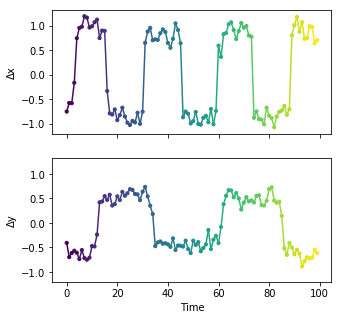

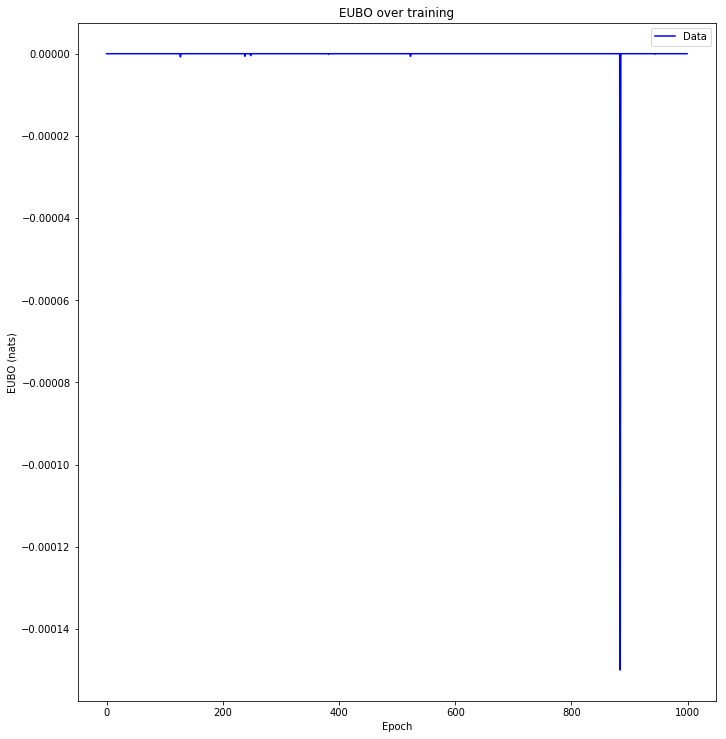

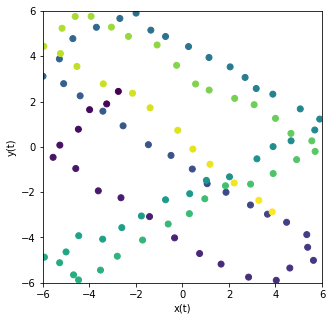

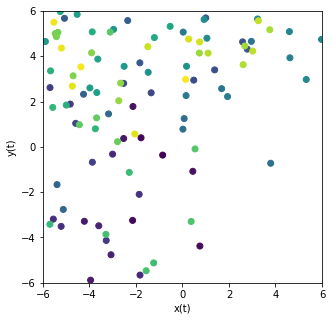

03/01/2019 14:29:49 MSE at time 0: tensor(11.5460)
03/01/2019 14:29:49 MSE at time 1: tensor(4.4193)
03/01/2019 14:29:49 MSE at time 2: tensor(27.3223)
03/01/2019 14:29:49 MSE at time 3: tensor(53.9129)
03/01/2019 14:29:49 MSE at time 4: tensor(34.0520)
03/01/2019 14:29:49 MSE at time 5: tensor(16.8301)
03/01/2019 14:29:49 MSE at time 6: tensor(5.9971)
03/01/2019 14:29:49 MSE at time 7: tensor(2.1695)
03/01/2019 14:29:49 MSE at time 8: tensor(14.9483)
03/01/2019 14:29:49 MSE at time 9: tensor(5.5862)
03/01/2019 14:29:49 MSE at time 10: tensor(10.9205)
03/01/2019 14:29:49 MSE at time 11: tensor(33.2557)
03/01/2019 14:29:49 MSE at time 12: tensor(12.3961)
03/01/2019 14:29:49 MSE at time 13: tensor(77.0837)
03/01/2019 14:29:49 MSE at time 14: tensor(91.2855)
03/01/2019 14:29:49 MSE at time 15: tensor(52.5544)
03/01/2019 14:29:49 MSE at time 16: tensor(156.9943)
03/01/2019 14:29:49 MSE at time 17: tensor(75.1467)
03/01/2019 14:29:49 MSE at time 18: tensor(164.0885)
03/01/2019 14:29:49 MSE 

Epoch   101: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:30:04 EUBO=-2.95275211e-01 at epoch 104
03/01/2019 14:30:04 EUBO=-1.05728865e-01 at epoch 105
03/01/2019 14:30:04 EUBO=-2.75154829e-01 at epoch 106
03/01/2019 14:30:04 EUBO=-1.05360508e-01 at epoch 107
03/01/2019 14:30:05 EUBO=-1.22337580e-01 at epoch 108
03/01/2019 14:30:05 EUBO=-1.47116423e-01 at epoch 109
03/01/2019 14:30:05 EUBO=-1.05361462e-01 at epoch 110
03/01/2019 14:30:05 EUBO=-1.05364323e-01 at epoch 111
03/01/2019 14:30:05 EUBO=-1.05361462e-01 at epoch 112
03/01/2019 14:30:05 EUBO=-1.05360746e-01 at epoch 113
03/01/2019 14:30:05 EUBO=-1.72010183e-01 at epoch 114
03/01/2019 14:30:06 EUBO=-1.05360508e-01 at epoch 115
03/01/2019 14:30:06 EUBO=-1.05360508e-01 at epoch 116
03/01/2019 14:30:06 EUBO=-1.05395794e-01 at epoch 117
03/01/2019 14:30:06 EUBO=-1.05360508e-01 at epoch 118
03/01/2019 14:30:06 EUBO=-1.05366230e-01 at epoch 119
03/01/2019 14:30:06 EUBO=-1.05411530e-01 at epoch 120
03/01/2019 14:30:06 EUBO=-1.05615854e-01 at epoch 121
03/01/2019 14:30:07 EUBO=-1.

Epoch   266: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:30:28 EUBO=-1.05360508e-01 at epoch 269
03/01/2019 14:30:28 EUBO=-2.23148108e-01 at epoch 270
03/01/2019 14:30:29 EUBO=-1.05364084e-01 at epoch 271
03/01/2019 14:30:29 EUBO=-1.08013630e-01 at epoch 272
03/01/2019 14:30:29 EUBO=-1.05674744e-01 at epoch 273
03/01/2019 14:30:29 EUBO=-1.09926224e-01 at epoch 274
03/01/2019 14:30:29 EUBO=-1.11404419e-01 at epoch 275
03/01/2019 14:30:29 EUBO=-1.05372190e-01 at epoch 276
03/01/2019 14:30:29 EUBO=-1.09760761e-01 at epoch 277
03/01/2019 14:30:30 EUBO=-1.05360746e-01 at epoch 278
03/01/2019 14:30:30 EUBO=-1.05360508e-01 at epoch 279
03/01/2019 14:30:30 EUBO=-1.05361700e-01 at epoch 280
03/01/2019 14:30:30 EUBO=-1.05360508e-01 at epoch 281
03/01/2019 14:30:30 EUBO=-1.05360746e-01 at epoch 282
03/01/2019 14:30:30 EUBO=-1.07060671e-01 at epoch 283
03/01/2019 14:30:30 EUBO=-1.07815981e-01 at epoch 284
03/01/2019 14:30:31 EUBO=-1.05360508e-01 at epoch 285
03/01/2019 14:30:31 EUBO=-2.22728729e-01 at epoch 286
03/01/2019 14:30:31 EUBO=-1.

Epoch   367: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:30:43 EUBO=-1.05361462e-01 at epoch 370
03/01/2019 14:30:43 EUBO=-1.05360508e-01 at epoch 371
03/01/2019 14:30:44 EUBO=-2.84790754e-01 at epoch 372
03/01/2019 14:30:44 EUBO=-1.05360508e-01 at epoch 373
03/01/2019 14:30:44 EUBO=-1.05360508e-01 at epoch 374
03/01/2019 14:30:44 EUBO=-1.58143044e-01 at epoch 375
03/01/2019 14:30:44 EUBO=-1.05365753e-01 at epoch 376
03/01/2019 14:30:44 EUBO=-1.06400490e-01 at epoch 377
03/01/2019 14:30:44 EUBO=-1.05390787e-01 at epoch 378
03/01/2019 14:30:45 EUBO=-1.05360508e-01 at epoch 379
03/01/2019 14:30:45 EUBO=-1.07038498e-01 at epoch 380
03/01/2019 14:30:45 EUBO=-1.05360985e-01 at epoch 381
03/01/2019 14:30:45 EUBO=-1.05362415e-01 at epoch 382
03/01/2019 14:30:45 EUBO=-1.96445942e-01 at epoch 383
03/01/2019 14:30:45 EUBO=-1.14483833e-01 at epoch 384
03/01/2019 14:30:45 EUBO=-1.05938911e-01 at epoch 385
03/01/2019 14:30:46 EUBO=-1.05360508e-01 at epoch 386
03/01/2019 14:30:46 EUBO=-1.05360508e-01 at epoch 387
03/01/2019 14:30:46 EUBO=-1.

Epoch   468: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:30:58 EUBO=-1.05361700e-01 at epoch 471
03/01/2019 14:30:59 EUBO=-1.05367422e-01 at epoch 472
03/01/2019 14:30:59 EUBO=-1.95351839e-01 at epoch 473
03/01/2019 14:30:59 EUBO=-1.05367661e-01 at epoch 474
03/01/2019 14:30:59 EUBO=-2.12111473e-01 at epoch 475
03/01/2019 14:30:59 EUBO=-1.23524904e-01 at epoch 476
03/01/2019 14:30:59 EUBO=-1.06040955e-01 at epoch 477
03/01/2019 14:31:00 EUBO=-3.56439352e-01 at epoch 478
03/01/2019 14:31:00 EUBO=-2.27811337e-01 at epoch 479
03/01/2019 14:31:00 EUBO=-1.05360508e-01 at epoch 480
03/01/2019 14:31:00 EUBO=-1.05368376e-01 at epoch 481
03/01/2019 14:31:00 EUBO=-2.14751959e-01 at epoch 482
03/01/2019 14:31:00 EUBO=-1.06035709e-01 at epoch 483
03/01/2019 14:31:00 EUBO=-1.05360508e-01 at epoch 484
03/01/2019 14:31:01 EUBO=-1.94487572e-01 at epoch 485
03/01/2019 14:31:01 EUBO=-2.04473257e-01 at epoch 486
03/01/2019 14:31:01 EUBO=-1.05360508e-01 at epoch 487
03/01/2019 14:31:01 EUBO=-2.18690157e-01 at epoch 488
03/01/2019 14:31:01 EUBO=-1.

Epoch   569: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:31:14 EUBO=-1.07494593e-01 at epoch 572
03/01/2019 14:31:14 EUBO=-1.12793922e-01 at epoch 573
03/01/2019 14:31:14 EUBO=-1.05360508e-01 at epoch 574
03/01/2019 14:31:14 EUBO=-1.08308077e-01 at epoch 575
03/01/2019 14:31:15 EUBO=-1.05370760e-01 at epoch 576
03/01/2019 14:31:15 EUBO=-1.06204271e-01 at epoch 577
03/01/2019 14:31:15 EUBO=-1.08918667e-01 at epoch 578
03/01/2019 14:31:15 EUBO=-1.06213093e-01 at epoch 579
03/01/2019 14:31:15 EUBO=-1.05361938e-01 at epoch 580
03/01/2019 14:31:15 EUBO=-1.53512478e-01 at epoch 581
03/01/2019 14:31:16 EUBO=-1.08707666e-01 at epoch 582
03/01/2019 14:31:16 EUBO=-1.05440140e-01 at epoch 583
03/01/2019 14:31:16 EUBO=-2.23143101e-01 at epoch 584
03/01/2019 14:31:16 EUBO=-1.05360508e-01 at epoch 585
03/01/2019 14:31:16 EUBO=-1.05362892e-01 at epoch 586
03/01/2019 14:31:16 EUBO=-2.23110914e-01 at epoch 587
03/01/2019 14:31:16 EUBO=-1.08675480e-01 at epoch 588
03/01/2019 14:31:17 EUBO=-1.05364084e-01 at epoch 589
03/01/2019 14:31:17 EUBO=-2.

Epoch   743: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:31:41 EUBO=-1.05360508e-01 at epoch 746
03/01/2019 14:31:41 EUBO=-1.05360746e-01 at epoch 747
03/01/2019 14:31:41 EUBO=-1.05361462e-01 at epoch 748
03/01/2019 14:31:41 EUBO=-1.05824232e-01 at epoch 749
03/01/2019 14:31:41 EUBO=-2.23324299e-01 at epoch 750
03/01/2019 14:31:41 EUBO=-1.06660843e-01 at epoch 751
03/01/2019 14:31:42 EUBO=-2.24043608e-01 at epoch 752
03/01/2019 14:31:42 EUBO=-2.23144054e-01 at epoch 753
03/01/2019 14:31:42 EUBO=-2.23119497e-01 at epoch 754
03/01/2019 14:31:42 EUBO=-1.05482817e-01 at epoch 755
03/01/2019 14:31:42 EUBO=-1.05366945e-01 at epoch 756
03/01/2019 14:31:42 EUBO=-1.05397701e-01 at epoch 757
03/01/2019 14:31:42 EUBO=-1.05360508e-01 at epoch 758
03/01/2019 14:31:43 EUBO=-1.05542183e-01 at epoch 759
03/01/2019 14:31:43 EUBO=-1.83452368e-01 at epoch 760
03/01/2019 14:31:43 EUBO=-1.10385180e-01 at epoch 761
03/01/2019 14:31:43 EUBO=-2.16380596e-01 at epoch 762
03/01/2019 14:31:43 EUBO=-1.05360508e-01 at epoch 763
03/01/2019 14:31:43 EUBO=-2.

Epoch   844: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 14:31:56 EUBO=-1.05367661e-01 at epoch 847
03/01/2019 14:31:56 EUBO=-1.05374098e-01 at epoch 848
03/01/2019 14:31:56 EUBO=-1.05363607e-01 at epoch 849
03/01/2019 14:31:56 EUBO=-1.05360508e-01 at epoch 850
03/01/2019 14:31:57 EUBO=-1.05393410e-01 at epoch 851
03/01/2019 14:31:57 EUBO=-1.96817160e-01 at epoch 852
03/01/2019 14:31:57 EUBO=-1.05363131e-01 at epoch 853
03/01/2019 14:31:57 EUBO=-2.79493093e-01 at epoch 854
03/01/2019 14:31:57 EUBO=-1.05501175e-01 at epoch 855
03/01/2019 14:31:57 EUBO=-1.05361700e-01 at epoch 856
03/01/2019 14:31:58 EUBO=-1.05681658e-01 at epoch 857
03/01/2019 14:31:58 EUBO=-1.05360508e-01 at epoch 858
03/01/2019 14:31:58 EUBO=-1.05360508e-01 at epoch 859
03/01/2019 14:31:58 EUBO=-1.05357647e-01 at epoch 860
03/01/2019 14:31:58 EUBO=-1.05360746e-01 at epoch 861
03/01/2019 14:31:58 EUBO=-1.76147938e-01 at epoch 862
03/01/2019 14:31:59 EUBO=-1.05412483e-01 at epoch 863
03/01/2019 14:31:59 EUBO=-1.29835844e-01 at epoch 864
03/01/2019 14:31:59 EUBO=-1.

Epoch   945: reducing learning rate of group 0 to 3.9063e-04.


03/01/2019 14:32:12 EUBO=-1.05360508e-01 at epoch 947
03/01/2019 14:32:12 EUBO=-1.05362892e-01 at epoch 948
03/01/2019 14:32:12 EUBO=-1.05360508e-01 at epoch 949
03/01/2019 14:32:12 EUBO=-2.20698357e-01 at epoch 950
03/01/2019 14:32:12 EUBO=-1.05360746e-01 at epoch 951
03/01/2019 14:32:13 EUBO=-2.08230257e-01 at epoch 952
03/01/2019 14:32:13 EUBO=-1.05360508e-01 at epoch 953
03/01/2019 14:32:13 EUBO=-2.36038685e-01 at epoch 954
03/01/2019 14:32:13 EUBO=-2.21371889e-01 at epoch 955
03/01/2019 14:32:13 EUBO=-1.05415106e-01 at epoch 956
03/01/2019 14:32:13 EUBO=-2.03230143e-01 at epoch 957
03/01/2019 14:32:14 EUBO=-1.05417490e-01 at epoch 958
03/01/2019 14:32:14 EUBO=-1.05456114e-01 at epoch 959
03/01/2019 14:32:14 EUBO=-2.20005512e-01 at epoch 960
03/01/2019 14:32:14 EUBO=-2.18093395e-01 at epoch 961
03/01/2019 14:32:14 EUBO=-2.00636625e-01 at epoch 962
03/01/2019 14:32:14 EUBO=-1.05883121e-01 at epoch 963
03/01/2019 14:32:15 EUBO=-1.05360508e-01 at epoch 964
03/01/2019 14:32:15 EUBO=-1.

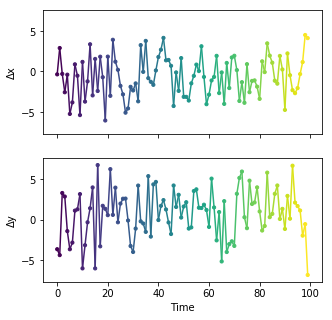

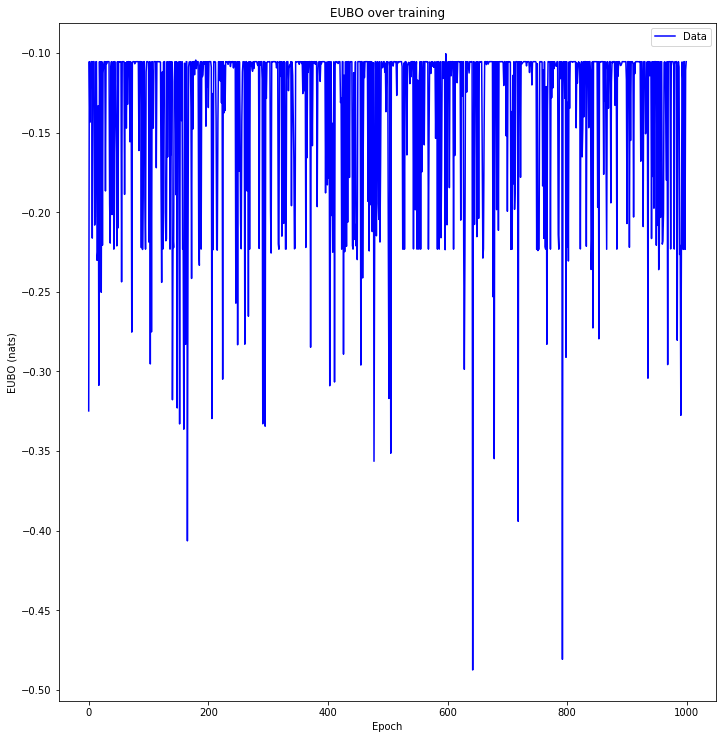

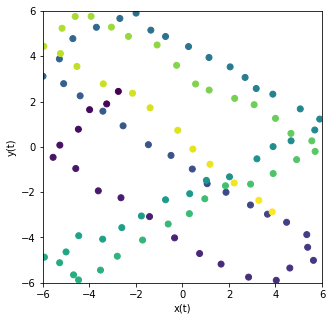

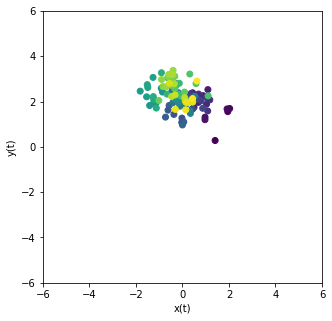

03/01/2019 14:32:21 MSE at time 0: tensor(22.0214)
03/01/2019 14:32:21 MSE at time 1: tensor(27.2441)
03/01/2019 14:32:21 MSE at time 2: tensor(36.2926)
03/01/2019 14:32:21 MSE at time 3: tensor(41.7031)
03/01/2019 14:32:21 MSE at time 4: tensor(40.5207)
03/01/2019 14:32:21 MSE at time 5: tensor(45.4421)
03/01/2019 14:32:21 MSE at time 6: tensor(32.0343)
03/01/2019 14:32:21 MSE at time 7: tensor(35.1733)
03/01/2019 14:32:21 MSE at time 8: tensor(36.7616)
03/01/2019 14:32:21 MSE at time 9: tensor(29.8291)
03/01/2019 14:32:21 MSE at time 10: tensor(33.9233)
03/01/2019 14:32:21 MSE at time 11: tensor(48.6227)
03/01/2019 14:32:21 MSE at time 12: tensor(50.2563)
03/01/2019 14:32:21 MSE at time 13: tensor(69.9658)
03/01/2019 14:32:21 MSE at time 14: tensor(71.6334)
03/01/2019 14:32:21 MSE at time 15: tensor(60.5482)
03/01/2019 14:32:21 MSE at time 16: tensor(72.8959)
03/01/2019 14:32:21 MSE at time 17: tensor(71.2538)
03/01/2019 14:32:21 MSE at time 18: tensor(55.6688)
03/01/2019 14:32:21 MS

Epoch   252: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:33:05 EUBO=-1.04441643e-02 at epoch 255
03/01/2019 14:33:05 EUBO=-1.03888512e-02 at epoch 256
03/01/2019 14:33:06 EUBO=-2.64329910e-02 at epoch 257
03/01/2019 14:33:06 EUBO=-1.98035240e-02 at epoch 258
03/01/2019 14:33:06 EUBO=-2.01864243e-02 at epoch 259
03/01/2019 14:33:06 EUBO=-3.17468643e-02 at epoch 260
03/01/2019 14:33:06 EUBO=-1.36728287e-02 at epoch 261
03/01/2019 14:33:06 EUBO=-1.00536346e-02 at epoch 262
03/01/2019 14:33:06 EUBO=-1.02562904e-02 at epoch 263
03/01/2019 14:33:07 EUBO=-1.01175308e-02 at epoch 264
03/01/2019 14:33:07 EUBO=-1.30152702e-02 at epoch 265
03/01/2019 14:33:07 EUBO=-2.17161179e-02 at epoch 266
03/01/2019 14:33:07 EUBO=-1.00674629e-02 at epoch 267
03/01/2019 14:33:07 EUBO=-3.07288170e-02 at epoch 268
03/01/2019 14:33:07 EUBO=-4.75234985e-02 at epoch 269
03/01/2019 14:33:08 EUBO=-1.00526810e-02 at epoch 270
03/01/2019 14:33:08 EUBO=-2.31013298e-02 at epoch 271
03/01/2019 14:33:08 EUBO=-1.32226944e-02 at epoch 272
03/01/2019 14:33:08 EUBO=-2.

Epoch   353: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:33:21 EUBO=-1.03402138e-02 at epoch 356
03/01/2019 14:33:22 EUBO=-2.80151367e-02 at epoch 357
03/01/2019 14:33:22 EUBO=-1.00502968e-02 at epoch 358
03/01/2019 14:33:22 EUBO=-1.08089447e-02 at epoch 359
03/01/2019 14:33:22 EUBO=-1.04866028e-02 at epoch 360
03/01/2019 14:33:22 EUBO=-3.34887505e-02 at epoch 361
03/01/2019 14:33:22 EUBO=-4.16822433e-02 at epoch 362
03/01/2019 14:33:23 EUBO=-1.06821060e-02 at epoch 363
03/01/2019 14:33:23 EUBO=-1.00517273e-02 at epoch 364
03/01/2019 14:33:23 EUBO=-1.01919174e-02 at epoch 365
03/01/2019 14:33:23 EUBO=-2.13370323e-02 at epoch 366
03/01/2019 14:33:23 EUBO=-2.99482346e-02 at epoch 367
03/01/2019 14:33:23 EUBO=-1.01041794e-02 at epoch 368
03/01/2019 14:33:23 EUBO=-1.14469528e-02 at epoch 369
03/01/2019 14:33:24 EUBO=-1.42841339e-02 at epoch 370
03/01/2019 14:33:24 EUBO=-4.02317047e-02 at epoch 371
03/01/2019 14:33:24 EUBO=-1.01933479e-02 at epoch 372
03/01/2019 14:33:24 EUBO=-1.04408264e-02 at epoch 373
03/01/2019 14:33:24 EUBO=-1.

Epoch   454: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:33:39 EUBO=-3.81569862e-02 at epoch 457
03/01/2019 14:33:39 EUBO=-1.68876648e-02 at epoch 458
03/01/2019 14:33:39 EUBO=-1.03507042e-02 at epoch 459
03/01/2019 14:33:39 EUBO=-2.50062943e-02 at epoch 460
03/01/2019 14:33:39 EUBO=-1.33290291e-02 at epoch 461
03/01/2019 14:33:39 EUBO=-1.00874901e-02 at epoch 462
03/01/2019 14:33:40 EUBO=-2.03037262e-02 at epoch 463
03/01/2019 14:33:40 EUBO=-2.21891403e-02 at epoch 464
03/01/2019 14:33:40 EUBO=-2.08306313e-02 at epoch 465
03/01/2019 14:33:40 EUBO=-3.53908539e-02 at epoch 466
03/01/2019 14:33:40 EUBO=-1.93948746e-02 at epoch 467
03/01/2019 14:33:40 EUBO=-2.16956139e-02 at epoch 468
03/01/2019 14:33:41 EUBO=-1.00479126e-02 at epoch 469
03/01/2019 14:33:41 EUBO=-2.39863396e-02 at epoch 470
03/01/2019 14:33:41 EUBO=-1.00517273e-02 at epoch 471
03/01/2019 14:33:41 EUBO=-2.07471848e-02 at epoch 472
03/01/2019 14:33:41 EUBO=-3.22642326e-02 at epoch 473
03/01/2019 14:33:42 EUBO=-1.00679398e-02 at epoch 474
03/01/2019 14:33:42 EUBO=-1.

Epoch   613: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:34:07 EUBO=-3.77707481e-02 at epoch 616
03/01/2019 14:34:07 EUBO=-1.51233673e-02 at epoch 617
03/01/2019 14:34:08 EUBO=-1.23043060e-02 at epoch 618
03/01/2019 14:34:08 EUBO=-1.00617409e-02 at epoch 619
03/01/2019 14:34:08 EUBO=-1.10588074e-02 at epoch 620
03/01/2019 14:34:08 EUBO=-1.48611069e-02 at epoch 621
03/01/2019 14:34:08 EUBO=-1.18708611e-02 at epoch 622
03/01/2019 14:34:08 EUBO=-1.01156235e-02 at epoch 623
03/01/2019 14:34:08 EUBO=-1.90577507e-02 at epoch 624
03/01/2019 14:34:09 EUBO=-2.10494995e-02 at epoch 625
03/01/2019 14:34:09 EUBO=-2.09798813e-02 at epoch 626
03/01/2019 14:34:09 EUBO=-1.00545883e-02 at epoch 627
03/01/2019 14:34:09 EUBO=-2.02379227e-02 at epoch 628
03/01/2019 14:34:09 EUBO=-1.37281418e-02 at epoch 629
03/01/2019 14:34:09 EUBO=-1.00502968e-02 at epoch 630
03/01/2019 14:34:10 EUBO=-2.18038559e-02 at epoch 631
03/01/2019 14:34:10 EUBO=-1.04413033e-02 at epoch 632
03/01/2019 14:34:10 EUBO=-3.11312675e-02 at epoch 633
03/01/2019 14:34:10 EUBO=-1.

Epoch   714: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:34:25 EUBO=-1.61609650e-02 at epoch 717
03/01/2019 14:34:25 EUBO=-1.79996490e-02 at epoch 718
03/01/2019 14:34:25 EUBO=-2.23522186e-02 at epoch 719
03/01/2019 14:34:25 EUBO=-1.00603104e-02 at epoch 720
03/01/2019 14:34:25 EUBO=-2.02236176e-02 at epoch 721
03/01/2019 14:34:25 EUBO=-5.23133278e-02 at epoch 722
03/01/2019 14:34:26 EUBO=-2.31909752e-02 at epoch 723
03/01/2019 14:34:26 EUBO=-3.51333618e-02 at epoch 724
03/01/2019 14:34:26 EUBO=-1.01919174e-02 at epoch 725
03/01/2019 14:34:26 EUBO=-2.09140778e-02 at epoch 726
03/01/2019 14:34:26 EUBO=-1.00536346e-02 at epoch 727
03/01/2019 14:34:26 EUBO=-1.86295509e-02 at epoch 728
03/01/2019 14:34:27 EUBO=-2.07023621e-02 at epoch 729
03/01/2019 14:34:27 EUBO=-1.00512505e-02 at epoch 730
03/01/2019 14:34:27 EUBO=-1.03759766e-02 at epoch 731
03/01/2019 14:34:27 EUBO=-2.27613449e-02 at epoch 732
03/01/2019 14:34:27 EUBO=-1.04737282e-02 at epoch 733
03/01/2019 14:34:27 EUBO=-1.38626099e-02 at epoch 734
03/01/2019 14:34:28 EUBO=-2.

Epoch   815: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:34:42 EUBO=-1.22437477e-02 at epoch 818
03/01/2019 14:34:42 EUBO=-1.12543106e-02 at epoch 819
03/01/2019 14:34:43 EUBO=-1.27825737e-02 at epoch 820
03/01/2019 14:34:43 EUBO=-2.20155716e-02 at epoch 821
03/01/2019 14:34:43 EUBO=-2.81381607e-02 at epoch 822
03/01/2019 14:34:43 EUBO=-2.38723755e-02 at epoch 823
03/01/2019 14:34:43 EUBO=-4.05464172e-02 at epoch 824
03/01/2019 14:34:44 EUBO=-1.14564896e-02 at epoch 825
03/01/2019 14:34:44 EUBO=-2.08768845e-02 at epoch 826
03/01/2019 14:34:44 EUBO=-3.20568085e-02 at epoch 827
03/01/2019 14:34:44 EUBO=-1.77183151e-02 at epoch 828
03/01/2019 14:34:44 EUBO=-2.89812088e-02 at epoch 829
03/01/2019 14:34:45 EUBO=-1.00502968e-02 at epoch 830
03/01/2019 14:34:45 EUBO=-1.00717545e-02 at epoch 831
03/01/2019 14:34:45 EUBO=-1.00479126e-02 at epoch 832
03/01/2019 14:34:45 EUBO=-2.83761024e-02 at epoch 833
03/01/2019 14:34:45 EUBO=-2.25110054e-02 at epoch 834
03/01/2019 14:34:46 EUBO=-3.46312523e-02 at epoch 835
03/01/2019 14:34:46 EUBO=-2.

Epoch   955: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 14:35:09 EUBO=-2.36558914e-02 at epoch 958
03/01/2019 14:35:09 EUBO=-1.02448463e-02 at epoch 959
03/01/2019 14:35:09 EUBO=-1.76601410e-02 at epoch 960
03/01/2019 14:35:10 EUBO=-2.47960091e-02 at epoch 961
03/01/2019 14:35:10 EUBO=-2.04610825e-02 at epoch 962
03/01/2019 14:35:10 EUBO=-1.26051903e-02 at epoch 963
03/01/2019 14:35:10 EUBO=-1.00717545e-02 at epoch 964
03/01/2019 14:35:10 EUBO=-2.90427208e-02 at epoch 965
03/01/2019 14:35:11 EUBO=-2.67834663e-02 at epoch 966
03/01/2019 14:35:11 EUBO=-1.84135437e-02 at epoch 967
03/01/2019 14:35:11 EUBO=-2.27618217e-02 at epoch 968
03/01/2019 14:35:11 EUBO=-1.00817680e-02 at epoch 969
03/01/2019 14:35:11 EUBO=-2.04658508e-02 at epoch 970
03/01/2019 14:35:11 EUBO=-2.64315605e-02 at epoch 971
03/01/2019 14:35:12 EUBO=-1.68733597e-02 at epoch 972
03/01/2019 14:35:12 EUBO=-2.41785049e-02 at epoch 973
03/01/2019 14:35:12 EUBO=-1.00574493e-02 at epoch 974
03/01/2019 14:35:12 EUBO=-1.43303871e-02 at epoch 975
03/01/2019 14:35:12 EUBO=-3.

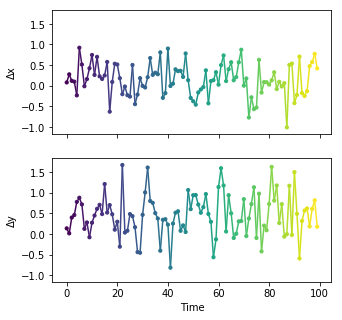

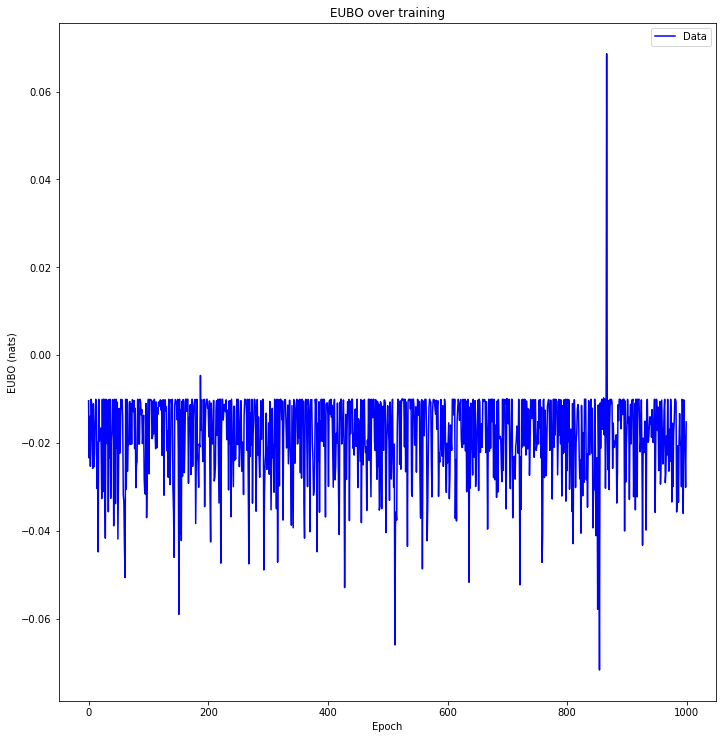

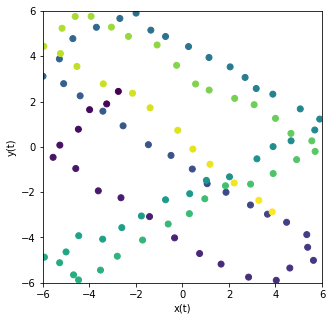

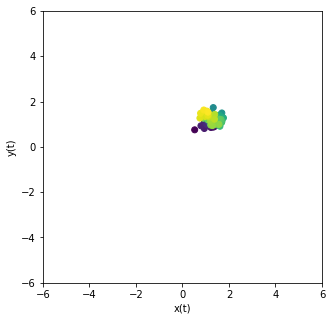

03/01/2019 14:35:18 MSE at time 0: tensor(13.6568)
03/01/2019 14:35:18 MSE at time 1: tensor(19.5235)
03/01/2019 14:35:18 MSE at time 2: tensor(24.7328)
03/01/2019 14:35:18 MSE at time 3: tensor(32.7936)
03/01/2019 14:35:18 MSE at time 4: tensor(44.2329)
03/01/2019 14:35:18 MSE at time 5: tensor(50.2365)
03/01/2019 14:35:18 MSE at time 6: tensor(37.0907)
03/01/2019 14:35:18 MSE at time 7: tensor(30.2207)
03/01/2019 14:35:18 MSE at time 8: tensor(22.1925)
03/01/2019 14:35:18 MSE at time 9: tensor(20.9599)
03/01/2019 14:35:18 MSE at time 10: tensor(27.5584)
03/01/2019 14:35:18 MSE at time 11: tensor(33.9425)
03/01/2019 14:35:18 MSE at time 12: tensor(38.2912)
03/01/2019 14:35:18 MSE at time 13: tensor(50.6298)
03/01/2019 14:35:18 MSE at time 14: tensor(58.7878)
03/01/2019 14:35:18 MSE at time 15: tensor(51.7247)
03/01/2019 14:35:18 MSE at time 16: tensor(55.0933)
03/01/2019 14:35:18 MSE at time 17: tensor(46.5407)
03/01/2019 14:35:18 MSE at time 18: tensor(42.8605)
03/01/2019 14:35:18 MS

Epoch   715: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:38:05 ELBO=-1.59400284e+02 at epoch 718
03/01/2019 14:38:05 ELBO=-1.40128052e+02 at epoch 719
03/01/2019 14:38:06 ELBO=-1.48173782e+02 at epoch 720
03/01/2019 14:38:06 ELBO=-1.57235870e+02 at epoch 721
03/01/2019 14:38:06 ELBO=-1.51679047e+02 at epoch 722
03/01/2019 14:38:06 ELBO=-1.29506134e+02 at epoch 723
03/01/2019 14:38:07 ELBO=-1.32985214e+02 at epoch 724
03/01/2019 14:38:07 ELBO=-1.31059204e+02 at epoch 725
03/01/2019 14:38:07 ELBO=-1.31945267e+02 at epoch 726
03/01/2019 14:38:07 ELBO=-1.28895645e+02 at epoch 727
03/01/2019 14:38:08 ELBO=-1.30929138e+02 at epoch 728
03/01/2019 14:38:08 ELBO=-1.34328873e+02 at epoch 729
03/01/2019 14:38:08 ELBO=-1.45839798e+02 at epoch 730
03/01/2019 14:38:08 ELBO=-1.38606522e+02 at epoch 731
03/01/2019 14:38:09 ELBO=-1.52245010e+02 at epoch 732
03/01/2019 14:38:09 ELBO=-1.31259048e+02 at epoch 733
03/01/2019 14:38:09 ELBO=-1.33844299e+02 at epoch 734
03/01/2019 14:38:09 ELBO=-1.50358521e+02 at epoch 735
03/01/2019 14:38:10 ELBO=-1.

Epoch   885: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:38:46 ELBO=-1.24714134e+02 at epoch 888
03/01/2019 14:38:46 ELBO=-1.00778175e+02 at epoch 889
03/01/2019 14:38:46 ELBO=-1.35257690e+02 at epoch 890
03/01/2019 14:38:47 ELBO=-1.36779175e+02 at epoch 891
03/01/2019 14:38:47 ELBO=-1.33008942e+02 at epoch 892
03/01/2019 14:38:47 ELBO=-1.43450562e+02 at epoch 893
03/01/2019 14:38:48 ELBO=-1.22661804e+02 at epoch 894
03/01/2019 14:38:48 ELBO=-1.15517754e+02 at epoch 895
03/01/2019 14:38:48 ELBO=-1.12436592e+02 at epoch 896
03/01/2019 14:38:48 ELBO=-1.24217567e+02 at epoch 897
03/01/2019 14:38:49 ELBO=-1.27845299e+02 at epoch 898
03/01/2019 14:38:49 ELBO=-1.23395462e+02 at epoch 899
03/01/2019 14:38:49 ELBO=-1.25127357e+02 at epoch 900
03/01/2019 14:38:49 ELBO=-1.22424255e+02 at epoch 901
03/01/2019 14:38:49 ELBO=-1.11687271e+02 at epoch 902
03/01/2019 14:38:50 ELBO=-1.07094711e+02 at epoch 903
03/01/2019 14:38:50 ELBO=-1.14670296e+02 at epoch 904
03/01/2019 14:38:50 ELBO=-1.26587471e+02 at epoch 905
03/01/2019 14:38:51 ELBO=-1.

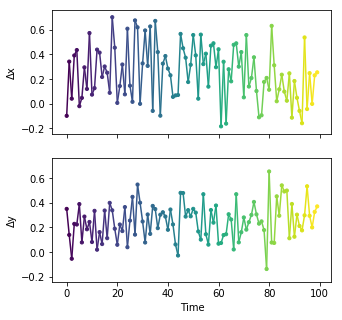

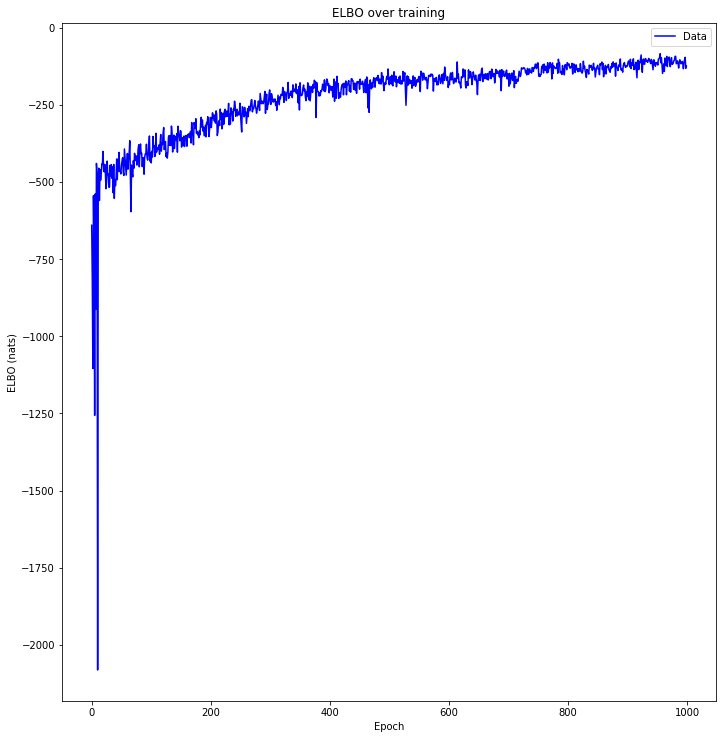

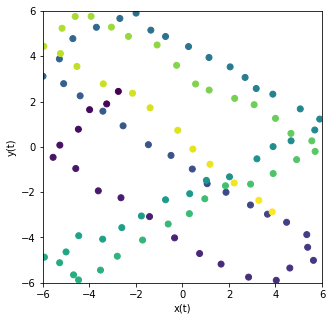

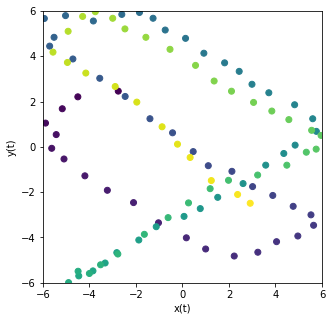

03/01/2019 14:39:14 MSE at time 0: tensor(0.0002)
03/01/2019 14:39:14 MSE at time 1: tensor(1.6373)
03/01/2019 14:39:14 MSE at time 2: tensor(1.3837)
03/01/2019 14:39:14 MSE at time 3: tensor(2.0717)
03/01/2019 14:39:14 MSE at time 4: tensor(0.2411)
03/01/2019 14:39:14 MSE at time 5: tensor(0.1620)
03/01/2019 14:39:14 MSE at time 6: tensor(0.4331)
03/01/2019 14:39:14 MSE at time 7: tensor(0.7709)
03/01/2019 14:39:14 MSE at time 8: tensor(0.4516)
03/01/2019 14:39:14 MSE at time 9: tensor(0.8559)
03/01/2019 14:39:14 MSE at time 10: tensor(0.9218)
03/01/2019 14:39:14 MSE at time 11: tensor(0.8062)
03/01/2019 14:39:14 MSE at time 12: tensor(0.8847)
03/01/2019 14:39:14 MSE at time 13: tensor(1.2484)
03/01/2019 14:39:14 MSE at time 14: tensor(2.1650)
03/01/2019 14:39:14 MSE at time 15: tensor(1.6784)
03/01/2019 14:39:14 MSE at time 16: tensor(1.6056)
03/01/2019 14:39:14 MSE at time 17: tensor(1.0077)
03/01/2019 14:39:14 MSE at time 18: tensor(0.7934)
03/01/2019 14:39:14 MSE at time 19: tenso

Epoch   410: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:41:04 ELBO=-2.93337494e+02 at epoch 413
03/01/2019 14:41:04 ELBO=-2.39578506e+02 at epoch 414
03/01/2019 14:41:04 ELBO=-2.93776581e+02 at epoch 415
03/01/2019 14:41:04 ELBO=-2.61150421e+02 at epoch 416
03/01/2019 14:41:04 ELBO=-2.28145630e+02 at epoch 417
03/01/2019 14:41:05 ELBO=-2.69200317e+02 at epoch 418
03/01/2019 14:41:05 ELBO=-2.36260605e+02 at epoch 419
03/01/2019 14:41:05 ELBO=-2.63962677e+02 at epoch 420
03/01/2019 14:41:05 ELBO=-2.49820587e+02 at epoch 421
03/01/2019 14:41:06 ELBO=-2.58494080e+02 at epoch 422
03/01/2019 14:41:06 ELBO=-2.72088989e+02 at epoch 423
03/01/2019 14:41:06 ELBO=-2.63386322e+02 at epoch 424
03/01/2019 14:41:06 ELBO=-2.28309326e+02 at epoch 425
03/01/2019 14:41:07 ELBO=-2.63322327e+02 at epoch 426
03/01/2019 14:41:07 ELBO=-2.63281921e+02 at epoch 427
03/01/2019 14:41:07 ELBO=-2.26940155e+02 at epoch 428
03/01/2019 14:41:07 ELBO=-2.48675858e+02 at epoch 429
03/01/2019 14:41:08 ELBO=-2.53889496e+02 at epoch 430
03/01/2019 14:41:08 ELBO=-2.

Epoch   511: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:41:28 ELBO=-1.74268616e+02 at epoch 514
03/01/2019 14:41:28 ELBO=-2.27101654e+02 at epoch 515
03/01/2019 14:41:28 ELBO=-2.28325500e+02 at epoch 516
03/01/2019 14:41:28 ELBO=-2.63680176e+02 at epoch 517
03/01/2019 14:41:29 ELBO=-2.34704636e+02 at epoch 518
03/01/2019 14:41:29 ELBO=-2.34337219e+02 at epoch 519
03/01/2019 14:41:29 ELBO=-2.21938034e+02 at epoch 520
03/01/2019 14:41:29 ELBO=-2.35751144e+02 at epoch 521
03/01/2019 14:41:30 ELBO=-2.19231918e+02 at epoch 522
03/01/2019 14:41:30 ELBO=-1.92560822e+02 at epoch 523
03/01/2019 14:41:30 ELBO=-2.52160507e+02 at epoch 524
03/01/2019 14:41:30 ELBO=-2.33375992e+02 at epoch 525
03/01/2019 14:41:31 ELBO=-2.23294830e+02 at epoch 526
03/01/2019 14:41:31 ELBO=-2.56952728e+02 at epoch 527
03/01/2019 14:41:31 ELBO=-2.53215149e+02 at epoch 528
03/01/2019 14:41:32 ELBO=-2.34662781e+02 at epoch 529
03/01/2019 14:41:32 ELBO=-2.68934174e+02 at epoch 530
03/01/2019 14:41:32 ELBO=-2.44767563e+02 at epoch 531
03/01/2019 14:41:32 ELBO=-2.

Epoch   614: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:41:53 ELBO=-2.12885056e+02 at epoch 617
03/01/2019 14:41:53 ELBO=-2.22261520e+02 at epoch 618
03/01/2019 14:41:53 ELBO=-1.66061554e+02 at epoch 619
03/01/2019 14:41:53 ELBO=-2.01873245e+02 at epoch 620
03/01/2019 14:41:54 ELBO=-2.25304611e+02 at epoch 621
03/01/2019 14:41:54 ELBO=-2.44442062e+02 at epoch 622
03/01/2019 14:41:54 ELBO=-2.53511978e+02 at epoch 623
03/01/2019 14:41:54 ELBO=-2.28424011e+02 at epoch 624
03/01/2019 14:41:55 ELBO=-2.30375702e+02 at epoch 625
03/01/2019 14:41:55 ELBO=-2.40415909e+02 at epoch 626
03/01/2019 14:41:55 ELBO=-2.20066025e+02 at epoch 627
03/01/2019 14:41:55 ELBO=-2.00656769e+02 at epoch 628
03/01/2019 14:41:55 ELBO=-2.13085007e+02 at epoch 629
03/01/2019 14:41:56 ELBO=-2.57313751e+02 at epoch 630
03/01/2019 14:41:56 ELBO=-2.06057693e+02 at epoch 631
03/01/2019 14:41:56 ELBO=-2.17009369e+02 at epoch 632
03/01/2019 14:41:56 ELBO=-2.14727982e+02 at epoch 633
03/01/2019 14:41:57 ELBO=-2.19766205e+02 at epoch 634
03/01/2019 14:41:57 ELBO=-2.

Epoch   719: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:42:18 ELBO=-2.11580215e+02 at epoch 721
03/01/2019 14:42:18 ELBO=-2.31051178e+02 at epoch 722
03/01/2019 14:42:19 ELBO=-2.86063202e+02 at epoch 723
03/01/2019 14:42:19 ELBO=-2.04701828e+02 at epoch 724
03/01/2019 14:42:19 ELBO=-2.31171356e+02 at epoch 725
03/01/2019 14:42:19 ELBO=-2.34080231e+02 at epoch 726
03/01/2019 14:42:20 ELBO=-2.25239349e+02 at epoch 727
03/01/2019 14:42:20 ELBO=-2.05114899e+02 at epoch 728
03/01/2019 14:42:20 ELBO=-2.04851807e+02 at epoch 729
03/01/2019 14:42:20 ELBO=-2.19589737e+02 at epoch 730
03/01/2019 14:42:20 ELBO=-2.03988251e+02 at epoch 731
03/01/2019 14:42:21 ELBO=-2.05517303e+02 at epoch 732
03/01/2019 14:42:21 ELBO=-2.41092407e+02 at epoch 733
03/01/2019 14:42:21 ELBO=-2.09080917e+02 at epoch 734
03/01/2019 14:42:21 ELBO=-2.20831741e+02 at epoch 735
03/01/2019 14:42:22 ELBO=-1.96625229e+02 at epoch 736
03/01/2019 14:42:22 ELBO=-2.10155014e+02 at epoch 737
03/01/2019 14:42:22 ELBO=-2.17030487e+02 at epoch 738
03/01/2019 14:42:22 ELBO=-2.

Epoch   820: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:42:41 ELBO=-2.08677505e+02 at epoch 823
03/01/2019 14:42:41 ELBO=-2.18466370e+02 at epoch 824
03/01/2019 14:42:41 ELBO=-1.71088242e+02 at epoch 825
03/01/2019 14:42:42 ELBO=-2.21555099e+02 at epoch 826
03/01/2019 14:42:42 ELBO=-2.39125122e+02 at epoch 827
03/01/2019 14:42:42 ELBO=-2.12058990e+02 at epoch 828
03/01/2019 14:42:42 ELBO=-2.41326263e+02 at epoch 829
03/01/2019 14:42:43 ELBO=-2.46782684e+02 at epoch 830
03/01/2019 14:42:43 ELBO=-2.04763748e+02 at epoch 831
03/01/2019 14:42:43 ELBO=-2.35920395e+02 at epoch 832
03/01/2019 14:42:43 ELBO=-2.20919708e+02 at epoch 833
03/01/2019 14:42:43 ELBO=-2.36730881e+02 at epoch 834
03/01/2019 14:42:44 ELBO=-2.35895905e+02 at epoch 835
03/01/2019 14:42:44 ELBO=-1.99999756e+02 at epoch 836
03/01/2019 14:42:44 ELBO=-2.29007339e+02 at epoch 837
03/01/2019 14:42:44 ELBO=-2.45065063e+02 at epoch 838
03/01/2019 14:42:45 ELBO=-2.30645508e+02 at epoch 839
03/01/2019 14:42:45 ELBO=-2.41087372e+02 at epoch 840
03/01/2019 14:42:45 ELBO=-1.

Epoch   921: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:43:04 ELBO=-2.21455887e+02 at epoch 923
03/01/2019 14:43:04 ELBO=-2.32163895e+02 at epoch 924
03/01/2019 14:43:04 ELBO=-2.21107162e+02 at epoch 925
03/01/2019 14:43:05 ELBO=-2.37208649e+02 at epoch 926
03/01/2019 14:43:05 ELBO=-2.23885834e+02 at epoch 927
03/01/2019 14:43:05 ELBO=-1.99920258e+02 at epoch 928
03/01/2019 14:43:05 ELBO=-2.11245071e+02 at epoch 929
03/01/2019 14:43:05 ELBO=-2.25525635e+02 at epoch 930
03/01/2019 14:43:06 ELBO=-2.30317886e+02 at epoch 931
03/01/2019 14:43:06 ELBO=-2.43982986e+02 at epoch 932
03/01/2019 14:43:06 ELBO=-1.85378754e+02 at epoch 933
03/01/2019 14:43:06 ELBO=-2.28502853e+02 at epoch 934
03/01/2019 14:43:07 ELBO=-1.86522644e+02 at epoch 935
03/01/2019 14:43:07 ELBO=-2.27265869e+02 at epoch 936
03/01/2019 14:43:07 ELBO=-2.40004730e+02 at epoch 937
03/01/2019 14:43:07 ELBO=-2.00253769e+02 at epoch 938
03/01/2019 14:43:08 ELBO=-2.08992828e+02 at epoch 939
03/01/2019 14:43:08 ELBO=-2.22627808e+02 at epoch 940
03/01/2019 14:43:08 ELBO=-2.

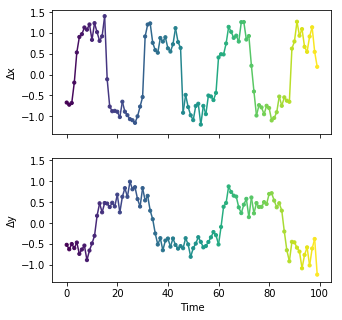

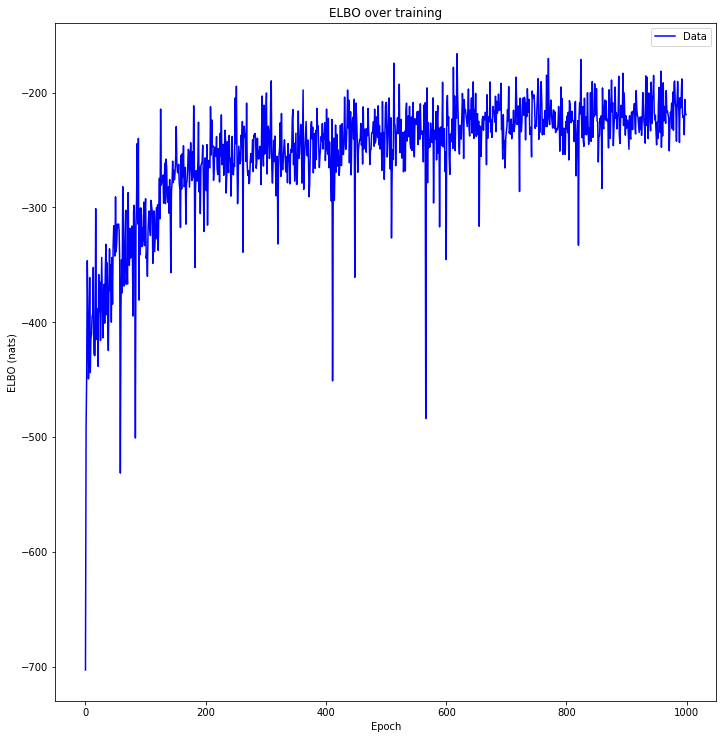

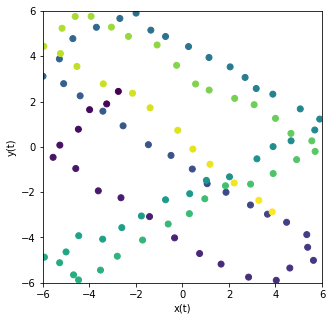

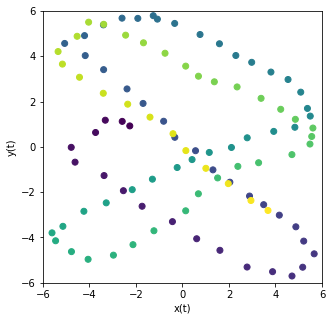

03/01/2019 14:43:23 MSE at time 0: tensor(2.5657)
03/01/2019 14:43:23 MSE at time 1: tensor(1.0416)
03/01/2019 14:43:23 MSE at time 2: tensor(0.6713)
03/01/2019 14:43:23 MSE at time 3: tensor(0.5679)
03/01/2019 14:43:23 MSE at time 4: tensor(0.2496)
03/01/2019 14:43:23 MSE at time 5: tensor(0.9376)
03/01/2019 14:43:23 MSE at time 6: tensor(1.5785)
03/01/2019 14:43:23 MSE at time 7: tensor(1.1631)
03/01/2019 14:43:23 MSE at time 8: tensor(0.9677)
03/01/2019 14:43:23 MSE at time 9: tensor(1.0201)
03/01/2019 14:43:23 MSE at time 10: tensor(0.9051)
03/01/2019 14:43:23 MSE at time 11: tensor(0.7846)
03/01/2019 14:43:23 MSE at time 12: tensor(1.2683)
03/01/2019 14:43:23 MSE at time 13: tensor(1.1223)
03/01/2019 14:43:23 MSE at time 14: tensor(0.4936)
03/01/2019 14:43:23 MSE at time 15: tensor(0.3081)
03/01/2019 14:43:23 MSE at time 16: tensor(0.0839)
03/01/2019 14:43:23 MSE at time 17: tensor(0.1030)
03/01/2019 14:43:23 MSE at time 18: tensor(0.3393)
03/01/2019 14:43:23 MSE at time 19: tenso

Epoch   238: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:44:35 ELBO=-3.62796509e+02 at epoch 241
03/01/2019 14:44:36 ELBO=-3.54594452e+02 at epoch 242
03/01/2019 14:44:36 ELBO=-2.57990936e+02 at epoch 243
03/01/2019 14:44:36 ELBO=-2.98945679e+02 at epoch 244
03/01/2019 14:44:36 ELBO=-2.91880219e+02 at epoch 245
03/01/2019 14:44:37 ELBO=-3.00915558e+02 at epoch 246
03/01/2019 14:44:37 ELBO=-3.70739471e+02 at epoch 247
03/01/2019 14:44:37 ELBO=-2.76515076e+02 at epoch 248
03/01/2019 14:44:38 ELBO=-3.46380463e+02 at epoch 249
03/01/2019 14:44:38 ELBO=-3.23622864e+02 at epoch 250
03/01/2019 14:44:38 ELBO=-3.72998688e+02 at epoch 251
03/01/2019 14:44:38 ELBO=-3.92047058e+02 at epoch 252
03/01/2019 14:44:39 ELBO=-4.20479004e+02 at epoch 253
03/01/2019 14:44:39 ELBO=-1.49856003e+02 at epoch 254
03/01/2019 14:44:39 ELBO=-2.65307953e+02 at epoch 255
03/01/2019 14:44:40 ELBO=-2.37531372e+02 at epoch 256
03/01/2019 14:44:40 ELBO=-6.20652100e+02 at epoch 257
03/01/2019 14:44:40 ELBO=-2.82506805e+02 at epoch 258
03/01/2019 14:44:40 ELBO=-3.

Epoch   362: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:45:09 ELBO=-3.12062256e+02 at epoch 365
03/01/2019 14:45:09 ELBO=-3.42128601e+02 at epoch 366
03/01/2019 14:45:09 ELBO=-3.72341675e+02 at epoch 367
03/01/2019 14:45:09 ELBO=-1.99991440e+02 at epoch 368
03/01/2019 14:45:10 ELBO=-2.28368286e+02 at epoch 369
03/01/2019 14:45:10 ELBO=-3.22812592e+02 at epoch 370
03/01/2019 14:45:10 ELBO=-2.07650421e+02 at epoch 371
03/01/2019 14:45:11 ELBO=-3.41178925e+02 at epoch 372
03/01/2019 14:45:11 ELBO=-2.38787415e+02 at epoch 373
03/01/2019 14:45:11 ELBO=-3.31752319e+02 at epoch 374
03/01/2019 14:45:11 ELBO=-3.48801971e+02 at epoch 375
03/01/2019 14:45:12 ELBO=-3.23528748e+02 at epoch 376
03/01/2019 14:45:12 ELBO=-2.66468567e+02 at epoch 377
03/01/2019 14:45:12 ELBO=-1.23257179e+02 at epoch 378
03/01/2019 14:45:12 ELBO=-2.42806488e+02 at epoch 379
03/01/2019 14:45:13 ELBO=-2.49017365e+02 at epoch 380
03/01/2019 14:45:13 ELBO=-3.13171539e+02 at epoch 381
03/01/2019 14:45:13 ELBO=-2.58260345e+02 at epoch 382
03/01/2019 14:45:14 ELBO=-1.

Epoch   483: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:45:41 ELBO=-3.15046661e+02 at epoch 486
03/01/2019 14:45:41 ELBO=-2.87236176e+02 at epoch 487
03/01/2019 14:45:42 ELBO=-3.49372437e+02 at epoch 488
03/01/2019 14:45:42 ELBO=-2.44072739e+02 at epoch 489
03/01/2019 14:45:42 ELBO=-3.78350830e+02 at epoch 490
03/01/2019 14:45:43 ELBO=-2.53987457e+02 at epoch 491
03/01/2019 14:45:43 ELBO=-3.44953888e+02 at epoch 492
03/01/2019 14:45:43 ELBO=-3.56715454e+02 at epoch 493
03/01/2019 14:45:43 ELBO=-4.11798584e+02 at epoch 494
03/01/2019 14:45:44 ELBO=-4.48270294e+02 at epoch 495
03/01/2019 14:45:44 ELBO=-3.23754089e+02 at epoch 496
03/01/2019 14:45:44 ELBO=-2.75389587e+02 at epoch 497
03/01/2019 14:45:44 ELBO=-3.01071045e+02 at epoch 498
03/01/2019 14:45:45 ELBO=-3.41172516e+02 at epoch 499
03/01/2019 14:45:45 ELBO=-3.79251312e+02 at epoch 500
03/01/2019 14:45:45 ELBO=-3.68499725e+02 at epoch 501
03/01/2019 14:45:46 ELBO=-3.16216248e+02 at epoch 502
03/01/2019 14:45:46 ELBO=-4.51825256e+02 at epoch 503
03/01/2019 14:45:46 ELBO=-1.

Epoch   584: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:46:09 ELBO=-3.90365021e+02 at epoch 587
03/01/2019 14:46:09 ELBO=-3.41612274e+02 at epoch 588
03/01/2019 14:46:10 ELBO=-1.83234680e+02 at epoch 589
03/01/2019 14:46:10 ELBO=-7.18025436e+01 at epoch 590
03/01/2019 14:46:10 ELBO=-3.57135132e+02 at epoch 591
03/01/2019 14:46:10 ELBO=-3.20094421e+02 at epoch 592
03/01/2019 14:46:11 ELBO=-2.22669647e+02 at epoch 593
03/01/2019 14:46:11 ELBO=-3.77398590e+02 at epoch 594
03/01/2019 14:46:11 ELBO=-2.94393555e+02 at epoch 595
03/01/2019 14:46:12 ELBO=-2.98022797e+02 at epoch 596
03/01/2019 14:46:12 ELBO=-2.69117096e+02 at epoch 597
03/01/2019 14:46:12 ELBO=-2.64465149e+02 at epoch 598
03/01/2019 14:46:12 ELBO=-2.46781799e+02 at epoch 599
03/01/2019 14:46:13 ELBO=-3.60056885e+02 at epoch 600
03/01/2019 14:46:13 ELBO=-4.01706726e+02 at epoch 601
03/01/2019 14:46:13 ELBO=-3.95180237e+02 at epoch 602
03/01/2019 14:46:14 ELBO=-2.49224899e+02 at epoch 603
03/01/2019 14:46:14 ELBO=-3.51652832e+02 at epoch 604
03/01/2019 14:46:14 ELBO=-3.

Epoch   690: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:46:40 ELBO=-2.97097107e+02 at epoch 693
03/01/2019 14:46:40 ELBO=-4.64602051e+02 at epoch 694
03/01/2019 14:46:41 ELBO=-2.85813538e+02 at epoch 695
03/01/2019 14:46:41 ELBO=-3.03796906e+02 at epoch 696
03/01/2019 14:46:41 ELBO=-3.97233429e+02 at epoch 697
03/01/2019 14:46:41 ELBO=-3.12186371e+02 at epoch 698
03/01/2019 14:46:42 ELBO=-3.83998779e+02 at epoch 699
03/01/2019 14:46:42 ELBO=-3.68744232e+02 at epoch 700
03/01/2019 14:46:42 ELBO=-3.02994293e+02 at epoch 701
03/01/2019 14:46:42 ELBO=-3.94714539e+02 at epoch 702
03/01/2019 14:46:43 ELBO=-3.07332733e+02 at epoch 703
03/01/2019 14:46:43 ELBO=-3.10808258e+02 at epoch 704
03/01/2019 14:46:43 ELBO=-3.48845825e+02 at epoch 705
03/01/2019 14:46:43 ELBO=-2.44481583e+02 at epoch 706
03/01/2019 14:46:44 ELBO=-2.89014099e+02 at epoch 707
03/01/2019 14:46:44 ELBO=-2.02139572e+02 at epoch 708
03/01/2019 14:46:44 ELBO=-3.78624023e+02 at epoch 709
03/01/2019 14:46:44 ELBO=-3.16668304e+02 at epoch 710
03/01/2019 14:46:45 ELBO=-3.

Epoch   791: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:47:08 ELBO=-2.39020020e+02 at epoch 794
03/01/2019 14:47:08 ELBO=-1.20245712e+02 at epoch 795
03/01/2019 14:47:09 ELBO=-2.15730682e+02 at epoch 796
03/01/2019 14:47:09 ELBO=-2.40934860e+02 at epoch 797
03/01/2019 14:47:09 ELBO=-3.78788757e+02 at epoch 798
03/01/2019 14:47:09 ELBO=-2.33623917e+02 at epoch 799
03/01/2019 14:47:10 ELBO=-3.42141266e+02 at epoch 800
03/01/2019 14:47:10 ELBO=-4.15280212e+02 at epoch 801
03/01/2019 14:47:10 ELBO=-2.96979004e+02 at epoch 802
03/01/2019 14:47:10 ELBO=-3.24201019e+02 at epoch 803
03/01/2019 14:47:11 ELBO=-2.91997375e+02 at epoch 804
03/01/2019 14:47:11 ELBO=-2.96502625e+02 at epoch 805
03/01/2019 14:47:11 ELBO=-3.58069061e+02 at epoch 806
03/01/2019 14:47:12 ELBO=-3.50930328e+02 at epoch 807
03/01/2019 14:47:12 ELBO=-3.82951324e+02 at epoch 808
03/01/2019 14:47:12 ELBO=-3.20571503e+02 at epoch 809
03/01/2019 14:47:12 ELBO=-3.33661560e+02 at epoch 810
03/01/2019 14:47:13 ELBO=-3.95849304e+02 at epoch 811
03/01/2019 14:47:13 ELBO=-3.

Epoch   892: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 14:47:36 ELBO=-2.14611496e+02 at epoch 895
03/01/2019 14:47:37 ELBO=-3.24755859e+02 at epoch 896
03/01/2019 14:47:37 ELBO=-3.21394196e+02 at epoch 897
03/01/2019 14:47:37 ELBO=-3.58164368e+02 at epoch 898
03/01/2019 14:47:37 ELBO=-3.24688202e+02 at epoch 899
03/01/2019 14:47:38 ELBO=-2.90994995e+02 at epoch 900
03/01/2019 14:47:38 ELBO=-3.06931458e+02 at epoch 901
03/01/2019 14:47:38 ELBO=-2.93542725e+02 at epoch 902
03/01/2019 14:47:39 ELBO=-3.07684601e+02 at epoch 903
03/01/2019 14:47:39 ELBO=-4.40483551e+02 at epoch 904
03/01/2019 14:47:39 ELBO=-3.81867188e+02 at epoch 905
03/01/2019 14:47:40 ELBO=-3.11984589e+02 at epoch 906
03/01/2019 14:47:40 ELBO=-2.81418671e+02 at epoch 907
03/01/2019 14:47:40 ELBO=-2.47261169e+02 at epoch 908
03/01/2019 14:47:40 ELBO=-2.72488739e+02 at epoch 909
03/01/2019 14:47:41 ELBO=-3.25450104e+02 at epoch 910
03/01/2019 14:47:41 ELBO=-3.45032990e+02 at epoch 911
03/01/2019 14:47:41 ELBO=-4.11083984e+02 at epoch 912
03/01/2019 14:47:42 ELBO=-3.

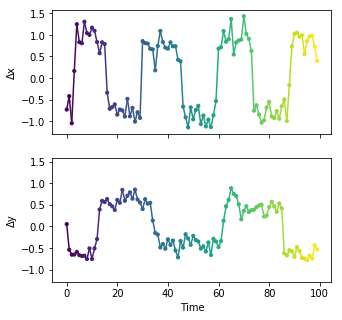

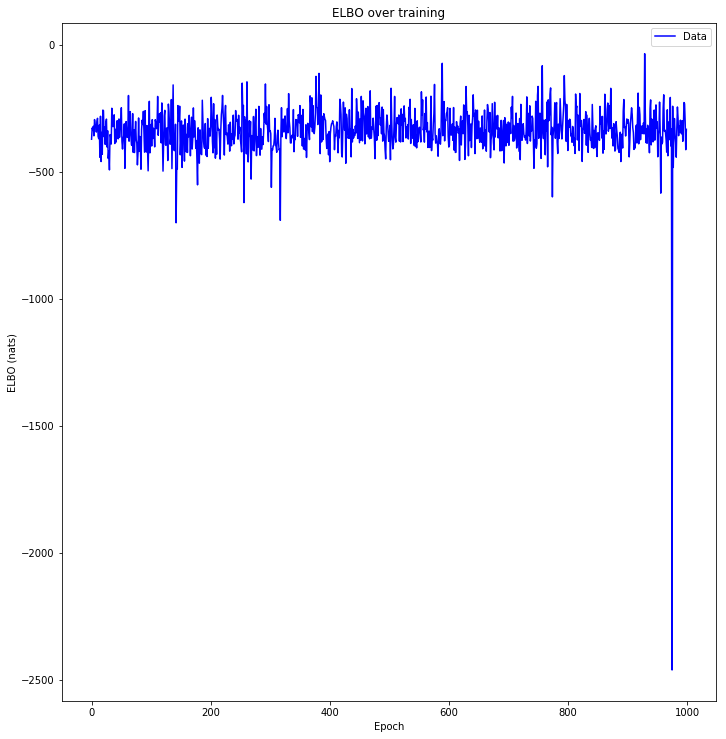

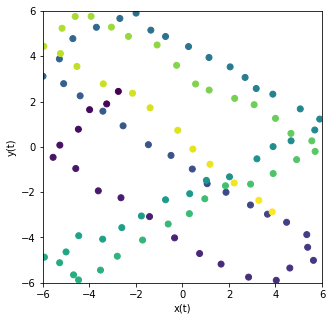

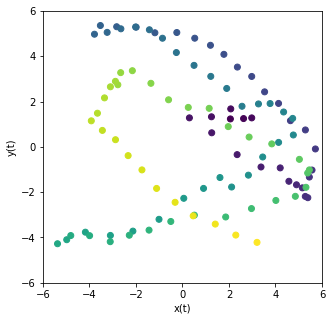

03/01/2019 14:48:14 MSE at time 0: tensor(24.6974)
03/01/2019 14:48:14 MSE at time 1: tensor(35.0845)
03/01/2019 14:48:14 MSE at time 2: tensor(48.7598)
03/01/2019 14:48:14 MSE at time 3: tensor(43.7538)
03/01/2019 14:48:14 MSE at time 4: tensor(44.0927)
03/01/2019 14:48:14 MSE at time 5: tensor(37.4081)
03/01/2019 14:48:14 MSE at time 6: tensor(36.6741)
03/01/2019 14:48:14 MSE at time 7: tensor(38.2084)
03/01/2019 14:48:14 MSE at time 8: tensor(38.1184)
03/01/2019 14:48:14 MSE at time 9: tensor(36.2154)
03/01/2019 14:48:14 MSE at time 10: tensor(30.4118)
03/01/2019 14:48:14 MSE at time 11: tensor(26.5790)
03/01/2019 14:48:14 MSE at time 12: tensor(23.5592)
03/01/2019 14:48:14 MSE at time 13: tensor(18.6483)
03/01/2019 14:48:14 MSE at time 14: tensor(15.1445)
03/01/2019 14:48:14 MSE at time 15: tensor(16.8394)
03/01/2019 14:48:14 MSE at time 16: tensor(15.8928)
03/01/2019 14:48:14 MSE at time 17: tensor(18.9542)
03/01/2019 14:48:14 MSE at time 18: tensor(21.3518)
03/01/2019 14:48:14 MS

Epoch   165: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:48:40 EUBO=-4.95430750e-22 at epoch 168
03/01/2019 14:48:41 EUBO=0.00000000e+00 at epoch 169
03/01/2019 14:48:41 EUBO=-3.39708725e-25 at epoch 170
03/01/2019 14:48:41 EUBO=-2.05339130e-39 at epoch 171
03/01/2019 14:48:41 EUBO=-3.11761600e-33 at epoch 172
03/01/2019 14:48:41 EUBO=0.00000000e+00 at epoch 173
03/01/2019 14:48:41 EUBO=-8.30060940e-29 at epoch 174
03/01/2019 14:48:41 EUBO=-1.77134950e-15 at epoch 175
03/01/2019 14:48:42 EUBO=-5.54467096e-26 at epoch 176
03/01/2019 14:48:42 EUBO=0.00000000e+00 at epoch 177
03/01/2019 14:48:42 EUBO=0.00000000e+00 at epoch 178
03/01/2019 14:48:42 EUBO=0.00000000e+00 at epoch 179
03/01/2019 14:48:42 EUBO=0.00000000e+00 at epoch 180
03/01/2019 14:48:42 EUBO=-1.04955810e-11 at epoch 181
03/01/2019 14:48:42 EUBO=-8.10599309e-13 at epoch 182
03/01/2019 14:48:43 EUBO=-4.87420829e-20 at epoch 183
03/01/2019 14:48:43 EUBO=0.00000000e+00 at epoch 184
03/01/2019 14:48:43 EUBO=0.00000000e+00 at epoch 185
03/01/2019 14:48:43 EUBO=-1.15687853

Epoch   342: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:49:10 EUBO=-3.84455338e-15 at epoch 345
03/01/2019 14:49:10 EUBO=-5.29581748e-21 at epoch 346
03/01/2019 14:49:10 EUBO=-4.43485303e-29 at epoch 347
03/01/2019 14:49:10 EUBO=-2.73068361e-16 at epoch 348
03/01/2019 14:49:10 EUBO=0.00000000e+00 at epoch 349
03/01/2019 14:49:10 EUBO=-7.94555556e-13 at epoch 350
03/01/2019 14:49:11 EUBO=0.00000000e+00 at epoch 351
03/01/2019 14:49:11 EUBO=0.00000000e+00 at epoch 352
03/01/2019 14:49:11 EUBO=0.00000000e+00 at epoch 353
03/01/2019 14:49:11 EUBO=-1.27850447e-21 at epoch 354
03/01/2019 14:49:11 EUBO=0.00000000e+00 at epoch 355
03/01/2019 14:49:11 EUBO=0.00000000e+00 at epoch 356
03/01/2019 14:49:12 EUBO=0.00000000e+00 at epoch 357
03/01/2019 14:49:12 EUBO=0.00000000e+00 at epoch 358
03/01/2019 14:49:12 EUBO=0.00000000e+00 at epoch 359
03/01/2019 14:49:12 EUBO=-2.88655260e-27 at epoch 360
03/01/2019 14:49:12 EUBO=0.00000000e+00 at epoch 361
03/01/2019 14:49:12 EUBO=0.00000000e+00 at epoch 362
03/01/2019 14:49:13 EUBO=0.00000000e+00

Epoch   443: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:49:26 EUBO=0.00000000e+00 at epoch 446
03/01/2019 14:49:26 EUBO=-8.04412423e-35 at epoch 447
03/01/2019 14:49:26 EUBO=-5.38248002e-31 at epoch 448
03/01/2019 14:49:27 EUBO=-2.46154442e-13 at epoch 449
03/01/2019 14:49:27 EUBO=0.00000000e+00 at epoch 450
03/01/2019 14:49:27 EUBO=-1.03334425e-25 at epoch 451
03/01/2019 14:49:27 EUBO=-1.74386680e-16 at epoch 452
03/01/2019 14:49:27 EUBO=0.00000000e+00 at epoch 453
03/01/2019 14:49:27 EUBO=-2.58638587e-23 at epoch 454
03/01/2019 14:49:27 EUBO=-1.17047572e-09 at epoch 455
03/01/2019 14:49:28 EUBO=-1.49092220e-36 at epoch 456
03/01/2019 14:49:28 EUBO=-1.23918760e-15 at epoch 457
03/01/2019 14:49:28 EUBO=0.00000000e+00 at epoch 458
03/01/2019 14:49:28 EUBO=-1.44522234e-29 at epoch 459
03/01/2019 14:49:28 EUBO=0.00000000e+00 at epoch 460
03/01/2019 14:49:28 EUBO=-1.93303798e-39 at epoch 461
03/01/2019 14:49:29 EUBO=-1.99658352e-08 at epoch 462
03/01/2019 14:49:29 EUBO=0.00000000e+00 at epoch 463
03/01/2019 14:49:29 EUBO=0.0000000

Epoch   544: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:49:42 EUBO=-2.85269516e-14 at epoch 547
03/01/2019 14:49:42 EUBO=-1.21322433e-30 at epoch 548
03/01/2019 14:49:42 EUBO=-8.45589034e-36 at epoch 549
03/01/2019 14:49:42 EUBO=-1.16523652e-30 at epoch 550
03/01/2019 14:49:43 EUBO=0.00000000e+00 at epoch 551
03/01/2019 14:49:43 EUBO=0.00000000e+00 at epoch 552
03/01/2019 14:49:43 EUBO=-1.54487798e-18 at epoch 553
03/01/2019 14:49:43 EUBO=-2.07036289e-19 at epoch 554
03/01/2019 14:49:43 EUBO=-6.37346131e-33 at epoch 555
03/01/2019 14:49:43 EUBO=-1.75176321e-41 at epoch 556
03/01/2019 14:49:44 EUBO=-1.25542480e-21 at epoch 557
03/01/2019 14:49:44 EUBO=-4.99254164e-20 at epoch 558
03/01/2019 14:49:44 EUBO=0.00000000e+00 at epoch 559
03/01/2019 14:49:44 EUBO=0.00000000e+00 at epoch 560
03/01/2019 14:49:44 EUBO=0.00000000e+00 at epoch 561
03/01/2019 14:49:44 EUBO=-6.70222798e-32 at epoch 562
03/01/2019 14:49:45 EUBO=0.00000000e+00 at epoch 563
03/01/2019 14:49:45 EUBO=-4.40684955e-21 at epoch 564
03/01/2019 14:49:45 EUBO=0.0000000

Epoch   645: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:49:58 EUBO=0.00000000e+00 at epoch 648
03/01/2019 14:49:58 EUBO=-2.52087989e-40 at epoch 649
03/01/2019 14:49:58 EUBO=0.00000000e+00 at epoch 650
03/01/2019 14:49:58 EUBO=-2.87266185e-43 at epoch 651
03/01/2019 14:49:59 EUBO=0.00000000e+00 at epoch 652
03/01/2019 14:49:59 EUBO=0.00000000e+00 at epoch 653
03/01/2019 14:49:59 EUBO=0.00000000e+00 at epoch 654
03/01/2019 14:49:59 EUBO=0.00000000e+00 at epoch 655
03/01/2019 14:49:59 EUBO=-5.04611781e-40 at epoch 656
03/01/2019 14:49:59 EUBO=0.00000000e+00 at epoch 657
03/01/2019 14:49:59 EUBO=0.00000000e+00 at epoch 658
03/01/2019 14:50:00 EUBO=-5.94867251e-37 at epoch 659
03/01/2019 14:50:00 EUBO=0.00000000e+00 at epoch 660
03/01/2019 14:50:00 EUBO=0.00000000e+00 at epoch 661
03/01/2019 14:50:00 EUBO=-2.26143259e-18 at epoch 662
03/01/2019 14:50:00 EUBO=0.00000000e+00 at epoch 663
03/01/2019 14:50:00 EUBO=-2.03818862e-41 at epoch 664
03/01/2019 14:50:01 EUBO=-2.87266185e-43 at epoch 665
03/01/2019 14:50:01 EUBO=-6.77858993e-2

Epoch   904: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:50:38 EUBO=-1.59277279e-12 at epoch 907
03/01/2019 14:50:39 EUBO=-4.69701232e-41 at epoch 908
03/01/2019 14:50:39 EUBO=-9.04436370e-15 at epoch 909
03/01/2019 14:50:39 EUBO=0.00000000e+00 at epoch 910
03/01/2019 14:50:39 EUBO=-1.96904087e-30 at epoch 911
03/01/2019 14:50:39 EUBO=-2.27935369e-27 at epoch 912
03/01/2019 14:50:39 EUBO=-6.08707099e-23 at epoch 913
03/01/2019 14:50:39 EUBO=0.00000000e+00 at epoch 914
03/01/2019 14:50:40 EUBO=0.00000000e+00 at epoch 915
03/01/2019 14:50:40 EUBO=0.00000000e+00 at epoch 916
03/01/2019 14:50:40 EUBO=-6.20787475e-34 at epoch 917
03/01/2019 14:50:40 EUBO=-2.47802474e-35 at epoch 918
03/01/2019 14:50:40 EUBO=-2.48782245e-12 at epoch 919
03/01/2019 14:50:40 EUBO=-3.09585690e-11 at epoch 920
03/01/2019 14:50:41 EUBO=-6.96128643e-40 at epoch 921
03/01/2019 14:50:41 EUBO=0.00000000e+00 at epoch 922
03/01/2019 14:50:41 EUBO=-1.48779311e-31 at epoch 923
03/01/2019 14:50:41 EUBO=-1.92940617e-26 at epoch 924
03/01/2019 14:50:41 EUBO=-3.96645

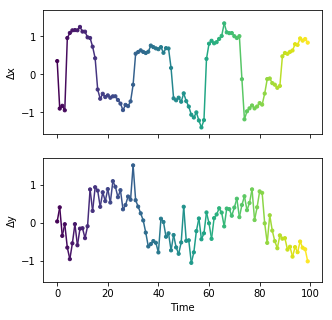

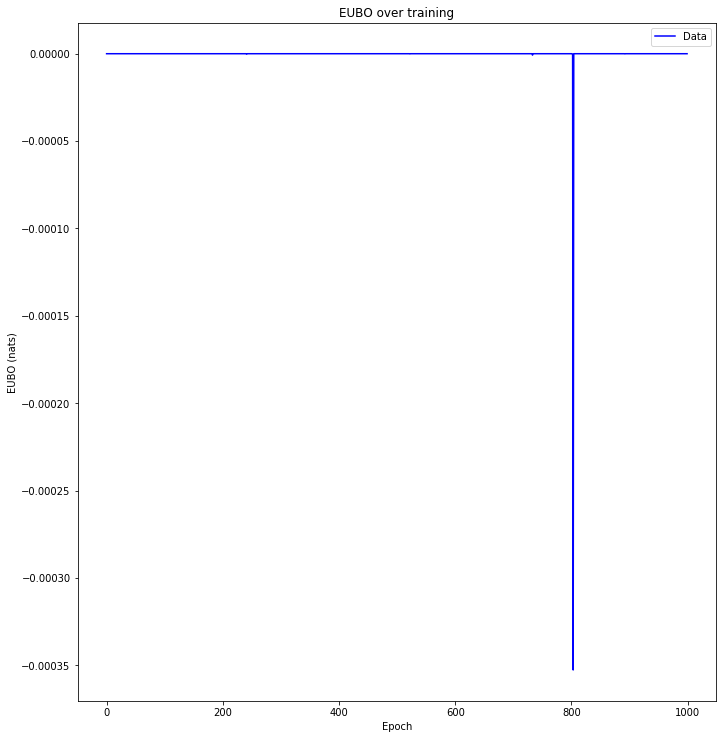

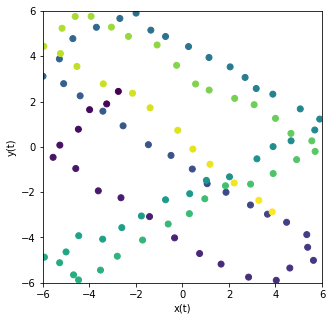

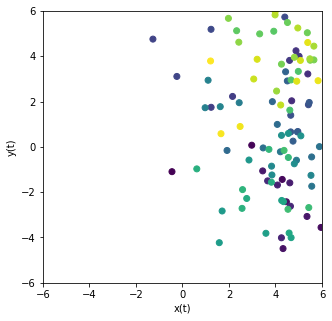

03/01/2019 14:50:53 MSE at time 0: tensor(17.8815)
03/01/2019 14:50:53 MSE at time 1: tensor(42.2455)
03/01/2019 14:50:53 MSE at time 2: tensor(78.1359)
03/01/2019 14:50:53 MSE at time 3: tensor(127.7385)
03/01/2019 14:50:53 MSE at time 4: tensor(101.2077)
03/01/2019 14:50:53 MSE at time 5: tensor(114.0471)
03/01/2019 14:50:53 MSE at time 6: tensor(103.3927)
03/01/2019 14:50:53 MSE at time 7: tensor(50.7487)
03/01/2019 14:50:53 MSE at time 8: tensor(53.1658)
03/01/2019 14:50:53 MSE at time 9: tensor(32.2203)
03/01/2019 14:50:53 MSE at time 10: tensor(21.1234)
03/01/2019 14:50:53 MSE at time 11: tensor(19.6399)
03/01/2019 14:50:53 MSE at time 12: tensor(17.5102)
03/01/2019 14:50:53 MSE at time 13: tensor(64.0407)
03/01/2019 14:50:53 MSE at time 14: tensor(84.8315)
03/01/2019 14:50:53 MSE at time 15: tensor(92.0659)
03/01/2019 14:50:53 MSE at time 16: tensor(81.5539)
03/01/2019 14:50:53 MSE at time 17: tensor(68.6681)
03/01/2019 14:50:53 MSE at time 18: tensor(47.4080)
03/01/2019 14:50:5

Epoch   129: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:51:14 EUBO=-2.98510075e-01 at epoch 132
03/01/2019 14:51:14 EUBO=-1.05361938e-01 at epoch 133
03/01/2019 14:51:14 EUBO=-2.20281363e-01 at epoch 134
03/01/2019 14:51:15 EUBO=-1.05532169e-01 at epoch 135
03/01/2019 14:51:15 EUBO=-2.23174095e-01 at epoch 136
03/01/2019 14:51:15 EUBO=-1.06837988e-01 at epoch 137
03/01/2019 14:51:15 EUBO=-1.05379581e-01 at epoch 138
03/01/2019 14:51:15 EUBO=-1.20665312e-01 at epoch 139
03/01/2019 14:51:15 EUBO=-1.05360746e-01 at epoch 140
03/01/2019 14:51:15 EUBO=-2.11488962e-01 at epoch 141
03/01/2019 14:51:16 EUBO=-2.14837313e-01 at epoch 142
03/01/2019 14:51:16 EUBO=-1.05360508e-01 at epoch 143
03/01/2019 14:51:16 EUBO=-1.06348038e-01 at epoch 144
03/01/2019 14:51:16 EUBO=-1.05360508e-01 at epoch 145
03/01/2019 14:51:16 EUBO=-1.05525494e-01 at epoch 146
03/01/2019 14:51:16 EUBO=-1.05374575e-01 at epoch 147
03/01/2019 14:51:16 EUBO=-2.23166704e-01 at epoch 148
03/01/2019 14:51:17 EUBO=-3.53508115e-01 at epoch 149
03/01/2019 14:51:17 EUBO=-2.

Epoch   230: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:51:30 EUBO=-1.05361938e-01 at epoch 233
03/01/2019 14:51:31 EUBO=-1.05457783e-01 at epoch 234
03/01/2019 14:51:31 EUBO=-3.18990827e-01 at epoch 235
03/01/2019 14:51:31 EUBO=-1.05360508e-01 at epoch 236
03/01/2019 14:51:31 EUBO=-1.21317863e-01 at epoch 237
03/01/2019 14:51:31 EUBO=-1.05360508e-01 at epoch 238
03/01/2019 14:51:31 EUBO=-1.22353315e-01 at epoch 239
03/01/2019 14:51:31 EUBO=-1.08434916e-01 at epoch 240
03/01/2019 14:51:32 EUBO=-1.05360746e-01 at epoch 241
03/01/2019 14:51:32 EUBO=-1.05360508e-01 at epoch 242
03/01/2019 14:51:32 EUBO=-2.20832348e-01 at epoch 243
03/01/2019 14:51:32 EUBO=-1.35176897e-01 at epoch 244
03/01/2019 14:51:32 EUBO=-1.05360508e-01 at epoch 245
03/01/2019 14:51:33 EUBO=-1.35982752e-01 at epoch 246
03/01/2019 14:51:33 EUBO=-1.05357647e-01 at epoch 247
03/01/2019 14:51:33 EUBO=-1.05362177e-01 at epoch 248
03/01/2019 14:51:33 EUBO=-2.14469433e-01 at epoch 249
03/01/2019 14:51:33 EUBO=-1.05360508e-01 at epoch 250
03/01/2019 14:51:33 EUBO=-1.

Epoch   331: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:51:47 EUBO=-2.23347425e-01 at epoch 334
03/01/2019 14:51:47 EUBO=-1.05369568e-01 at epoch 335
03/01/2019 14:51:47 EUBO=-1.05360508e-01 at epoch 336
03/01/2019 14:51:47 EUBO=-2.98385143e-01 at epoch 337
03/01/2019 14:51:47 EUBO=-1.05360508e-01 at epoch 338
03/01/2019 14:51:47 EUBO=-2.41531610e-01 at epoch 339
03/01/2019 14:51:47 EUBO=-1.05371237e-01 at epoch 340
03/01/2019 14:51:48 EUBO=-1.09238386e-01 at epoch 341
03/01/2019 14:51:48 EUBO=-1.05361700e-01 at epoch 342
03/01/2019 14:51:48 EUBO=-1.05360508e-01 at epoch 343
03/01/2019 14:51:48 EUBO=-1.74937963e-01 at epoch 344
03/01/2019 14:51:48 EUBO=-2.70995140e-01 at epoch 345
03/01/2019 14:51:48 EUBO=-1.06120110e-01 at epoch 346
03/01/2019 14:51:48 EUBO=-1.05402231e-01 at epoch 347
03/01/2019 14:51:49 EUBO=-1.05711222e-01 at epoch 348
03/01/2019 14:51:49 EUBO=-1.20685339e-01 at epoch 349
03/01/2019 14:51:49 EUBO=-1.05397224e-01 at epoch 350
03/01/2019 14:51:49 EUBO=-1.71934366e-01 at epoch 351
03/01/2019 14:51:49 EUBO=-1.

Epoch   503: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:52:14 EUBO=-1.06423616e-01 at epoch 506
03/01/2019 14:52:15 EUBO=-1.05360508e-01 at epoch 507
03/01/2019 14:52:15 EUBO=-2.23143578e-01 at epoch 508
03/01/2019 14:52:15 EUBO=-1.05360746e-01 at epoch 509
03/01/2019 14:52:15 EUBO=-1.05360508e-01 at epoch 510
03/01/2019 14:52:15 EUBO=-1.05360508e-01 at epoch 511
03/01/2019 14:52:15 EUBO=-1.05440378e-01 at epoch 512
03/01/2019 14:52:16 EUBO=-1.05360746e-01 at epoch 513
03/01/2019 14:52:16 EUBO=-2.23140240e-01 at epoch 514
03/01/2019 14:52:16 EUBO=-1.06219769e-01 at epoch 515
03/01/2019 14:52:16 EUBO=-1.05360746e-01 at epoch 516
03/01/2019 14:52:16 EUBO=-1.58629656e-01 at epoch 517
03/01/2019 14:52:16 EUBO=-1.14983797e-01 at epoch 518
03/01/2019 14:52:17 EUBO=-1.83186531e-01 at epoch 519
03/01/2019 14:52:17 EUBO=-2.23143578e-01 at epoch 520
03/01/2019 14:52:17 EUBO=-1.25613451e-01 at epoch 521
03/01/2019 14:52:17 EUBO=-2.08625793e-01 at epoch 522
03/01/2019 14:52:17 EUBO=-1.48174763e-01 at epoch 523
03/01/2019 14:52:18 EUBO=-1.

Epoch   752: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:52:54 EUBO=-1.05360508e-01 at epoch 755
03/01/2019 14:52:55 EUBO=-2.23143578e-01 at epoch 756
03/01/2019 14:52:55 EUBO=-1.05367661e-01 at epoch 757
03/01/2019 14:52:55 EUBO=-1.05371475e-01 at epoch 758
03/01/2019 14:52:55 EUBO=-1.60561323e-01 at epoch 759
03/01/2019 14:52:55 EUBO=-2.23143578e-01 at epoch 760
03/01/2019 14:52:55 EUBO=-1.05360508e-01 at epoch 761
03/01/2019 14:52:55 EUBO=-1.05360508e-01 at epoch 762
03/01/2019 14:52:56 EUBO=-1.06816769e-01 at epoch 763
03/01/2019 14:52:56 EUBO=-1.05360508e-01 at epoch 764
03/01/2019 14:52:56 EUBO=-2.08677292e-01 at epoch 765
03/01/2019 14:52:56 EUBO=-1.05360508e-01 at epoch 766
03/01/2019 14:52:56 EUBO=-2.22645521e-01 at epoch 767
03/01/2019 14:52:56 EUBO=-1.05516911e-01 at epoch 768
03/01/2019 14:52:56 EUBO=-1.08961344e-01 at epoch 769
03/01/2019 14:52:57 EUBO=-1.05361700e-01 at epoch 770
03/01/2019 14:52:57 EUBO=-2.88181305e-01 at epoch 771
03/01/2019 14:52:57 EUBO=-2.22777128e-01 at epoch 772
03/01/2019 14:52:57 EUBO=-1.

Epoch   853: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:53:09 EUBO=-1.05360746e-01 at epoch 856
03/01/2019 14:53:10 EUBO=-1.05360985e-01 at epoch 857
03/01/2019 14:53:10 EUBO=-1.85760260e-01 at epoch 858
03/01/2019 14:53:10 EUBO=-1.05382204e-01 at epoch 859
03/01/2019 14:53:10 EUBO=-1.05361938e-01 at epoch 860
03/01/2019 14:53:10 EUBO=-1.60167217e-01 at epoch 861
03/01/2019 14:53:10 EUBO=-1.07454777e-01 at epoch 862
03/01/2019 14:53:10 EUBO=-2.82556057e-01 at epoch 863
03/01/2019 14:53:11 EUBO=-1.05460167e-01 at epoch 864
03/01/2019 14:53:11 EUBO=-1.06594086e-01 at epoch 865
03/01/2019 14:53:11 EUBO=-1.05360508e-01 at epoch 866
03/01/2019 14:53:11 EUBO=-1.05360508e-01 at epoch 867
03/01/2019 14:53:11 EUBO=-2.26831913e-01 at epoch 868
03/01/2019 14:53:11 EUBO=-1.62628651e-01 at epoch 869
03/01/2019 14:53:11 EUBO=-1.05360508e-01 at epoch 870
03/01/2019 14:53:12 EUBO=-1.05360508e-01 at epoch 871
03/01/2019 14:53:12 EUBO=-1.05360985e-01 at epoch 872
03/01/2019 14:53:12 EUBO=-1.05360985e-01 at epoch 873
03/01/2019 14:53:12 EUBO=-1.

Epoch   954: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 14:53:25 EUBO=-1.05360508e-01 at epoch 957
03/01/2019 14:53:25 EUBO=-1.05360508e-01 at epoch 958
03/01/2019 14:53:25 EUBO=-1.05360508e-01 at epoch 959
03/01/2019 14:53:25 EUBO=-1.05360508e-01 at epoch 960
03/01/2019 14:53:26 EUBO=-2.25749016e-01 at epoch 961
03/01/2019 14:53:26 EUBO=-2.87463427e-01 at epoch 962
03/01/2019 14:53:26 EUBO=-1.05360746e-01 at epoch 963
03/01/2019 14:53:26 EUBO=-2.45752096e-01 at epoch 964
03/01/2019 14:53:26 EUBO=-1.05535746e-01 at epoch 965
03/01/2019 14:53:26 EUBO=-1.06593609e-01 at epoch 966
03/01/2019 14:53:27 EUBO=-1.05360508e-01 at epoch 967
03/01/2019 14:53:27 EUBO=-1.05360508e-01 at epoch 968
03/01/2019 14:53:27 EUBO=-1.64041281e-01 at epoch 969
03/01/2019 14:53:27 EUBO=-2.04458475e-01 at epoch 970
03/01/2019 14:53:27 EUBO=-1.05528831e-01 at epoch 971
03/01/2019 14:53:27 EUBO=-2.25649834e-01 at epoch 972
03/01/2019 14:53:27 EUBO=-1.14315987e-01 at epoch 973
03/01/2019 14:53:28 EUBO=-1.05580807e-01 at epoch 974
03/01/2019 14:53:28 EUBO=-1.

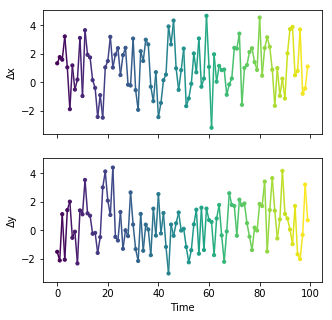

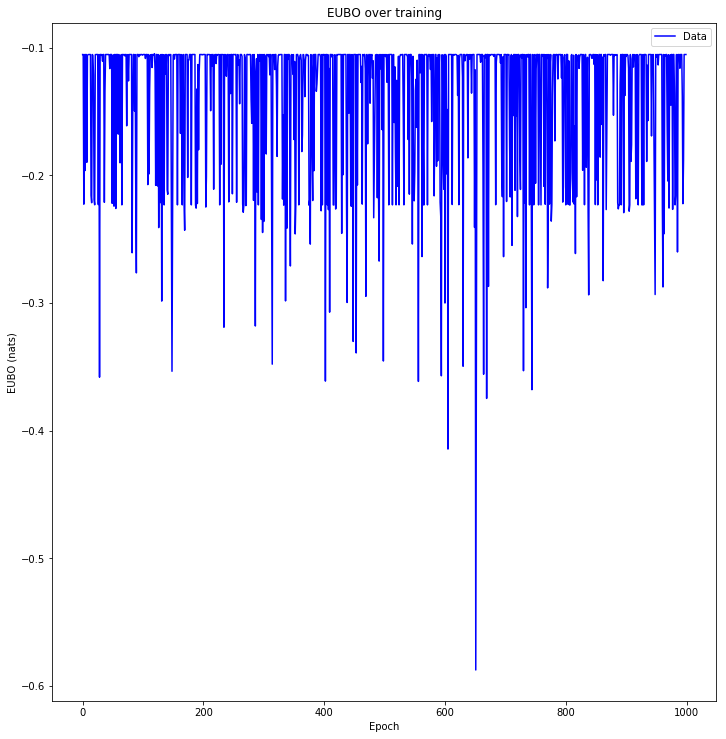

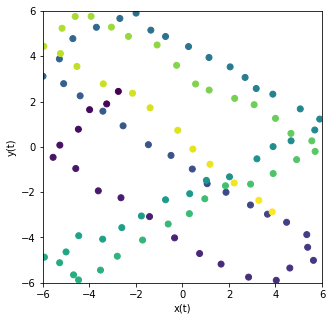

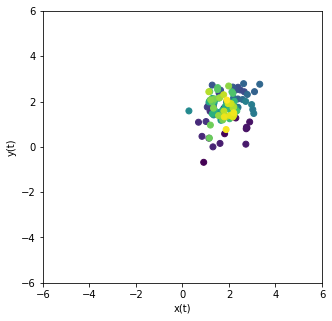

03/01/2019 14:53:32 MSE at time 0: tensor(23.2768)
03/01/2019 14:53:32 MSE at time 1: tensor(27.4720)
03/01/2019 14:53:32 MSE at time 2: tensor(46.4658)
03/01/2019 14:53:32 MSE at time 3: tensor(46.0980)
03/01/2019 14:53:32 MSE at time 4: tensor(64.7769)
03/01/2019 14:53:32 MSE at time 5: tensor(73.9303)
03/01/2019 14:53:32 MSE at time 6: tensor(57.1958)
03/01/2019 14:53:32 MSE at time 7: tensor(44.5084)
03/01/2019 14:53:32 MSE at time 8: tensor(23.9015)
03/01/2019 14:53:32 MSE at time 9: tensor(18.5139)
03/01/2019 14:53:32 MSE at time 10: tensor(18.8638)
03/01/2019 14:53:32 MSE at time 11: tensor(26.7757)
03/01/2019 14:53:32 MSE at time 12: tensor(40.1750)
03/01/2019 14:53:32 MSE at time 13: tensor(56.3505)
03/01/2019 14:53:32 MSE at time 14: tensor(62.7521)
03/01/2019 14:53:32 MSE at time 15: tensor(54.8034)
03/01/2019 14:53:32 MSE at time 16: tensor(63.9290)
03/01/2019 14:53:32 MSE at time 17: tensor(55.2222)
03/01/2019 14:53:32 MSE at time 18: tensor(50.0232)
03/01/2019 14:53:32 MS

Epoch   204: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:54:08 EUBO=-1.06415749e-02 at epoch 207
03/01/2019 14:54:09 EUBO=-1.05714798e-02 at epoch 208
03/01/2019 14:54:09 EUBO=-1.88527107e-02 at epoch 209
03/01/2019 14:54:09 EUBO=-1.94654465e-02 at epoch 210
03/01/2019 14:54:09 EUBO=-2.02674866e-02 at epoch 211
03/01/2019 14:54:09 EUBO=-1.00970268e-02 at epoch 212
03/01/2019 14:54:09 EUBO=-2.26387978e-02 at epoch 213
03/01/2019 14:54:10 EUBO=-3.70287895e-02 at epoch 214
03/01/2019 14:54:10 EUBO=-2.86312103e-02 at epoch 215
03/01/2019 14:54:10 EUBO=-1.07555389e-02 at epoch 216
03/01/2019 14:54:10 EUBO=-2.12039948e-02 at epoch 217
03/01/2019 14:54:10 EUBO=-1.98969841e-02 at epoch 218
03/01/2019 14:54:10 EUBO=-1.30047798e-02 at epoch 219
03/01/2019 14:54:11 EUBO=-1.62138939e-02 at epoch 220
03/01/2019 14:54:11 EUBO=-1.01556778e-02 at epoch 221
03/01/2019 14:54:11 EUBO=-2.07118988e-02 at epoch 222
03/01/2019 14:54:11 EUBO=-2.18658447e-02 at epoch 223
03/01/2019 14:54:11 EUBO=-2.59900093e-02 at epoch 224
03/01/2019 14:54:11 EUBO=-1.

Epoch   372: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 14:54:36 EUBO=-1.22356415e-02 at epoch 375
03/01/2019 14:54:36 EUBO=-1.06644630e-02 at epoch 376
03/01/2019 14:54:36 EUBO=-1.98097229e-02 at epoch 377
03/01/2019 14:54:37 EUBO=-1.90134048e-02 at epoch 378
03/01/2019 14:54:37 EUBO=-1.04389191e-02 at epoch 379
03/01/2019 14:54:37 EUBO=-1.19938850e-02 at epoch 380
03/01/2019 14:54:37 EUBO=-2.27441788e-02 at epoch 381
03/01/2019 14:54:37 EUBO=-1.04980469e-02 at epoch 382
03/01/2019 14:54:38 EUBO=-2.37627029e-02 at epoch 383
03/01/2019 14:54:38 EUBO=-1.00569725e-02 at epoch 384
03/01/2019 14:54:38 EUBO=-1.90072060e-02 at epoch 385
03/01/2019 14:54:38 EUBO=-4.69884872e-02 at epoch 386
03/01/2019 14:54:38 EUBO=-3.23824883e-02 at epoch 387
03/01/2019 14:54:38 EUBO=-4.36973572e-02 at epoch 388
03/01/2019 14:54:39 EUBO=-1.07612610e-02 at epoch 389
03/01/2019 14:54:39 EUBO=-1.53088570e-02 at epoch 390
03/01/2019 14:54:39 EUBO=-2.02250481e-02 at epoch 391
03/01/2019 14:54:39 EUBO=-1.00502968e-02 at epoch 392
03/01/2019 14:54:39 EUBO=-1.

Epoch   565: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 14:55:09 EUBO=-2.32191086e-02 at epoch 568
03/01/2019 14:55:09 EUBO=-1.00507736e-02 at epoch 569
03/01/2019 14:55:09 EUBO=-3.45888138e-02 at epoch 570
03/01/2019 14:55:09 EUBO=-1.02939606e-02 at epoch 571
03/01/2019 14:55:10 EUBO=-1.00536346e-02 at epoch 572
03/01/2019 14:55:10 EUBO=-1.00512505e-02 at epoch 573
03/01/2019 14:55:10 EUBO=-1.00507736e-02 at epoch 574
03/01/2019 14:55:10 EUBO=-3.57346535e-02 at epoch 575
03/01/2019 14:55:10 EUBO=-1.78251266e-02 at epoch 576
03/01/2019 14:55:10 EUBO=-1.08489990e-02 at epoch 577
03/01/2019 14:55:11 EUBO=-3.06568146e-02 at epoch 578
03/01/2019 14:55:11 EUBO=-1.89247131e-02 at epoch 579
03/01/2019 14:55:11 EUBO=-1.54571533e-02 at epoch 580
03/01/2019 14:55:11 EUBO=-1.00622177e-02 at epoch 581
03/01/2019 14:55:11 EUBO=-1.20482445e-02 at epoch 582
03/01/2019 14:55:11 EUBO=-2.30116844e-02 at epoch 583
03/01/2019 14:55:12 EUBO=-1.83434486e-02 at epoch 584
03/01/2019 14:55:12 EUBO=-2.03275681e-02 at epoch 585
03/01/2019 14:55:12 EUBO=-2.

Epoch   666: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 14:55:26 EUBO=-4.42581177e-02 at epoch 669
03/01/2019 14:55:26 EUBO=-1.20110512e-02 at epoch 670
03/01/2019 14:55:26 EUBO=-1.00889206e-02 at epoch 671
03/01/2019 14:55:27 EUBO=-1.10487938e-02 at epoch 672
03/01/2019 14:55:27 EUBO=-2.34861374e-02 at epoch 673
03/01/2019 14:55:27 EUBO=-1.10321045e-02 at epoch 674
03/01/2019 14:55:27 EUBO=-2.09364891e-02 at epoch 675
03/01/2019 14:55:27 EUBO=-3.16162109e-02 at epoch 676
03/01/2019 14:55:28 EUBO=-1.20429993e-02 at epoch 677
03/01/2019 14:55:28 EUBO=-1.34444237e-02 at epoch 678
03/01/2019 14:55:28 EUBO=-1.00507736e-02 at epoch 679
03/01/2019 14:55:28 EUBO=-6.00194931e-02 at epoch 680
03/01/2019 14:55:28 EUBO=-1.01876259e-02 at epoch 681
03/01/2019 14:55:28 EUBO=-1.00889206e-02 at epoch 682
03/01/2019 14:55:29 EUBO=-1.00507736e-02 at epoch 683
03/01/2019 14:55:29 EUBO=-1.03330612e-02 at epoch 684
03/01/2019 14:55:29 EUBO=-3.51519585e-02 at epoch 685
03/01/2019 14:55:29 EUBO=-1.99151039e-02 at epoch 686
03/01/2019 14:55:29 EUBO=-1.

Epoch   767: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 14:55:44 EUBO=-2.82177925e-02 at epoch 770
03/01/2019 14:55:44 EUBO=-2.31475830e-02 at epoch 771
03/01/2019 14:55:44 EUBO=-2.65722275e-02 at epoch 772
03/01/2019 14:55:45 EUBO=-1.00932121e-02 at epoch 773
03/01/2019 14:55:45 EUBO=-1.37190819e-02 at epoch 774
03/01/2019 14:55:45 EUBO=-1.74484253e-02 at epoch 775
03/01/2019 14:55:45 EUBO=-2.26421356e-02 at epoch 776
03/01/2019 14:55:45 EUBO=-2.23813057e-02 at epoch 777
03/01/2019 14:55:45 EUBO=-1.14593506e-02 at epoch 778
03/01/2019 14:55:46 EUBO=-1.59330368e-02 at epoch 779
03/01/2019 14:55:46 EUBO=-2.05421448e-02 at epoch 780
03/01/2019 14:55:46 EUBO=-1.01032257e-02 at epoch 781
03/01/2019 14:55:46 EUBO=-1.00536346e-02 at epoch 782
03/01/2019 14:55:46 EUBO=-1.78284645e-02 at epoch 783
03/01/2019 14:55:47 EUBO=-2.82893181e-02 at epoch 784
03/01/2019 14:55:47 EUBO=-1.02782249e-02 at epoch 785
03/01/2019 14:55:47 EUBO=-2.84709930e-02 at epoch 786
03/01/2019 14:55:47 EUBO=-1.64294243e-02 at epoch 787
03/01/2019 14:55:47 EUBO=-1.

Epoch   868: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 14:56:01 EUBO=-1.76215172e-02 at epoch 871
03/01/2019 14:56:02 EUBO=-3.38811874e-02 at epoch 872
03/01/2019 14:56:02 EUBO=-1.81622505e-02 at epoch 873
03/01/2019 14:56:02 EUBO=-1.08680725e-02 at epoch 874
03/01/2019 14:56:02 EUBO=-4.97617722e-02 at epoch 875
03/01/2019 14:56:02 EUBO=-1.02448463e-02 at epoch 876
03/01/2019 14:56:02 EUBO=-4.38714027e-02 at epoch 877
03/01/2019 14:56:03 EUBO=-2.29115486e-02 at epoch 878
03/01/2019 14:56:03 EUBO=-1.35107040e-02 at epoch 879
03/01/2019 14:56:03 EUBO=-1.21769905e-02 at epoch 880
03/01/2019 14:56:03 EUBO=-3.14307213e-02 at epoch 881
03/01/2019 14:56:03 EUBO=-3.42864990e-02 at epoch 882
03/01/2019 14:56:03 EUBO=-2.05693245e-02 at epoch 883
03/01/2019 14:56:03 EUBO=-1.07617378e-02 at epoch 884
03/01/2019 14:56:04 EUBO=-1.00774765e-02 at epoch 885
03/01/2019 14:56:04 EUBO=-1.06697083e-02 at epoch 886
03/01/2019 14:56:04 EUBO=-1.43909454e-02 at epoch 887
03/01/2019 14:56:04 EUBO=-1.27630234e-02 at epoch 888
03/01/2019 14:56:04 EUBO=-1.

Epoch   969: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 14:56:19 EUBO=-1.00898743e-02 at epoch 972
03/01/2019 14:56:19 EUBO=-3.15909386e-02 at epoch 973
03/01/2019 14:56:20 EUBO=-1.90463066e-02 at epoch 974
03/01/2019 14:56:20 EUBO=-4.84538078e-02 at epoch 975
03/01/2019 14:56:20 EUBO=-1.00679398e-02 at epoch 976
03/01/2019 14:56:20 EUBO=-3.07483673e-02 at epoch 977
03/01/2019 14:56:20 EUBO=-1.00760460e-02 at epoch 978
03/01/2019 14:56:20 EUBO=-1.04017258e-02 at epoch 979
03/01/2019 14:56:21 EUBO=-1.03211403e-02 at epoch 980
03/01/2019 14:56:21 EUBO=-1.03030205e-02 at epoch 981
03/01/2019 14:56:21 EUBO=-1.48930550e-02 at epoch 982
03/01/2019 14:56:21 EUBO=-1.16114616e-02 at epoch 983
03/01/2019 14:56:21 EUBO=-1.84531212e-02 at epoch 984
03/01/2019 14:56:22 EUBO=-4.15692329e-02 at epoch 985
03/01/2019 14:56:22 EUBO=-2.14247704e-02 at epoch 986
03/01/2019 14:56:22 EUBO=-2.64182091e-02 at epoch 987
03/01/2019 14:56:22 EUBO=-1.02548599e-02 at epoch 988
03/01/2019 14:56:22 EUBO=-3.50689888e-02 at epoch 989
03/01/2019 14:56:23 EUBO=-2.

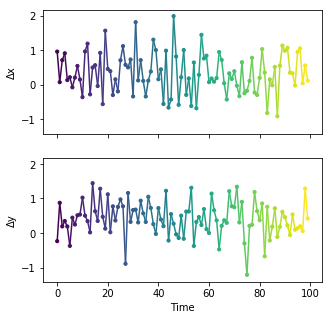

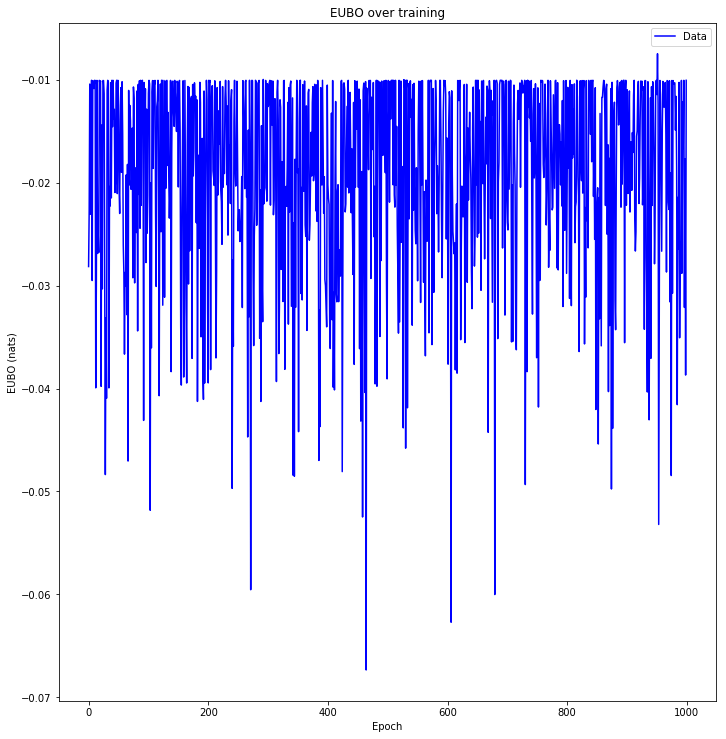

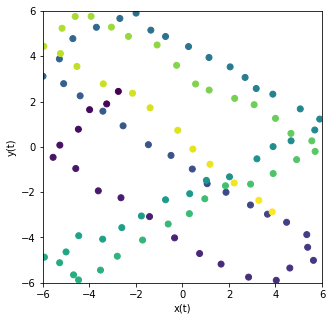

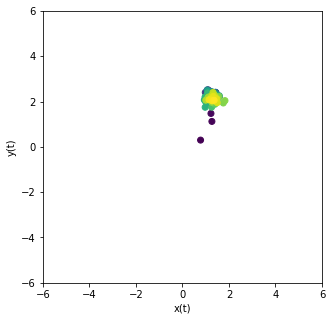

03/01/2019 14:56:25 MSE at time 0: tensor(17.1303)
03/01/2019 14:56:25 MSE at time 1: tensor(21.0791)
03/01/2019 14:56:25 MSE at time 2: tensor(27.2735)
03/01/2019 14:56:25 MSE at time 3: tensor(33.4589)
03/01/2019 14:56:25 MSE at time 4: tensor(45.8052)
03/01/2019 14:56:25 MSE at time 5: tensor(53.1508)
03/01/2019 14:56:25 MSE at time 6: tensor(41.0731)
03/01/2019 14:56:25 MSE at time 7: tensor(40.0786)
03/01/2019 14:56:25 MSE at time 8: tensor(34.2230)
03/01/2019 14:56:25 MSE at time 9: tensor(35.2850)
03/01/2019 14:56:25 MSE at time 10: tensor(40.9875)
03/01/2019 14:56:25 MSE at time 11: tensor(49.0273)
03/01/2019 14:56:25 MSE at time 12: tensor(55.6851)
03/01/2019 14:56:25 MSE at time 13: tensor(68.9506)
03/01/2019 14:56:25 MSE at time 14: tensor(75.7805)
03/01/2019 14:56:25 MSE at time 15: tensor(70.8802)
03/01/2019 14:56:25 MSE at time 16: tensor(75.1081)
03/01/2019 14:56:25 MSE at time 17: tensor(66.7706)
03/01/2019 14:56:25 MSE at time 18: tensor(58.4628)
03/01/2019 14:56:25 MS

Epoch   121: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 14:59:20 ELBO=-2.51936081e+02 at epoch 123
03/01/2019 14:59:21 ELBO=-3.61926392e+02 at epoch 124
03/01/2019 14:59:23 ELBO=-1.77196660e+04 at epoch 125
03/01/2019 14:59:24 ELBO=-2.07840775e+02 at epoch 126
03/01/2019 14:59:25 ELBO=-2.38991675e+03 at epoch 127
03/01/2019 14:59:27 ELBO=-3.84639008e+02 at epoch 128
03/01/2019 14:59:28 ELBO=-5.88059937e+02 at epoch 129
03/01/2019 14:59:30 ELBO=-1.64906758e+04 at epoch 130
03/01/2019 14:59:31 ELBO=-7.49595154e+02 at epoch 131
03/01/2019 14:59:32 ELBO=-4.17652802e+02 at epoch 132
03/01/2019 14:59:34 ELBO=-3.18694824e+02 at epoch 133
03/01/2019 14:59:35 ELBO=-3.01148773e+02 at epoch 134
03/01/2019 14:59:36 ELBO=-2.86168488e+02 at epoch 135
03/01/2019 14:59:38 ELBO=-5.86920508e+03 at epoch 136
03/01/2019 14:59:39 ELBO=-2.84249512e+02 at epoch 137
03/01/2019 14:59:41 ELBO=-3.51940857e+02 at epoch 138
03/01/2019 14:59:42 ELBO=-1.40195740e+03 at epoch 139
03/01/2019 14:59:43 ELBO=-4.16174286e+02 at epoch 140
03/01/2019 14:59:45 ELBO=-3.

Epoch   222: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 15:01:40 ELBO=-2.71695862e+02 at epoch 224
03/01/2019 15:01:41 ELBO=-3.66788696e+02 at epoch 225
03/01/2019 15:01:42 ELBO=-3.33862579e+02 at epoch 226
03/01/2019 15:01:44 ELBO=-2.72876099e+02 at epoch 227
03/01/2019 15:01:45 ELBO=-3.40437469e+02 at epoch 228
03/01/2019 15:01:46 ELBO=-6.65255127e+02 at epoch 229
03/01/2019 15:01:48 ELBO=-2.92157501e+02 at epoch 230
03/01/2019 15:01:49 ELBO=-2.33628937e+02 at epoch 231
03/01/2019 15:01:50 ELBO=-3.03441681e+02 at epoch 232
03/01/2019 15:01:52 ELBO=-1.50492188e+03 at epoch 233
03/01/2019 15:01:53 ELBO=-2.65017853e+02 at epoch 234
03/01/2019 15:01:54 ELBO=-3.57983643e+02 at epoch 235
03/01/2019 15:01:56 ELBO=-2.01318192e+02 at epoch 236
03/01/2019 15:01:57 ELBO=-3.74603760e+02 at epoch 237
03/01/2019 15:01:58 ELBO=-3.25108917e+02 at epoch 238
03/01/2019 15:02:00 ELBO=-2.26578445e+02 at epoch 239
03/01/2019 15:02:01 ELBO=-3.07384460e+02 at epoch 240
03/01/2019 15:02:02 ELBO=-5.34671448e+02 at epoch 241
03/01/2019 15:02:04 ELBO=-3.

Epoch   323: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 15:03:55 ELBO=-2.60232147e+02 at epoch 325
03/01/2019 15:03:56 ELBO=-2.56887878e+02 at epoch 326
03/01/2019 15:03:57 ELBO=-3.30136597e+02 at epoch 327
03/01/2019 15:03:59 ELBO=-4.57580231e+02 at epoch 328
03/01/2019 15:04:00 ELBO=-4.77610748e+02 at epoch 329
03/01/2019 15:04:01 ELBO=-3.94726288e+02 at epoch 330
03/01/2019 15:04:03 ELBO=-5.48224487e+02 at epoch 331
03/01/2019 15:04:04 ELBO=-1.90110580e+02 at epoch 332
03/01/2019 15:04:05 ELBO=-3.60529327e+02 at epoch 333
03/01/2019 15:04:07 ELBO=-5.41911377e+02 at epoch 334
03/01/2019 15:04:08 ELBO=-3.87516357e+02 at epoch 335
03/01/2019 15:04:09 ELBO=-3.19432587e+02 at epoch 336
03/01/2019 15:04:11 ELBO=-2.86124634e+02 at epoch 337
03/01/2019 15:04:12 ELBO=-3.08126190e+02 at epoch 338
03/01/2019 15:04:13 ELBO=-2.47668777e+02 at epoch 339
03/01/2019 15:04:15 ELBO=-3.56323120e+02 at epoch 340
03/01/2019 15:04:16 ELBO=-2.93656952e+02 at epoch 341
03/01/2019 15:04:17 ELBO=-2.47642380e+02 at epoch 342
03/01/2019 15:04:19 ELBO=-3.

Epoch   424: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 15:06:12 ELBO=-2.89269226e+02 at epoch 426
03/01/2019 15:06:13 ELBO=-2.45423111e+02 at epoch 427
03/01/2019 15:06:14 ELBO=-3.79986725e+02 at epoch 428
03/01/2019 15:06:16 ELBO=-2.16694214e+02 at epoch 429
03/01/2019 15:06:17 ELBO=-2.21841614e+02 at epoch 430
03/01/2019 15:06:18 ELBO=-3.44594818e+02 at epoch 431
03/01/2019 15:06:20 ELBO=-2.12720474e+02 at epoch 432
03/01/2019 15:06:21 ELBO=-1.07797009e+03 at epoch 433
03/01/2019 15:06:22 ELBO=-2.40377441e+02 at epoch 434
03/01/2019 15:06:24 ELBO=-3.56310089e+02 at epoch 435
03/01/2019 15:06:25 ELBO=-2.80859467e+02 at epoch 436
03/01/2019 15:06:27 ELBO=-4.66465607e+02 at epoch 437
03/01/2019 15:06:28 ELBO=-2.23264160e+02 at epoch 438
03/01/2019 15:06:29 ELBO=-2.69385162e+02 at epoch 439
03/01/2019 15:06:31 ELBO=-2.32945450e+02 at epoch 440
03/01/2019 15:06:32 ELBO=-2.54406036e+02 at epoch 441
03/01/2019 15:06:34 ELBO=-4.49003571e+02 at epoch 442
03/01/2019 15:06:35 ELBO=-2.87193176e+02 at epoch 443
03/01/2019 15:06:36 ELBO=-2.

Epoch   525: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 15:08:30 ELBO=-2.60101898e+02 at epoch 527
03/01/2019 15:08:31 ELBO=-2.44357452e+02 at epoch 528
03/01/2019 15:08:32 ELBO=-7.89485474e+02 at epoch 529
03/01/2019 15:08:34 ELBO=-3.17825562e+02 at epoch 530
03/01/2019 15:08:35 ELBO=-4.43673004e+02 at epoch 531
03/01/2019 15:08:37 ELBO=-2.18853271e+03 at epoch 532
03/01/2019 15:08:38 ELBO=-2.25682739e+02 at epoch 533
03/01/2019 15:08:39 ELBO=-2.16259521e+02 at epoch 534
03/01/2019 15:08:41 ELBO=-3.55257721e+02 at epoch 535
03/01/2019 15:08:42 ELBO=-2.62932465e+02 at epoch 536
03/01/2019 15:08:43 ELBO=-2.96595947e+02 at epoch 537
03/01/2019 15:08:45 ELBO=-3.39918579e+02 at epoch 538
03/01/2019 15:08:46 ELBO=-4.20249207e+02 at epoch 539
03/01/2019 15:08:47 ELBO=-4.18611816e+03 at epoch 540
03/01/2019 15:08:49 ELBO=-5.78396484e+02 at epoch 541
03/01/2019 15:08:50 ELBO=-1.07900928e+03 at epoch 542
03/01/2019 15:08:52 ELBO=-1.08459265e+03 at epoch 543
03/01/2019 15:08:53 ELBO=-2.96035706e+02 at epoch 544
03/01/2019 15:08:54 ELBO=-3.

Epoch   674: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 15:11:55 ELBO=-2.37805450e+02 at epoch 676
03/01/2019 15:11:57 ELBO=-2.05983368e+02 at epoch 677
03/01/2019 15:11:58 ELBO=-3.25553345e+02 at epoch 678
03/01/2019 15:11:59 ELBO=-2.94146332e+02 at epoch 679
03/01/2019 15:12:01 ELBO=-2.21186172e+02 at epoch 680
03/01/2019 15:12:02 ELBO=-2.22579803e+02 at epoch 681
03/01/2019 15:12:04 ELBO=-2.22536011e+02 at epoch 682
03/01/2019 15:12:05 ELBO=-3.42802155e+02 at epoch 683
03/01/2019 15:12:07 ELBO=-2.37917526e+02 at epoch 684
03/01/2019 15:12:08 ELBO=-2.41068024e+02 at epoch 685
03/01/2019 15:12:09 ELBO=-9.58372986e+02 at epoch 686
03/01/2019 15:12:11 ELBO=-2.80766113e+02 at epoch 687
03/01/2019 15:12:12 ELBO=-3.09155823e+02 at epoch 688
03/01/2019 15:12:14 ELBO=-2.79424683e+02 at epoch 689
03/01/2019 15:12:15 ELBO=-4.67126270e+03 at epoch 690
03/01/2019 15:12:17 ELBO=-8.11729736e+02 at epoch 691
03/01/2019 15:12:18 ELBO=-2.52234528e+02 at epoch 692
03/01/2019 15:12:20 ELBO=-2.02907257e+02 at epoch 693
03/01/2019 15:12:21 ELBO=-2.

Epoch   775: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 15:14:22 ELBO=-3.98286987e+02 at epoch 777
03/01/2019 15:14:24 ELBO=-4.53788025e+02 at epoch 778
03/01/2019 15:14:25 ELBO=-4.46130676e+02 at epoch 779
03/01/2019 15:14:27 ELBO=-3.80025146e+02 at epoch 780
03/01/2019 15:14:29 ELBO=-5.86948730e+02 at epoch 781
03/01/2019 15:14:30 ELBO=-3.59837524e+02 at epoch 782
03/01/2019 15:14:32 ELBO=-1.97489716e+02 at epoch 783
03/01/2019 15:14:33 ELBO=-3.31276367e+02 at epoch 784
03/01/2019 15:14:34 ELBO=-2.62445312e+02 at epoch 785
03/01/2019 15:14:36 ELBO=-2.65660400e+02 at epoch 786
03/01/2019 15:14:37 ELBO=-2.94725067e+02 at epoch 787
03/01/2019 15:14:39 ELBO=-4.51498352e+02 at epoch 788
03/01/2019 15:14:40 ELBO=-2.27080490e+02 at epoch 789
03/01/2019 15:14:42 ELBO=-2.98628754e+02 at epoch 790
03/01/2019 15:14:43 ELBO=-2.46023499e+02 at epoch 791
03/01/2019 15:14:45 ELBO=-2.52845001e+02 at epoch 792
03/01/2019 15:14:46 ELBO=-2.48186630e+02 at epoch 793
03/01/2019 15:14:48 ELBO=-2.89106140e+02 at epoch 794
03/01/2019 15:14:49 ELBO=-3.

Epoch   876: reducing learning rate of group 0 to 3.9063e-04.


03/01/2019 15:16:54 ELBO=-2.25544998e+02 at epoch 878
03/01/2019 15:16:56 ELBO=-1.06296301e+03 at epoch 879
03/01/2019 15:16:57 ELBO=-1.92236206e+02 at epoch 880
03/01/2019 15:16:59 ELBO=-3.35810669e+02 at epoch 881
03/01/2019 15:17:00 ELBO=-5.41901672e+02 at epoch 882
03/01/2019 15:17:02 ELBO=-2.26165009e+02 at epoch 883
03/01/2019 15:17:03 ELBO=-2.11261581e+02 at epoch 884
03/01/2019 15:17:05 ELBO=-5.17594604e+02 at epoch 885
03/01/2019 15:17:06 ELBO=-2.05522964e+02 at epoch 886
03/01/2019 15:17:08 ELBO=-2.10075256e+02 at epoch 887
03/01/2019 15:17:09 ELBO=-2.40665070e+02 at epoch 888
03/01/2019 15:17:10 ELBO=-2.59326752e+02 at epoch 889
03/01/2019 15:17:12 ELBO=-3.82565460e+02 at epoch 890
03/01/2019 15:17:13 ELBO=-6.60963013e+02 at epoch 891
03/01/2019 15:17:15 ELBO=-6.28222412e+02 at epoch 892
03/01/2019 15:17:16 ELBO=-4.00121582e+02 at epoch 893
03/01/2019 15:17:18 ELBO=-2.16587921e+02 at epoch 894
03/01/2019 15:17:19 ELBO=-8.53489380e+02 at epoch 895
03/01/2019 15:17:21 ELBO=-3.

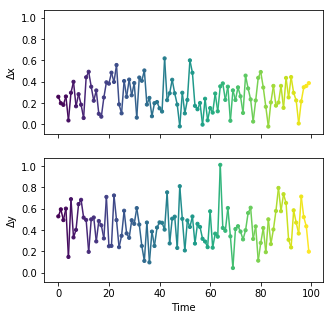

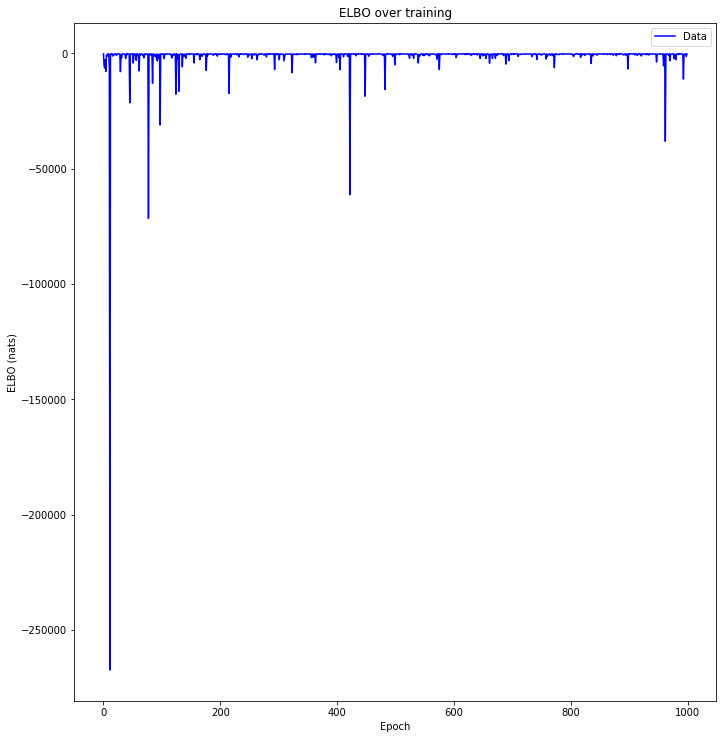

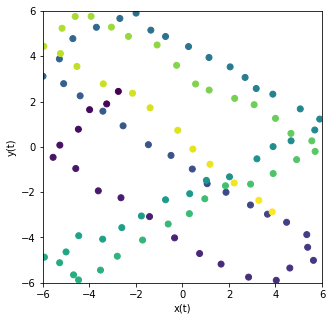

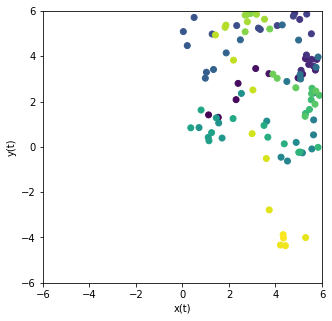

03/01/2019 15:20:20 MSE at time 0: tensor(16.1320)
03/01/2019 15:20:20 MSE at time 1: tensor(23.3915)
03/01/2019 15:20:20 MSE at time 2: tensor(39.8925)
03/01/2019 15:20:20 MSE at time 3: tensor(51.2745)
03/01/2019 15:20:20 MSE at time 4: tensor(82.3987)
03/01/2019 15:20:20 MSE at time 5: tensor(99.8066)
03/01/2019 15:20:20 MSE at time 6: tensor(107.3759)
03/01/2019 15:20:20 MSE at time 7: tensor(103.7415)
03/01/2019 15:20:20 MSE at time 8: tensor(101.7063)
03/01/2019 15:20:20 MSE at time 9: tensor(93.6278)
03/01/2019 15:20:20 MSE at time 10: tensor(99.5206)
03/01/2019 15:20:20 MSE at time 11: tensor(91.7232)
03/01/2019 15:20:20 MSE at time 12: tensor(96.8553)
03/01/2019 15:20:20 MSE at time 13: tensor(94.6553)
03/01/2019 15:20:20 MSE at time 14: tensor(87.0959)
03/01/2019 15:20:20 MSE at time 15: tensor(88.9676)
03/01/2019 15:20:20 MSE at time 16: tensor(113.4881)
03/01/2019 15:20:20 MSE at time 17: tensor(107.1585)
03/01/2019 15:20:20 MSE at time 18: tensor(78.6332)
03/01/2019 15:20:

Epoch   118: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 15:23:28 ELBO=-3.28587036e+03 at epoch 120
03/01/2019 15:23:30 ELBO=-2.90377661e+03 at epoch 121
03/01/2019 15:23:31 ELBO=-9.11612366e+02 at epoch 122
03/01/2019 15:23:33 ELBO=-6.00219177e+02 at epoch 123
03/01/2019 15:23:34 ELBO=-1.48205798e+03 at epoch 124
03/01/2019 15:23:36 ELBO=-1.21067151e+03 at epoch 125
03/01/2019 15:23:37 ELBO=-8.13692627e+02 at epoch 126
03/01/2019 15:23:39 ELBO=-8.15931458e+02 at epoch 127
03/01/2019 15:23:40 ELBO=-9.75496887e+02 at epoch 128
03/01/2019 15:23:42 ELBO=-7.78670166e+02 at epoch 129
03/01/2019 15:23:43 ELBO=-6.14989807e+02 at epoch 130
03/01/2019 15:23:45 ELBO=-7.54392395e+02 at epoch 131
03/01/2019 15:23:46 ELBO=-1.06406104e+03 at epoch 132
03/01/2019 15:23:48 ELBO=-2.42039453e+03 at epoch 133
03/01/2019 15:23:49 ELBO=-1.23224841e+03 at epoch 134
03/01/2019 15:23:51 ELBO=-3.59569507e+03 at epoch 135
03/01/2019 15:23:52 ELBO=-1.00799341e+03 at epoch 136
03/01/2019 15:23:54 ELBO=-3.18801978e+03 at epoch 137
03/01/2019 15:23:55 ELBO=-7.

Epoch   219: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 15:26:00 ELBO=-6.12249451e+02 at epoch 221
03/01/2019 15:26:02 ELBO=-2.60772339e+03 at epoch 222
03/01/2019 15:26:03 ELBO=-5.88271973e+02 at epoch 223
03/01/2019 15:26:05 ELBO=-1.17413135e+03 at epoch 224
03/01/2019 15:26:06 ELBO=-1.54606506e+03 at epoch 225
03/01/2019 15:26:08 ELBO=-1.97500244e+03 at epoch 226
03/01/2019 15:26:09 ELBO=-2.78775269e+03 at epoch 227
03/01/2019 15:26:11 ELBO=-7.26028503e+02 at epoch 228
03/01/2019 15:26:12 ELBO=-1.33379858e+03 at epoch 229
03/01/2019 15:26:13 ELBO=-3.00243701e+03 at epoch 230
03/01/2019 15:26:15 ELBO=-3.70282788e+03 at epoch 231
03/01/2019 15:26:16 ELBO=-1.09481702e+03 at epoch 232
03/01/2019 15:26:18 ELBO=-2.38672632e+03 at epoch 233
03/01/2019 15:26:19 ELBO=-8.05928040e+02 at epoch 234
03/01/2019 15:26:21 ELBO=-7.95731152e+03 at epoch 235
03/01/2019 15:26:22 ELBO=-1.05719150e+04 at epoch 236
03/01/2019 15:26:24 ELBO=-2.05952075e+03 at epoch 237
03/01/2019 15:26:25 ELBO=-3.54493799e+03 at epoch 238
03/01/2019 15:26:27 ELBO=-8.

Epoch   320: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 15:28:27 ELBO=-5.15416846e+03 at epoch 322
03/01/2019 15:28:29 ELBO=-1.10502917e+03 at epoch 323
03/01/2019 15:28:30 ELBO=-7.33125854e+02 at epoch 324
03/01/2019 15:28:32 ELBO=-1.13122925e+03 at epoch 325
03/01/2019 15:28:33 ELBO=-4.54056934e+03 at epoch 326
03/01/2019 15:28:35 ELBO=-7.61787903e+02 at epoch 327
03/01/2019 15:28:36 ELBO=-1.64344666e+03 at epoch 328
03/01/2019 15:28:38 ELBO=-1.82957556e+03 at epoch 329
03/01/2019 15:28:39 ELBO=-8.54010742e+02 at epoch 330
03/01/2019 15:28:41 ELBO=-7.90883484e+02 at epoch 331
03/01/2019 15:28:42 ELBO=-2.98610913e+03 at epoch 332
03/01/2019 15:28:44 ELBO=-5.05479584e+02 at epoch 333
03/01/2019 15:28:45 ELBO=-5.03526947e+02 at epoch 334
03/01/2019 15:28:47 ELBO=-1.08902100e+03 at epoch 335
03/01/2019 15:28:48 ELBO=-1.84356714e+03 at epoch 336
03/01/2019 15:28:50 ELBO=-1.08301355e+03 at epoch 337
03/01/2019 15:28:51 ELBO=-6.48124817e+02 at epoch 338
03/01/2019 15:28:53 ELBO=-9.26973450e+02 at epoch 339
03/01/2019 15:28:54 ELBO=-6.

Epoch   537: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 15:33:50 ELBO=-6.90241760e+02 at epoch 539
03/01/2019 15:33:52 ELBO=-1.44694641e+03 at epoch 540
03/01/2019 15:33:53 ELBO=-2.35204102e+03 at epoch 541
03/01/2019 15:33:55 ELBO=-8.55537305e+03 at epoch 542
03/01/2019 15:33:56 ELBO=-6.43694824e+02 at epoch 543
03/01/2019 15:33:58 ELBO=-1.10478394e+03 at epoch 544
03/01/2019 15:33:59 ELBO=-2.16499961e+04 at epoch 545
03/01/2019 15:34:01 ELBO=-4.16712354e+03 at epoch 546
03/01/2019 15:34:02 ELBO=-9.63110474e+02 at epoch 547
03/01/2019 15:34:04 ELBO=-3.38043042e+03 at epoch 548
03/01/2019 15:34:05 ELBO=-7.19618530e+02 at epoch 549
03/01/2019 15:34:07 ELBO=-1.15119470e+03 at epoch 550
03/01/2019 15:34:08 ELBO=-8.46777527e+02 at epoch 551
03/01/2019 15:34:10 ELBO=-1.83050146e+03 at epoch 552
03/01/2019 15:34:11 ELBO=-1.05819543e+03 at epoch 553
03/01/2019 15:34:13 ELBO=-1.01205023e+03 at epoch 554
03/01/2019 15:34:14 ELBO=-1.19065881e+03 at epoch 555
03/01/2019 15:34:16 ELBO=-2.16455322e+03 at epoch 556
03/01/2019 15:34:17 ELBO=-1.

Epoch   638: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 15:36:19 ELBO=-3.32570239e+03 at epoch 640
03/01/2019 15:36:20 ELBO=-4.09311792e+03 at epoch 641
03/01/2019 15:36:22 ELBO=-1.24875598e+03 at epoch 642
03/01/2019 15:36:23 ELBO=-1.94481824e+03 at epoch 643
03/01/2019 15:36:25 ELBO=-1.87028105e+04 at epoch 644
03/01/2019 15:36:26 ELBO=-8.40759094e+02 at epoch 645
03/01/2019 15:36:27 ELBO=-3.79977466e+03 at epoch 646
03/01/2019 15:36:29 ELBO=-5.51299121e+03 at epoch 647
03/01/2019 15:36:30 ELBO=-1.42379272e+03 at epoch 648
03/01/2019 15:36:32 ELBO=-1.58669421e+03 at epoch 649
03/01/2019 15:36:33 ELBO=-1.16178967e+03 at epoch 650
03/01/2019 15:36:35 ELBO=-2.22104126e+03 at epoch 651
03/01/2019 15:36:36 ELBO=-3.00105615e+03 at epoch 652
03/01/2019 15:36:38 ELBO=-7.25897949e+02 at epoch 653
03/01/2019 15:36:39 ELBO=-1.16853955e+03 at epoch 654
03/01/2019 15:36:41 ELBO=-1.22922937e+03 at epoch 655
03/01/2019 15:36:42 ELBO=-1.22086877e+03 at epoch 656
03/01/2019 15:36:43 ELBO=-1.38593164e+03 at epoch 657
03/01/2019 15:36:45 ELBO=-9.

Epoch   739: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 15:38:46 ELBO=-9.29999207e+02 at epoch 741
03/01/2019 15:38:47 ELBO=-4.01187573e+03 at epoch 742
03/01/2019 15:38:49 ELBO=-1.45512878e+03 at epoch 743
03/01/2019 15:38:50 ELBO=-1.48443115e+03 at epoch 744
03/01/2019 15:38:52 ELBO=-3.15790918e+03 at epoch 745
03/01/2019 15:38:53 ELBO=-1.17580994e+03 at epoch 746
03/01/2019 15:38:54 ELBO=-5.02019836e+02 at epoch 747
03/01/2019 15:38:56 ELBO=-1.20164966e+03 at epoch 748
03/01/2019 15:38:57 ELBO=-8.47002930e+02 at epoch 749
03/01/2019 15:38:59 ELBO=-5.03875488e+02 at epoch 750
03/01/2019 15:39:00 ELBO=-3.39584229e+03 at epoch 751
03/01/2019 15:39:02 ELBO=-6.52236206e+02 at epoch 752
03/01/2019 15:39:03 ELBO=-6.88294739e+02 at epoch 753
03/01/2019 15:39:05 ELBO=-6.07649414e+02 at epoch 754
03/01/2019 15:39:06 ELBO=-6.80301025e+02 at epoch 755
03/01/2019 15:39:07 ELBO=-1.13542566e+03 at epoch 756
03/01/2019 15:39:09 ELBO=-1.29865344e+03 at epoch 757
03/01/2019 15:39:10 ELBO=-2.83667773e+03 at epoch 758
03/01/2019 15:39:12 ELBO=-1.

Epoch   840: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 15:41:13 ELBO=-9.40834277e+03 at epoch 842
03/01/2019 15:41:14 ELBO=-1.20935693e+03 at epoch 843
03/01/2019 15:41:16 ELBO=-6.19207703e+02 at epoch 844
03/01/2019 15:41:17 ELBO=-1.83615637e+03 at epoch 845
03/01/2019 15:41:19 ELBO=-6.15300049e+02 at epoch 846
03/01/2019 15:41:20 ELBO=-8.11020142e+02 at epoch 847
03/01/2019 15:41:21 ELBO=-2.99714160e+03 at epoch 848
03/01/2019 15:41:23 ELBO=-2.05280200e+03 at epoch 849
03/01/2019 15:41:24 ELBO=-1.64277454e+03 at epoch 850
03/01/2019 15:41:26 ELBO=-1.27174597e+03 at epoch 851
03/01/2019 15:41:27 ELBO=-1.01131885e+04 at epoch 852
03/01/2019 15:41:29 ELBO=-7.94928345e+02 at epoch 853
03/01/2019 15:41:30 ELBO=-1.76534741e+03 at epoch 854
03/01/2019 15:41:32 ELBO=-2.16916748e+03 at epoch 855
03/01/2019 15:41:33 ELBO=-3.34917554e+03 at epoch 856
03/01/2019 15:41:35 ELBO=-1.13903650e+03 at epoch 857
03/01/2019 15:41:36 ELBO=-5.63799951e+03 at epoch 858
03/01/2019 15:41:38 ELBO=-7.50819763e+02 at epoch 859
03/01/2019 15:41:39 ELBO=-2.

Epoch   941: reducing learning rate of group 0 to 3.9063e-04.


03/01/2019 15:43:40 ELBO=-1.42215833e+03 at epoch 943
03/01/2019 15:43:41 ELBO=-7.08994507e+02 at epoch 944
03/01/2019 15:43:43 ELBO=-5.72033569e+02 at epoch 945
03/01/2019 15:43:44 ELBO=-1.00368027e+04 at epoch 946
03/01/2019 15:43:46 ELBO=-6.71445129e+02 at epoch 947
03/01/2019 15:43:47 ELBO=-1.04060537e+04 at epoch 948
03/01/2019 15:43:49 ELBO=-1.86349890e+03 at epoch 949
03/01/2019 15:43:50 ELBO=-1.75014258e+03 at epoch 950
03/01/2019 15:43:52 ELBO=-1.66057214e+03 at epoch 951
03/01/2019 15:43:53 ELBO=-1.86795264e+03 at epoch 952
03/01/2019 15:43:55 ELBO=-1.03371692e+03 at epoch 953
03/01/2019 15:43:56 ELBO=-8.46059448e+02 at epoch 954
03/01/2019 15:43:58 ELBO=-5.32991516e+02 at epoch 955
03/01/2019 15:43:59 ELBO=-1.07851404e+03 at epoch 956
03/01/2019 15:44:01 ELBO=-8.65638794e+02 at epoch 957
03/01/2019 15:44:02 ELBO=-1.09483386e+03 at epoch 958
03/01/2019 15:44:04 ELBO=-4.86683154e+03 at epoch 959
03/01/2019 15:44:06 ELBO=-4.31723486e+03 at epoch 960
03/01/2019 15:44:07 ELBO=-1.

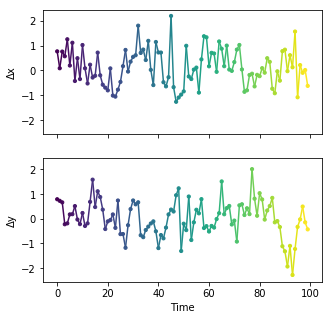

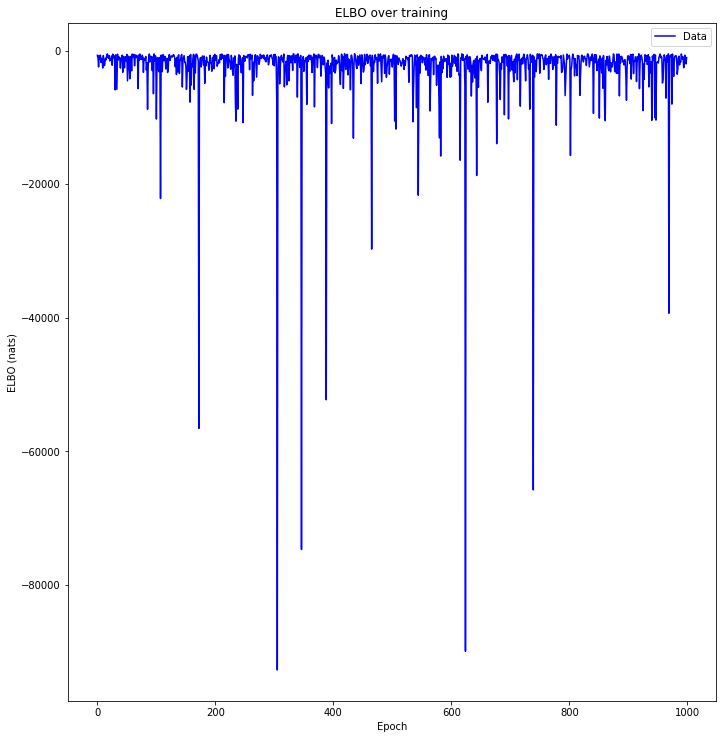

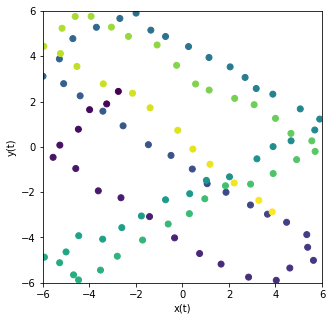

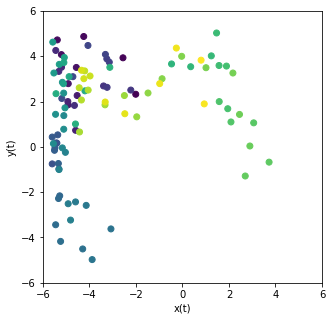

03/01/2019 15:45:07 MSE at time 0: tensor(0.5751)
03/01/2019 15:45:07 MSE at time 1: tensor(4.6350)
03/01/2019 15:45:07 MSE at time 2: tensor(10.5005)
03/01/2019 15:45:07 MSE at time 3: tensor(16.3702)
03/01/2019 15:45:07 MSE at time 4: tensor(15.9861)
03/01/2019 15:45:07 MSE at time 5: tensor(16.7419)
03/01/2019 15:45:07 MSE at time 6: tensor(14.1379)
03/01/2019 15:45:07 MSE at time 7: tensor(16.0940)
03/01/2019 15:45:07 MSE at time 8: tensor(23.9133)
03/01/2019 15:45:07 MSE at time 9: tensor(24.6252)
03/01/2019 15:45:07 MSE at time 10: tensor(57.2924)
03/01/2019 15:45:07 MSE at time 11: tensor(102.8916)
03/01/2019 15:45:07 MSE at time 12: tensor(139.5060)
03/01/2019 15:45:07 MSE at time 13: tensor(149.1267)
03/01/2019 15:45:07 MSE at time 14: tensor(134.9691)
03/01/2019 15:45:07 MSE at time 15: tensor(128.7975)
03/01/2019 15:45:07 MSE at time 16: tensor(118.2274)
03/01/2019 15:45:07 MSE at time 17: tensor(124.2757)
03/01/2019 15:45:07 MSE at time 18: tensor(134.1554)
03/01/2019 15:45

Epoch   224: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 15:51:45 ELBO=-7.89424219e+03 at epoch 226
03/01/2019 15:51:46 ELBO=-3.00871504e+04 at epoch 227
03/01/2019 15:51:48 ELBO=-4.45703564e+03 at epoch 228
03/01/2019 15:51:50 ELBO=-9.14204004e+03 at epoch 229
03/01/2019 15:51:51 ELBO=-1.31598770e+04 at epoch 230
03/01/2019 15:51:53 ELBO=-2.59043091e+03 at epoch 231
03/01/2019 15:51:55 ELBO=-5.55095898e+03 at epoch 232
03/01/2019 15:51:56 ELBO=-2.61627930e+03 at epoch 233
03/01/2019 15:51:58 ELBO=-3.26866455e+03 at epoch 234
03/01/2019 15:51:59 ELBO=-5.22032910e+03 at epoch 235
03/01/2019 15:52:01 ELBO=-2.49328027e+03 at epoch 236
03/01/2019 15:52:03 ELBO=-4.33203174e+03 at epoch 237
03/01/2019 15:52:04 ELBO=-2.14269629e+03 at epoch 238
03/01/2019 15:52:06 ELBO=-9.37411621e+03 at epoch 239
03/01/2019 15:52:08 ELBO=-2.94388281e+03 at epoch 240
03/01/2019 15:52:09 ELBO=-3.86574341e+03 at epoch 241
03/01/2019 15:52:11 ELBO=-4.84571045e+03 at epoch 242
03/01/2019 15:52:13 ELBO=-3.70754565e+03 at epoch 243
03/01/2019 15:52:14 ELBO=-9.

Epoch   325: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 15:54:31 ELBO=-6.33105225e+03 at epoch 327
03/01/2019 15:54:32 ELBO=-7.49517480e+03 at epoch 328
03/01/2019 15:54:34 ELBO=-2.18080664e+04 at epoch 329
03/01/2019 15:54:36 ELBO=-2.06965015e+03 at epoch 330
03/01/2019 15:54:37 ELBO=-7.46315527e+03 at epoch 331
03/01/2019 15:54:39 ELBO=-6.26913818e+03 at epoch 332
03/01/2019 15:54:41 ELBO=-2.55580103e+03 at epoch 333
03/01/2019 15:54:42 ELBO=-4.37706934e+03 at epoch 334
03/01/2019 15:54:44 ELBO=-5.20151074e+03 at epoch 335
03/01/2019 15:54:46 ELBO=-2.76823218e+03 at epoch 336
03/01/2019 15:54:47 ELBO=-1.15044102e+04 at epoch 337
03/01/2019 15:54:49 ELBO=-6.31887939e+03 at epoch 338
03/01/2019 15:54:50 ELBO=-8.11691357e+03 at epoch 339
03/01/2019 15:54:52 ELBO=-3.82279102e+04 at epoch 340
03/01/2019 15:54:54 ELBO=-4.65957373e+03 at epoch 341
03/01/2019 15:54:55 ELBO=-4.23834912e+03 at epoch 342
03/01/2019 15:54:57 ELBO=-3.92498071e+03 at epoch 343
03/01/2019 15:54:59 ELBO=-3.99455737e+03 at epoch 344
03/01/2019 15:55:00 ELBO=-6.

Epoch   497: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 15:59:35 ELBO=-3.05046265e+03 at epoch 499
03/01/2019 15:59:37 ELBO=-2.31186963e+03 at epoch 500
03/01/2019 15:59:39 ELBO=-3.28012671e+03 at epoch 501
03/01/2019 15:59:40 ELBO=-3.44505396e+03 at epoch 502
03/01/2019 15:59:42 ELBO=-5.74093213e+03 at epoch 503
03/01/2019 15:59:44 ELBO=-8.94991309e+03 at epoch 504
03/01/2019 15:59:46 ELBO=-2.54494727e+03 at epoch 505
03/01/2019 15:59:47 ELBO=-4.18093311e+03 at epoch 506
03/01/2019 15:59:49 ELBO=-7.55088086e+03 at epoch 507
03/01/2019 15:59:51 ELBO=-2.70514258e+04 at epoch 508
03/01/2019 15:59:53 ELBO=-5.59726270e+03 at epoch 509
03/01/2019 15:59:54 ELBO=-2.30346460e+03 at epoch 510
03/01/2019 15:59:56 ELBO=-3.94457617e+03 at epoch 511
03/01/2019 15:59:58 ELBO=-1.13859014e+04 at epoch 512
03/01/2019 16:00:00 ELBO=-2.12916333e+03 at epoch 513
03/01/2019 16:00:02 ELBO=-4.96947852e+03 at epoch 514
03/01/2019 16:00:03 ELBO=-6.24124365e+03 at epoch 515
03/01/2019 16:00:05 ELBO=-6.21054639e+03 at epoch 516
03/01/2019 16:00:07 ELBO=-1.

Epoch   617: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 16:03:14 ELBO=-2.97168359e+03 at epoch 619
03/01/2019 16:03:15 ELBO=-8.02220117e+03 at epoch 620
03/01/2019 16:03:17 ELBO=-6.69591260e+03 at epoch 621
03/01/2019 16:03:19 ELBO=-1.73351331e+03 at epoch 622
03/01/2019 16:03:20 ELBO=-4.47047754e+03 at epoch 623
03/01/2019 16:03:22 ELBO=-1.23929385e+04 at epoch 624
03/01/2019 16:03:24 ELBO=-3.54928320e+03 at epoch 625
03/01/2019 16:03:25 ELBO=-3.41558911e+03 at epoch 626
03/01/2019 16:03:27 ELBO=-3.55380566e+03 at epoch 627
03/01/2019 16:03:29 ELBO=-2.44447812e+04 at epoch 628
03/01/2019 16:03:30 ELBO=-1.24670830e+04 at epoch 629
03/01/2019 16:03:32 ELBO=-1.04284893e+04 at epoch 630
03/01/2019 16:03:34 ELBO=-6.56964258e+03 at epoch 631
03/01/2019 16:03:36 ELBO=-5.13029248e+03 at epoch 632
03/01/2019 16:03:37 ELBO=-1.02738535e+04 at epoch 633
03/01/2019 16:03:39 ELBO=-6.06449658e+03 at epoch 634
03/01/2019 16:03:41 ELBO=-4.06663354e+03 at epoch 635
03/01/2019 16:03:43 ELBO=-1.47063096e+04 at epoch 636
03/01/2019 16:03:45 ELBO=-4.

Epoch   718: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 16:06:20 ELBO=-5.37818555e+03 at epoch 720
03/01/2019 16:06:21 ELBO=-7.90029883e+03 at epoch 721
03/01/2019 16:06:23 ELBO=-3.30724097e+03 at epoch 722
03/01/2019 16:06:25 ELBO=-2.45179834e+03 at epoch 723
03/01/2019 16:06:27 ELBO=-3.17749707e+03 at epoch 724
03/01/2019 16:06:29 ELBO=-4.90449170e+03 at epoch 725
03/01/2019 16:06:31 ELBO=-1.08819678e+04 at epoch 726
03/01/2019 16:06:33 ELBO=-4.41434180e+03 at epoch 727
03/01/2019 16:06:35 ELBO=-2.95088062e+03 at epoch 728
03/01/2019 16:06:36 ELBO=-2.12848125e+04 at epoch 729
03/01/2019 16:06:38 ELBO=-1.18433564e+04 at epoch 730
03/01/2019 16:06:40 ELBO=-2.79735449e+03 at epoch 731
03/01/2019 16:06:42 ELBO=-3.45668311e+03 at epoch 732
03/01/2019 16:06:44 ELBO=-4.17559717e+03 at epoch 733
03/01/2019 16:06:46 ELBO=-8.02966211e+03 at epoch 734
03/01/2019 16:06:48 ELBO=-6.71168457e+03 at epoch 735
03/01/2019 16:06:50 ELBO=-9.07423730e+03 at epoch 736
03/01/2019 16:06:52 ELBO=-7.71697314e+03 at epoch 737
03/01/2019 16:06:54 ELBO=-8.

Epoch   819: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 16:09:29 ELBO=-1.93900903e+03 at epoch 821
03/01/2019 16:09:31 ELBO=-1.42197344e+04 at epoch 822
03/01/2019 16:09:32 ELBO=-6.78731641e+03 at epoch 823
03/01/2019 16:09:34 ELBO=-9.09251016e+04 at epoch 824
03/01/2019 16:09:36 ELBO=-7.04415918e+03 at epoch 825
03/01/2019 16:09:38 ELBO=-7.27277686e+03 at epoch 826
03/01/2019 16:09:40 ELBO=-2.78932959e+03 at epoch 827
03/01/2019 16:09:42 ELBO=-3.26845898e+03 at epoch 828
03/01/2019 16:09:44 ELBO=-3.63964355e+03 at epoch 829
03/01/2019 16:09:46 ELBO=-7.02558594e+03 at epoch 830
03/01/2019 16:09:47 ELBO=-7.24867871e+03 at epoch 831
03/01/2019 16:09:49 ELBO=-2.40725342e+03 at epoch 832
03/01/2019 16:09:51 ELBO=-8.64093262e+03 at epoch 833
03/01/2019 16:09:53 ELBO=-5.18573291e+03 at epoch 834
03/01/2019 16:09:55 ELBO=-7.34366846e+03 at epoch 835
03/01/2019 16:09:57 ELBO=-7.74916748e+03 at epoch 836
03/01/2019 16:09:59 ELBO=-4.04692236e+03 at epoch 837
03/01/2019 16:10:01 ELBO=-4.61841357e+03 at epoch 838
03/01/2019 16:10:02 ELBO=-3.

Epoch   920: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 16:12:40 ELBO=-1.48434170e+04 at epoch 922
03/01/2019 16:12:41 ELBO=-7.43475879e+03 at epoch 923
03/01/2019 16:12:43 ELBO=-3.82738647e+03 at epoch 924
03/01/2019 16:12:45 ELBO=-1.66170000e+04 at epoch 925
03/01/2019 16:12:47 ELBO=-1.89453357e+03 at epoch 926
03/01/2019 16:12:49 ELBO=-6.19251807e+03 at epoch 927
03/01/2019 16:12:51 ELBO=-1.38213643e+04 at epoch 928
03/01/2019 16:12:52 ELBO=-6.29605957e+03 at epoch 929
03/01/2019 16:12:54 ELBO=-4.33721387e+03 at epoch 930
03/01/2019 16:12:56 ELBO=-2.37064902e+04 at epoch 931
03/01/2019 16:12:58 ELBO=-1.45986201e+04 at epoch 932
03/01/2019 16:12:59 ELBO=-1.08379180e+04 at epoch 933
03/01/2019 16:13:01 ELBO=-6.62976416e+03 at epoch 934
03/01/2019 16:13:03 ELBO=-5.56885352e+03 at epoch 935
03/01/2019 16:13:05 ELBO=-4.55677246e+03 at epoch 936
03/01/2019 16:13:06 ELBO=-8.37828516e+03 at epoch 937
03/01/2019 16:13:08 ELBO=-2.10074072e+03 at epoch 938
03/01/2019 16:13:10 ELBO=-6.70272217e+03 at epoch 939
03/01/2019 16:13:12 ELBO=-4.

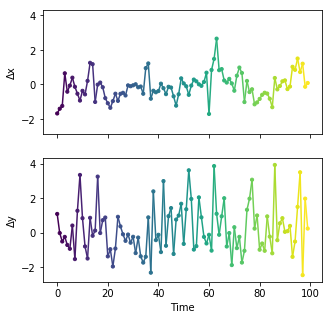

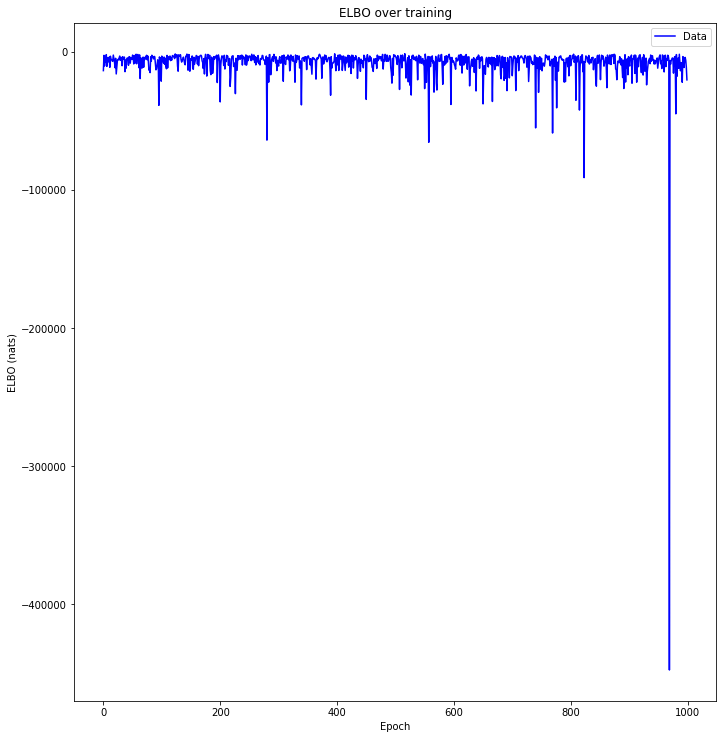

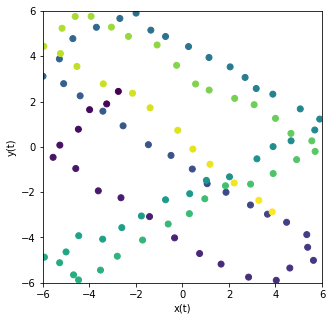

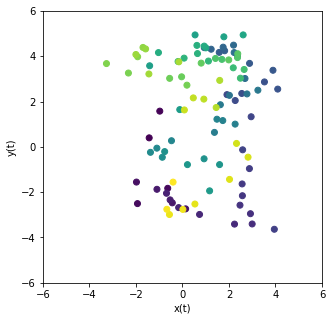

03/01/2019 16:14:58 MSE at time 0: tensor(5.9652)
03/01/2019 16:14:58 MSE at time 1: tensor(5.3176)
03/01/2019 16:14:58 MSE at time 2: tensor(23.3449)
03/01/2019 16:14:58 MSE at time 3: tensor(17.2458)
03/01/2019 16:14:58 MSE at time 4: tensor(13.5187)
03/01/2019 16:14:58 MSE at time 5: tensor(37.6774)
03/01/2019 16:14:58 MSE at time 6: tensor(19.5422)
03/01/2019 16:14:58 MSE at time 7: tensor(6.3641)
03/01/2019 16:14:58 MSE at time 8: tensor(4.4763)
03/01/2019 16:14:58 MSE at time 9: tensor(1.5923)
03/01/2019 16:14:58 MSE at time 10: tensor(1.8159)
03/01/2019 16:14:58 MSE at time 11: tensor(2.9762)
03/01/2019 16:14:58 MSE at time 12: tensor(3.4500)
03/01/2019 16:14:58 MSE at time 13: tensor(5.5316)
03/01/2019 16:14:58 MSE at time 14: tensor(9.8808)
03/01/2019 16:14:58 MSE at time 15: tensor(12.2920)
03/01/2019 16:14:58 MSE at time 16: tensor(17.4789)
03/01/2019 16:14:58 MSE at time 17: tensor(15.7604)
03/01/2019 16:14:58 MSE at time 18: tensor(14.5751)
03/01/2019 16:14:58 MSE at time 

Epoch   243: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 16:16:18 EUBO=0.00000000e+00 at epoch 246
03/01/2019 16:16:18 EUBO=-5.90877282e-32 at epoch 247
03/01/2019 16:16:18 EUBO=0.00000000e+00 at epoch 248
03/01/2019 16:16:18 EUBO=-3.98939783e-22 at epoch 249
03/01/2019 16:16:19 EUBO=-9.72958877e-22 at epoch 250
03/01/2019 16:16:19 EUBO=0.00000000e+00 at epoch 251
03/01/2019 16:16:19 EUBO=-1.25655027e-37 at epoch 252
03/01/2019 16:16:19 EUBO=0.00000000e+00 at epoch 253
03/01/2019 16:16:19 EUBO=-1.90965064e-27 at epoch 254
03/01/2019 16:16:19 EUBO=0.00000000e+00 at epoch 255
03/01/2019 16:16:20 EUBO=0.00000000e+00 at epoch 256
03/01/2019 16:16:20 EUBO=-1.69097068e-24 at epoch 257
03/01/2019 16:16:20 EUBO=0.00000000e+00 at epoch 258
03/01/2019 16:16:20 EUBO=0.00000000e+00 at epoch 259
03/01/2019 16:16:20 EUBO=0.00000000e+00 at epoch 260
03/01/2019 16:16:20 EUBO=0.00000000e+00 at epoch 261
03/01/2019 16:16:21 EUBO=0.00000000e+00 at epoch 262
03/01/2019 16:16:21 EUBO=0.00000000e+00 at epoch 263
03/01/2019 16:16:21 EUBO=-2.02721219e-28

Epoch   344: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 16:16:36 EUBO=0.00000000e+00 at epoch 347
03/01/2019 16:16:36 EUBO=-2.22440059e-34 at epoch 348
03/01/2019 16:16:36 EUBO=-7.88736515e-19 at epoch 349
03/01/2019 16:16:36 EUBO=0.00000000e+00 at epoch 350
03/01/2019 16:16:36 EUBO=-9.26923705e-19 at epoch 351
03/01/2019 16:16:37 EUBO=0.00000000e+00 at epoch 352
03/01/2019 16:16:37 EUBO=0.00000000e+00 at epoch 353
03/01/2019 16:16:37 EUBO=-1.65615262e-40 at epoch 354
03/01/2019 16:16:37 EUBO=0.00000000e+00 at epoch 355
03/01/2019 16:16:37 EUBO=-1.45735040e-43 at epoch 356
03/01/2019 16:16:37 EUBO=-1.71376539e-20 at epoch 357
03/01/2019 16:16:38 EUBO=-3.27633674e-22 at epoch 358
03/01/2019 16:16:38 EUBO=0.00000000e+00 at epoch 359
03/01/2019 16:16:38 EUBO=0.00000000e+00 at epoch 360
03/01/2019 16:16:38 EUBO=-1.56667196e-25 at epoch 361
03/01/2019 16:16:39 EUBO=0.00000000e+00 at epoch 362
03/01/2019 16:16:39 EUBO=0.00000000e+00 at epoch 363
03/01/2019 16:16:39 EUBO=-3.58812143e-34 at epoch 364
03/01/2019 16:16:39 EUBO=0.00000000e+

Epoch   445: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 16:16:53 EUBO=0.00000000e+00 at epoch 448
03/01/2019 16:16:53 EUBO=-1.10665194e-21 at epoch 449
03/01/2019 16:16:53 EUBO=-6.96017478e-18 at epoch 450
03/01/2019 16:16:53 EUBO=0.00000000e+00 at epoch 451
03/01/2019 16:16:53 EUBO=-3.36578791e-15 at epoch 452
03/01/2019 16:16:53 EUBO=0.00000000e+00 at epoch 453
03/01/2019 16:16:53 EUBO=0.00000000e+00 at epoch 454
03/01/2019 16:16:54 EUBO=-2.38859084e-12 at epoch 455
03/01/2019 16:16:54 EUBO=0.00000000e+00 at epoch 456
03/01/2019 16:16:54 EUBO=0.00000000e+00 at epoch 457
03/01/2019 16:16:54 EUBO=-3.85693529e-39 at epoch 458
03/01/2019 16:16:54 EUBO=-2.07924666e-41 at epoch 459
03/01/2019 16:16:54 EUBO=0.00000000e+00 at epoch 460
03/01/2019 16:16:54 EUBO=-2.32426045e-37 at epoch 461
03/01/2019 16:16:55 EUBO=0.00000000e+00 at epoch 462
03/01/2019 16:16:55 EUBO=-1.72743145e-16 at epoch 463
03/01/2019 16:16:55 EUBO=-2.80271120e-32 at epoch 464
03/01/2019 16:16:55 EUBO=0.00000000e+00 at epoch 465
03/01/2019 16:16:55 EUBO=-4.52638845e

Epoch   546: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 16:17:08 EUBO=-4.30634847e-20 at epoch 549
03/01/2019 16:17:08 EUBO=0.00000000e+00 at epoch 550
03/01/2019 16:17:09 EUBO=0.00000000e+00 at epoch 551
03/01/2019 16:17:09 EUBO=-3.82203130e-30 at epoch 552
03/01/2019 16:17:09 EUBO=0.00000000e+00 at epoch 553
03/01/2019 16:17:09 EUBO=-2.25555775e-17 at epoch 554
03/01/2019 16:17:09 EUBO=0.00000000e+00 at epoch 555
03/01/2019 16:17:09 EUBO=-2.18986777e-35 at epoch 556
03/01/2019 16:17:09 EUBO=-3.40822305e-30 at epoch 557
03/01/2019 16:17:10 EUBO=-2.33606255e-12 at epoch 558
03/01/2019 16:17:10 EUBO=0.00000000e+00 at epoch 559
03/01/2019 16:17:10 EUBO=-2.90700757e-37 at epoch 560
03/01/2019 16:17:10 EUBO=-6.95775902e-14 at epoch 561
03/01/2019 16:17:10 EUBO=0.00000000e+00 at epoch 562
03/01/2019 16:17:10 EUBO=-3.93583884e-17 at epoch 563
03/01/2019 16:17:11 EUBO=-3.79492060e-19 at epoch 564
03/01/2019 16:17:11 EUBO=0.00000000e+00 at epoch 565
03/01/2019 16:17:11 EUBO=0.00000000e+00 at epoch 566
03/01/2019 16:17:11 EUBO=-1.01269436

Epoch   647: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 16:17:24 EUBO=0.00000000e+00 at epoch 650
03/01/2019 16:17:24 EUBO=0.00000000e+00 at epoch 651
03/01/2019 16:17:25 EUBO=-3.23443170e-21 at epoch 652
03/01/2019 16:17:25 EUBO=0.00000000e+00 at epoch 653
03/01/2019 16:17:25 EUBO=-1.21857099e-24 at epoch 654
03/01/2019 16:17:25 EUBO=-1.90052253e-30 at epoch 655
03/01/2019 16:17:25 EUBO=-2.13428679e-30 at epoch 656
03/01/2019 16:17:25 EUBO=0.00000000e+00 at epoch 657
03/01/2019 16:17:25 EUBO=0.00000000e+00 at epoch 658
03/01/2019 16:17:26 EUBO=-2.39131008e-35 at epoch 659
03/01/2019 16:17:26 EUBO=0.00000000e+00 at epoch 660
03/01/2019 16:17:26 EUBO=0.00000000e+00 at epoch 661
03/01/2019 16:17:26 EUBO=-3.08986311e-42 at epoch 662
03/01/2019 16:17:26 EUBO=-1.39765502e-14 at epoch 663
03/01/2019 16:17:26 EUBO=-6.96165077e-42 at epoch 664
03/01/2019 16:17:27 EUBO=-2.41545309e-36 at epoch 665
03/01/2019 16:17:27 EUBO=-4.97760288e-16 at epoch 666
03/01/2019 16:17:27 EUBO=-2.79581491e-36 at epoch 667
03/01/2019 16:17:27 EUBO=-2.3391593

Epoch   748: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 16:17:39 EUBO=-2.31403385e-23 at epoch 751
03/01/2019 16:17:40 EUBO=-1.63536155e-39 at epoch 752
03/01/2019 16:17:40 EUBO=0.00000000e+00 at epoch 753
03/01/2019 16:17:40 EUBO=0.00000000e+00 at epoch 754
03/01/2019 16:17:40 EUBO=0.00000000e+00 at epoch 755
03/01/2019 16:17:40 EUBO=-9.35606865e-16 at epoch 756
03/01/2019 16:17:41 EUBO=0.00000000e+00 at epoch 757
03/01/2019 16:17:41 EUBO=-6.42369229e-41 at epoch 758
03/01/2019 16:17:41 EUBO=-9.81995705e-37 at epoch 759
03/01/2019 16:17:41 EUBO=0.00000000e+00 at epoch 760
03/01/2019 16:17:41 EUBO=0.00000000e+00 at epoch 761
03/01/2019 16:17:41 EUBO=-7.07309628e-11 at epoch 762
03/01/2019 16:17:41 EUBO=-1.83762305e-09 at epoch 763
03/01/2019 16:17:42 EUBO=-1.22734117e-31 at epoch 764
03/01/2019 16:17:42 EUBO=-3.19575739e-14 at epoch 765
03/01/2019 16:17:42 EUBO=-1.74328327e-16 at epoch 766
03/01/2019 16:17:42 EUBO=0.00000000e+00 at epoch 767
03/01/2019 16:17:42 EUBO=-1.35691957e-15 at epoch 768
03/01/2019 16:17:42 EUBO=-6.5575589

Epoch   849: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 16:17:56 EUBO=0.00000000e+00 at epoch 852
03/01/2019 16:17:56 EUBO=-1.13570657e-31 at epoch 853
03/01/2019 16:17:56 EUBO=0.00000000e+00 at epoch 854
03/01/2019 16:17:56 EUBO=0.00000000e+00 at epoch 855
03/01/2019 16:17:56 EUBO=-5.97603724e-23 at epoch 856
03/01/2019 16:17:56 EUBO=0.00000000e+00 at epoch 857
03/01/2019 16:17:57 EUBO=-4.20388419e-22 at epoch 858
03/01/2019 16:17:57 EUBO=0.00000000e+00 at epoch 859
03/01/2019 16:17:57 EUBO=0.00000000e+00 at epoch 860
03/01/2019 16:17:57 EUBO=-1.93833932e-24 at epoch 861
03/01/2019 16:17:57 EUBO=0.00000000e+00 at epoch 862
03/01/2019 16:17:57 EUBO=0.00000000e+00 at epoch 863
03/01/2019 16:17:57 EUBO=0.00000000e+00 at epoch 864
03/01/2019 16:17:58 EUBO=-8.21391499e-28 at epoch 865
03/01/2019 16:17:58 EUBO=-9.63191224e-13 at epoch 866
03/01/2019 16:17:58 EUBO=0.00000000e+00 at epoch 867
03/01/2019 16:17:58 EUBO=-1.70414709e-40 at epoch 868
03/01/2019 16:17:58 EUBO=0.00000000e+00 at epoch 869
03/01/2019 16:17:58 EUBO=-2.23653664e-2

Epoch   950: reducing learning rate of group 0 to 3.9063e-04.


03/01/2019 16:18:13 EUBO=-2.90483681e-14 at epoch 953
03/01/2019 16:18:13 EUBO=-3.66692924e-31 at epoch 954
03/01/2019 16:18:13 EUBO=0.00000000e+00 at epoch 955
03/01/2019 16:18:13 EUBO=0.00000000e+00 at epoch 956
03/01/2019 16:18:13 EUBO=-2.60052969e-40 at epoch 957
03/01/2019 16:18:13 EUBO=-7.16083596e-24 at epoch 958
03/01/2019 16:18:13 EUBO=-1.31901856e-38 at epoch 959
03/01/2019 16:18:14 EUBO=-1.42527468e-40 at epoch 960
03/01/2019 16:18:14 EUBO=-6.62471529e-32 at epoch 961
03/01/2019 16:18:14 EUBO=-1.40189355e-28 at epoch 962
03/01/2019 16:18:14 EUBO=0.00000000e+00 at epoch 963
03/01/2019 16:18:14 EUBO=-5.40347071e-27 at epoch 964
03/01/2019 16:18:15 EUBO=-1.48849385e-24 at epoch 965
03/01/2019 16:18:15 EUBO=0.00000000e+00 at epoch 966
03/01/2019 16:18:15 EUBO=-2.65083630e-41 at epoch 967
03/01/2019 16:18:15 EUBO=0.00000000e+00 at epoch 968
03/01/2019 16:18:15 EUBO=-3.16486005e-38 at epoch 969
03/01/2019 16:18:15 EUBO=0.00000000e+00 at epoch 970
03/01/2019 16:18:15 EUBO=0.0000000

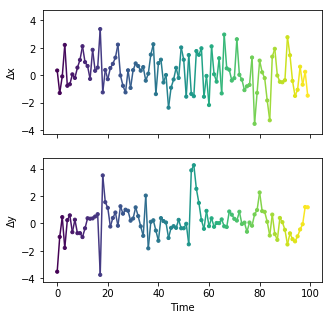

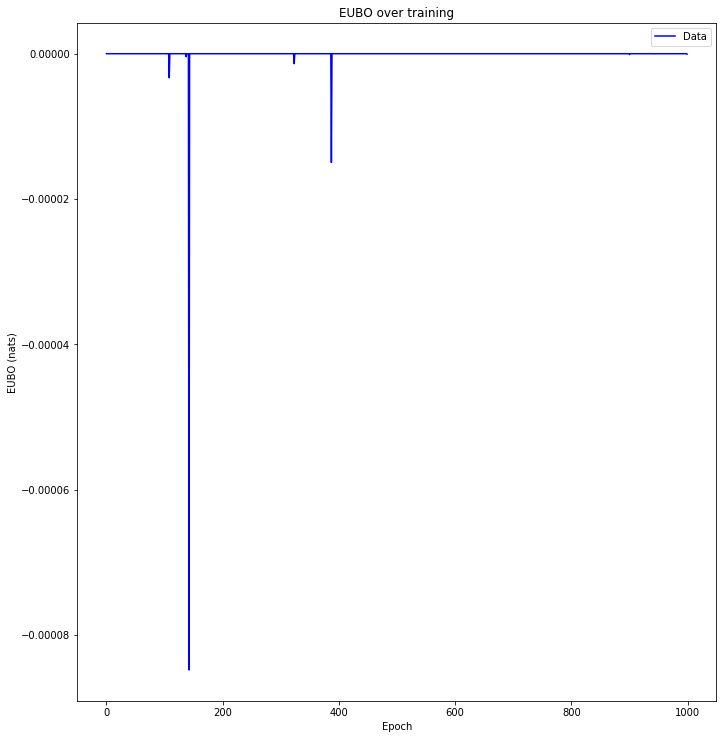

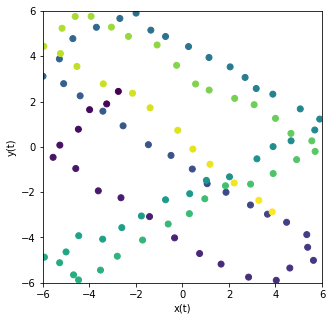

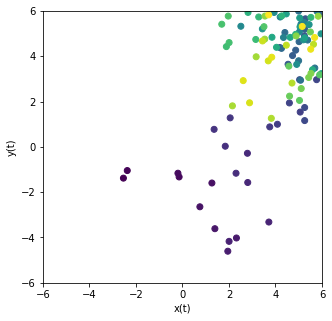

03/01/2019 16:18:22 MSE at time 0: tensor(14.7166)
03/01/2019 16:18:22 MSE at time 1: tensor(9.4429)
03/01/2019 16:18:22 MSE at time 2: tensor(23.6398)
03/01/2019 16:18:22 MSE at time 3: tensor(22.1103)
03/01/2019 16:18:22 MSE at time 4: tensor(45.5719)
03/01/2019 16:18:22 MSE at time 5: tensor(44.6235)
03/01/2019 16:18:22 MSE at time 6: tensor(42.8617)
03/01/2019 16:18:22 MSE at time 7: tensor(39.6349)
03/01/2019 16:18:22 MSE at time 8: tensor(26.6922)
03/01/2019 16:18:22 MSE at time 9: tensor(12.9010)
03/01/2019 16:18:22 MSE at time 10: tensor(16.9268)
03/01/2019 16:18:22 MSE at time 11: tensor(14.1219)
03/01/2019 16:18:22 MSE at time 12: tensor(25.2176)
03/01/2019 16:18:22 MSE at time 13: tensor(21.3328)
03/01/2019 16:18:22 MSE at time 14: tensor(39.8554)
03/01/2019 16:18:22 MSE at time 15: tensor(48.0902)
03/01/2019 16:18:22 MSE at time 16: tensor(52.3966)
03/01/2019 16:18:22 MSE at time 17: tensor(30.9091)
03/01/2019 16:18:22 MSE at time 18: tensor(25.3312)
03/01/2019 16:18:22 MSE

Epoch   132: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 16:18:45 EUBO=-1.05399132e-01 at epoch 135
03/01/2019 16:18:45 EUBO=-1.05360508e-01 at epoch 136
03/01/2019 16:18:46 EUBO=-1.05365515e-01 at epoch 137
03/01/2019 16:18:46 EUBO=-1.05360508e-01 at epoch 138
03/01/2019 16:18:46 EUBO=-1.05360508e-01 at epoch 139
03/01/2019 16:18:46 EUBO=-1.05360508e-01 at epoch 140
03/01/2019 16:18:46 EUBO=-2.23139763e-01 at epoch 141
03/01/2019 16:18:46 EUBO=-1.05362177e-01 at epoch 142
03/01/2019 16:18:47 EUBO=-1.05360508e-01 at epoch 143
03/01/2019 16:18:47 EUBO=-2.23173618e-01 at epoch 144
03/01/2019 16:18:47 EUBO=-1.05362177e-01 at epoch 145
03/01/2019 16:18:47 EUBO=-1.08114243e-01 at epoch 146
03/01/2019 16:18:47 EUBO=-1.05382204e-01 at epoch 147
03/01/2019 16:18:47 EUBO=-1.05666399e-01 at epoch 148
03/01/2019 16:18:48 EUBO=-1.05808735e-01 at epoch 149
03/01/2019 16:18:48 EUBO=-2.16674328e-01 at epoch 150
03/01/2019 16:18:48 EUBO=-1.05392694e-01 at epoch 151
03/01/2019 16:18:48 EUBO=-1.05831623e-01 at epoch 152
03/01/2019 16:18:48 EUBO=-1.

Epoch   233: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 16:19:03 EUBO=-1.25521898e-01 at epoch 236
03/01/2019 16:19:03 EUBO=-1.10413551e-01 at epoch 237
03/01/2019 16:19:03 EUBO=-1.05360508e-01 at epoch 238
03/01/2019 16:19:04 EUBO=-2.24094868e-01 at epoch 239
03/01/2019 16:19:04 EUBO=-1.05542421e-01 at epoch 240
03/01/2019 16:19:04 EUBO=-1.22218132e-01 at epoch 241
03/01/2019 16:19:04 EUBO=-1.05360508e-01 at epoch 242
03/01/2019 16:19:04 EUBO=-1.05360508e-01 at epoch 243
03/01/2019 16:19:04 EUBO=-1.05360508e-01 at epoch 244
03/01/2019 16:19:05 EUBO=-1.05360746e-01 at epoch 245
03/01/2019 16:19:05 EUBO=-1.07958794e-01 at epoch 246
03/01/2019 16:19:05 EUBO=-1.05370522e-01 at epoch 247
03/01/2019 16:19:05 EUBO=-1.05360508e-01 at epoch 248
03/01/2019 16:19:05 EUBO=-2.05699444e-01 at epoch 249
03/01/2019 16:19:06 EUBO=-1.05360508e-01 at epoch 250
03/01/2019 16:19:06 EUBO=-1.65296078e-01 at epoch 251
03/01/2019 16:19:06 EUBO=-1.05360746e-01 at epoch 252
03/01/2019 16:19:06 EUBO=-1.05363846e-01 at epoch 253
03/01/2019 16:19:06 EUBO=-3.

Epoch   334: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 16:19:20 EUBO=-1.05520964e-01 at epoch 337
03/01/2019 16:19:20 EUBO=-1.05360508e-01 at epoch 338
03/01/2019 16:19:20 EUBO=-2.23143578e-01 at epoch 339
03/01/2019 16:19:20 EUBO=-1.05360985e-01 at epoch 340
03/01/2019 16:19:21 EUBO=-1.12036228e-01 at epoch 341
03/01/2019 16:19:21 EUBO=-1.05394363e-01 at epoch 342
03/01/2019 16:19:21 EUBO=-3.56631517e-01 at epoch 343
03/01/2019 16:19:21 EUBO=-1.05360508e-01 at epoch 344
03/01/2019 16:19:21 EUBO=-1.05366230e-01 at epoch 345
03/01/2019 16:19:21 EUBO=-1.05652809e-01 at epoch 346
03/01/2019 16:19:21 EUBO=-3.21942210e-01 at epoch 347
03/01/2019 16:19:22 EUBO=-1.05370760e-01 at epoch 348
03/01/2019 16:19:22 EUBO=-1.12792492e-01 at epoch 349
03/01/2019 16:19:22 EUBO=-1.05360746e-01 at epoch 350
03/01/2019 16:19:22 EUBO=-1.05456114e-01 at epoch 351
03/01/2019 16:19:22 EUBO=-1.05360508e-01 at epoch 352
03/01/2019 16:19:22 EUBO=-1.20213270e-01 at epoch 353
03/01/2019 16:19:23 EUBO=-1.08611584e-01 at epoch 354
03/01/2019 16:19:23 EUBO=-1.

Epoch   435: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 16:19:35 EUBO=-3.33866119e-01 at epoch 438
03/01/2019 16:19:35 EUBO=-2.64284372e-01 at epoch 439
03/01/2019 16:19:36 EUBO=-1.05365038e-01 at epoch 440
03/01/2019 16:19:36 EUBO=-1.05360508e-01 at epoch 441
03/01/2019 16:19:36 EUBO=-1.11465931e-01 at epoch 442
03/01/2019 16:19:36 EUBO=-2.22672939e-01 at epoch 443
03/01/2019 16:19:36 EUBO=-1.33082867e-01 at epoch 444
03/01/2019 16:19:36 EUBO=-2.61995554e-01 at epoch 445
03/01/2019 16:19:36 EUBO=-1.05360508e-01 at epoch 446
03/01/2019 16:19:37 EUBO=-1.05360508e-01 at epoch 447
03/01/2019 16:19:37 EUBO=-2.17280149e-01 at epoch 448
03/01/2019 16:19:37 EUBO=-1.05360508e-01 at epoch 449
03/01/2019 16:19:37 EUBO=-2.23140955e-01 at epoch 450
03/01/2019 16:19:37 EUBO=-3.24823260e-01 at epoch 451
03/01/2019 16:19:37 EUBO=-1.34411097e-01 at epoch 452
03/01/2019 16:19:38 EUBO=-1.06194019e-01 at epoch 453
03/01/2019 16:19:38 EUBO=-2.22902536e-01 at epoch 454
03/01/2019 16:19:38 EUBO=-2.23143578e-01 at epoch 455
03/01/2019 16:19:38 EUBO=-1.

Epoch   536: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 16:19:51 EUBO=-2.22337246e-01 at epoch 539
03/01/2019 16:19:51 EUBO=-2.23143578e-01 at epoch 540
03/01/2019 16:19:51 EUBO=-1.06311321e-01 at epoch 541
03/01/2019 16:19:51 EUBO=-1.05367184e-01 at epoch 542
03/01/2019 16:19:52 EUBO=-1.05360508e-01 at epoch 543
03/01/2019 16:19:52 EUBO=-3.26727629e-01 at epoch 544
03/01/2019 16:19:52 EUBO=-1.77148342e-01 at epoch 545
03/01/2019 16:19:52 EUBO=-2.06864357e-01 at epoch 546
03/01/2019 16:19:52 EUBO=-1.05794191e-01 at epoch 547
03/01/2019 16:19:52 EUBO=-1.05360508e-01 at epoch 548
03/01/2019 16:19:52 EUBO=-1.05360508e-01 at epoch 549
03/01/2019 16:19:53 EUBO=-1.05360508e-01 at epoch 550
03/01/2019 16:19:53 EUBO=-1.05360508e-01 at epoch 551
03/01/2019 16:19:53 EUBO=-2.22513676e-01 at epoch 552
03/01/2019 16:19:53 EUBO=-1.08150959e-01 at epoch 553
03/01/2019 16:19:53 EUBO=-1.05744839e-01 at epoch 554
03/01/2019 16:19:53 EUBO=-2.23433018e-01 at epoch 555
03/01/2019 16:19:53 EUBO=-1.05360746e-01 at epoch 556
03/01/2019 16:19:54 EUBO=-1.

Epoch   637: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 16:20:07 EUBO=-1.05464458e-01 at epoch 640
03/01/2019 16:20:07 EUBO=-1.05360508e-01 at epoch 641
03/01/2019 16:20:07 EUBO=-1.07474089e-01 at epoch 642
03/01/2019 16:20:07 EUBO=-1.05739117e-01 at epoch 643
03/01/2019 16:20:08 EUBO=-1.13794088e-01 at epoch 644
03/01/2019 16:20:08 EUBO=-2.23143578e-01 at epoch 645
03/01/2019 16:20:08 EUBO=-1.05360508e-01 at epoch 646
03/01/2019 16:20:08 EUBO=-1.05360508e-01 at epoch 647
03/01/2019 16:20:08 EUBO=-1.05360508e-01 at epoch 648
03/01/2019 16:20:08 EUBO=-1.53810501e-01 at epoch 649
03/01/2019 16:20:08 EUBO=-1.35250092e-01 at epoch 650
03/01/2019 16:20:09 EUBO=-1.05374575e-01 at epoch 651
03/01/2019 16:20:09 EUBO=-1.05360508e-01 at epoch 652
03/01/2019 16:20:09 EUBO=-1.07519627e-01 at epoch 653
03/01/2019 16:20:09 EUBO=-1.64597273e-01 at epoch 654
03/01/2019 16:20:09 EUBO=-1.05360508e-01 at epoch 655
03/01/2019 16:20:09 EUBO=-2.54831791e-01 at epoch 656
03/01/2019 16:20:10 EUBO=-3.42673779e-01 at epoch 657
03/01/2019 16:20:10 EUBO=-1.

Epoch   738: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 16:20:22 EUBO=-1.05360508e-01 at epoch 741
03/01/2019 16:20:22 EUBO=-2.01974154e-01 at epoch 742
03/01/2019 16:20:22 EUBO=-1.05360985e-01 at epoch 743
03/01/2019 16:20:22 EUBO=-1.44261360e-01 at epoch 744
03/01/2019 16:20:23 EUBO=-1.06387138e-01 at epoch 745
03/01/2019 16:20:23 EUBO=-1.05361938e-01 at epoch 746
03/01/2019 16:20:23 EUBO=-2.20220804e-01 at epoch 747
03/01/2019 16:20:23 EUBO=-1.05768919e-01 at epoch 748
03/01/2019 16:20:23 EUBO=-1.05361700e-01 at epoch 749
03/01/2019 16:20:23 EUBO=-2.23172903e-01 at epoch 750
03/01/2019 16:20:24 EUBO=-1.05375290e-01 at epoch 751
03/01/2019 16:20:24 EUBO=-2.10771561e-01 at epoch 752
03/01/2019 16:20:24 EUBO=-1.15953922e-01 at epoch 753
03/01/2019 16:20:24 EUBO=-1.05360508e-01 at epoch 754
03/01/2019 16:20:24 EUBO=-1.05480194e-01 at epoch 755
03/01/2019 16:20:24 EUBO=-2.22865343e-01 at epoch 756
03/01/2019 16:20:25 EUBO=-1.72424316e-01 at epoch 757
03/01/2019 16:20:25 EUBO=-1.05360508e-01 at epoch 758
03/01/2019 16:20:25 EUBO=-1.

Epoch   839: reducing learning rate of group 0 to 3.9063e-04.


03/01/2019 16:20:38 EUBO=-1.05855465e-01 at epoch 842
03/01/2019 16:20:39 EUBO=-1.08831644e-01 at epoch 843
03/01/2019 16:20:39 EUBO=-1.05360508e-01 at epoch 844
03/01/2019 16:20:39 EUBO=-1.05360508e-01 at epoch 845
03/01/2019 16:20:39 EUBO=-1.06090546e-01 at epoch 846
03/01/2019 16:20:39 EUBO=-1.05360508e-01 at epoch 847
03/01/2019 16:20:39 EUBO=-2.22901106e-01 at epoch 848
03/01/2019 16:20:39 EUBO=-1.05360746e-01 at epoch 849
03/01/2019 16:20:40 EUBO=-1.21315956e-01 at epoch 850
03/01/2019 16:20:40 EUBO=-1.05360508e-01 at epoch 851
03/01/2019 16:20:40 EUBO=-1.05360508e-01 at epoch 852
03/01/2019 16:20:40 EUBO=-1.17470980e-01 at epoch 853
03/01/2019 16:20:40 EUBO=-2.23634481e-01 at epoch 854
03/01/2019 16:20:40 EUBO=-1.54262781e-01 at epoch 855
03/01/2019 16:20:41 EUBO=-1.05360508e-01 at epoch 856
03/01/2019 16:20:41 EUBO=-2.18904972e-01 at epoch 857
03/01/2019 16:20:41 EUBO=-1.25636578e-01 at epoch 858
03/01/2019 16:20:41 EUBO=-2.22056866e-01 at epoch 859
03/01/2019 16:20:41 EUBO=-1.

Epoch   940: reducing learning rate of group 0 to 1.9531e-04.


03/01/2019 16:20:55 EUBO=-1.05360746e-01 at epoch 943
03/01/2019 16:20:55 EUBO=-2.16878653e-01 at epoch 944
03/01/2019 16:20:55 EUBO=-1.05360508e-01 at epoch 945
03/01/2019 16:20:56 EUBO=-1.05360508e-01 at epoch 946
03/01/2019 16:20:56 EUBO=-1.05901241e-01 at epoch 947
03/01/2019 16:20:56 EUBO=-2.25980520e-01 at epoch 948
03/01/2019 16:20:56 EUBO=-1.17604017e-01 at epoch 949
03/01/2019 16:20:56 EUBO=-1.35794640e-01 at epoch 950
03/01/2019 16:20:56 EUBO=-1.55106306e-01 at epoch 951
03/01/2019 16:20:57 EUBO=-1.06287003e-01 at epoch 952
03/01/2019 16:20:57 EUBO=-2.23120689e-01 at epoch 953
03/01/2019 16:20:57 EUBO=-1.98380232e-01 at epoch 954
03/01/2019 16:20:57 EUBO=-1.09032393e-01 at epoch 955
03/01/2019 16:20:57 EUBO=-1.05373859e-01 at epoch 956
03/01/2019 16:20:58 EUBO=-1.34650707e-01 at epoch 957
03/01/2019 16:20:58 EUBO=-2.23143578e-01 at epoch 958
03/01/2019 16:20:58 EUBO=-1.05360985e-01 at epoch 959
03/01/2019 16:20:58 EUBO=-1.05365038e-01 at epoch 960
03/01/2019 16:20:58 EUBO=-1.

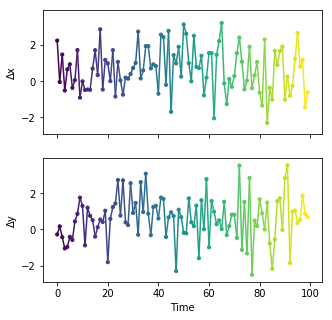

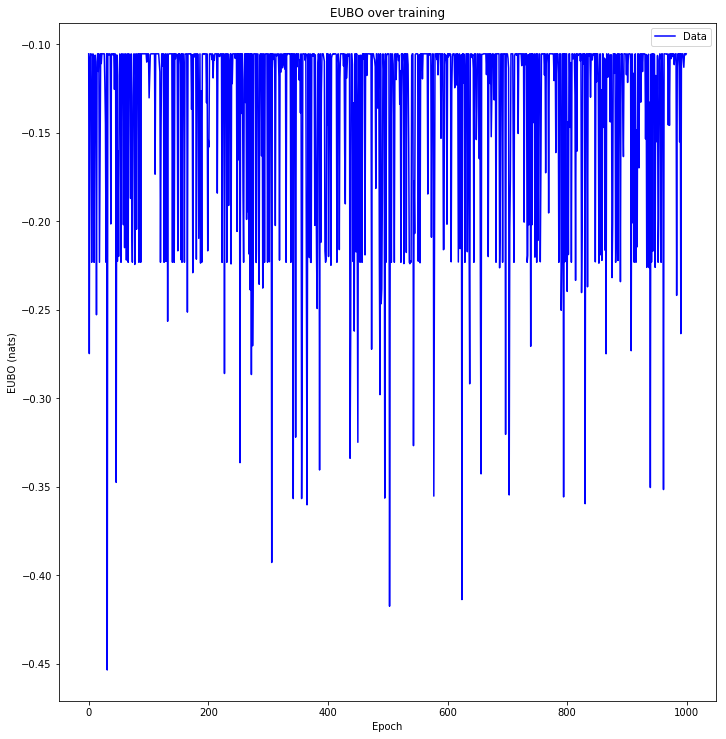

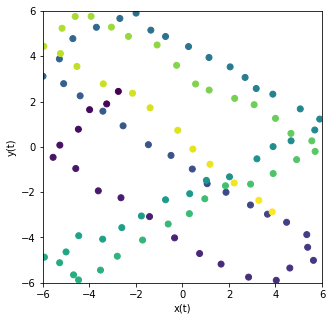

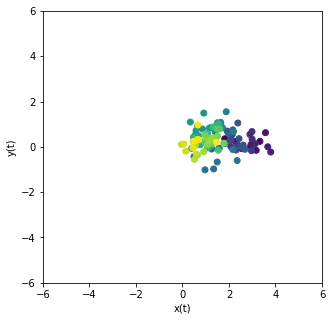

03/01/2019 16:21:05 MSE at time 0: tensor(25.3256)
03/01/2019 16:21:05 MSE at time 1: tensor(33.4282)
03/01/2019 16:21:05 MSE at time 2: tensor(45.4979)
03/01/2019 16:21:05 MSE at time 3: tensor(61.2611)
03/01/2019 16:21:05 MSE at time 4: tensor(71.3678)
03/01/2019 16:21:05 MSE at time 5: tensor(72.4437)
03/01/2019 16:21:05 MSE at time 6: tensor(69.0746)
03/01/2019 16:21:05 MSE at time 7: tensor(47.3503)
03/01/2019 16:21:05 MSE at time 8: tensor(44.9246)
03/01/2019 16:21:05 MSE at time 9: tensor(35.2935)
03/01/2019 16:21:05 MSE at time 10: tensor(29.3175)
03/01/2019 16:21:05 MSE at time 11: tensor(30.5910)
03/01/2019 16:21:05 MSE at time 12: tensor(34.3347)
03/01/2019 16:21:05 MSE at time 13: tensor(41.3006)
03/01/2019 16:21:05 MSE at time 14: tensor(38.6328)
03/01/2019 16:21:05 MSE at time 15: tensor(31.8508)
03/01/2019 16:21:05 MSE at time 16: tensor(36.1763)
03/01/2019 16:21:05 MSE at time 17: tensor(24.0056)
03/01/2019 16:21:05 MSE at time 18: tensor(24.6474)
03/01/2019 16:21:05 MS

Epoch   125: reducing learning rate of group 0 to 5.0000e-02.


03/01/2019 16:21:27 EUBO=-1.38325691e-02 at epoch 128
03/01/2019 16:21:27 EUBO=-1.00493431e-02 at epoch 129
03/01/2019 16:21:28 EUBO=-3.14702988e-02 at epoch 130
03/01/2019 16:21:28 EUBO=-3.65548134e-02 at epoch 131
03/01/2019 16:21:28 EUBO=-1.00541115e-02 at epoch 132
03/01/2019 16:21:28 EUBO=-2.58464813e-02 at epoch 133
03/01/2019 16:21:28 EUBO=-4.62207794e-02 at epoch 134
03/01/2019 16:21:28 EUBO=-2.18396187e-02 at epoch 135
03/01/2019 16:21:29 EUBO=-1.00550652e-02 at epoch 136
03/01/2019 16:21:29 EUBO=-1.00536346e-02 at epoch 137
03/01/2019 16:21:29 EUBO=-1.00998878e-02 at epoch 138
03/01/2019 16:21:29 EUBO=-1.66082382e-02 at epoch 139
03/01/2019 16:21:29 EUBO=-3.04560661e-02 at epoch 140
03/01/2019 16:21:30 EUBO=-1.54657364e-02 at epoch 141
03/01/2019 16:21:30 EUBO=-1.82538033e-02 at epoch 142
03/01/2019 16:21:30 EUBO=-2.75559425e-02 at epoch 143
03/01/2019 16:21:30 EUBO=-1.91912651e-02 at epoch 144
03/01/2019 16:21:30 EUBO=-1.70745850e-02 at epoch 145
03/01/2019 16:21:30 EUBO=-3.

Epoch   226: reducing learning rate of group 0 to 2.5000e-02.


03/01/2019 16:21:45 EUBO=-1.43775940e-02 at epoch 229
03/01/2019 16:21:45 EUBO=-1.90691948e-02 at epoch 230
03/01/2019 16:21:45 EUBO=-2.92062759e-02 at epoch 231
03/01/2019 16:21:45 EUBO=-1.00774765e-02 at epoch 232
03/01/2019 16:21:45 EUBO=-1.03077888e-02 at epoch 233
03/01/2019 16:21:45 EUBO=-2.06851959e-02 at epoch 234
03/01/2019 16:21:46 EUBO=-3.38139534e-02 at epoch 235
03/01/2019 16:21:46 EUBO=-4.18310165e-02 at epoch 236
03/01/2019 16:21:46 EUBO=-1.00507736e-02 at epoch 237
03/01/2019 16:21:46 EUBO=-1.61952972e-02 at epoch 238
03/01/2019 16:21:47 EUBO=-2.64558792e-02 at epoch 239
03/01/2019 16:21:47 EUBO=-1.01375580e-02 at epoch 240
03/01/2019 16:21:47 EUBO=-1.59096718e-02 at epoch 241
03/01/2019 16:21:47 EUBO=-2.41165161e-02 at epoch 242
03/01/2019 16:21:48 EUBO=-1.00641251e-02 at epoch 243
03/01/2019 16:21:48 EUBO=-2.58555412e-02 at epoch 244
03/01/2019 16:21:48 EUBO=-1.11036301e-02 at epoch 245
03/01/2019 16:21:48 EUBO=-2.32467651e-02 at epoch 246
03/01/2019 16:21:49 EUBO=-2.

Epoch   422: reducing learning rate of group 0 to 1.2500e-02.


03/01/2019 16:22:18 EUBO=-1.30610466e-02 at epoch 425
03/01/2019 16:22:18 EUBO=-2.80842781e-02 at epoch 426
03/01/2019 16:22:18 EUBO=-1.04446411e-02 at epoch 427
03/01/2019 16:22:18 EUBO=-1.62925720e-02 at epoch 428
03/01/2019 16:22:19 EUBO=-1.04193687e-02 at epoch 429
03/01/2019 16:22:19 EUBO=-1.01046562e-02 at epoch 430
03/01/2019 16:22:19 EUBO=-5.38439751e-02 at epoch 431
03/01/2019 16:22:19 EUBO=-1.00502968e-02 at epoch 432
03/01/2019 16:22:19 EUBO=-1.00564957e-02 at epoch 433
03/01/2019 16:22:19 EUBO=-1.08909607e-02 at epoch 434
03/01/2019 16:22:20 EUBO=-1.00660324e-02 at epoch 435
03/01/2019 16:22:20 EUBO=-1.43108368e-02 at epoch 436
03/01/2019 16:22:20 EUBO=-2.49371529e-02 at epoch 437
03/01/2019 16:22:20 EUBO=-1.88736916e-02 at epoch 438
03/01/2019 16:22:20 EUBO=-1.82614326e-02 at epoch 439
03/01/2019 16:22:21 EUBO=-1.33409500e-02 at epoch 440
03/01/2019 16:22:21 EUBO=-1.45158768e-02 at epoch 441
03/01/2019 16:22:21 EUBO=-5.04565239e-02 at epoch 442
03/01/2019 16:22:21 EUBO=-1.

Epoch   523: reducing learning rate of group 0 to 6.2500e-03.


03/01/2019 16:22:35 EUBO=-3.58443260e-02 at epoch 526
03/01/2019 16:22:35 EUBO=-1.05710030e-02 at epoch 527
03/01/2019 16:22:35 EUBO=-3.04350853e-02 at epoch 528
03/01/2019 16:22:35 EUBO=-1.03840828e-02 at epoch 529
03/01/2019 16:22:36 EUBO=-1.00917816e-02 at epoch 530
03/01/2019 16:22:36 EUBO=-2.62475014e-02 at epoch 531
03/01/2019 16:22:36 EUBO=-2.00610161e-02 at epoch 532
03/01/2019 16:22:36 EUBO=-3.13882828e-02 at epoch 533
03/01/2019 16:22:36 EUBO=-1.18904114e-02 at epoch 534
03/01/2019 16:22:37 EUBO=-1.00765228e-02 at epoch 535
03/01/2019 16:22:37 EUBO=-2.00114250e-02 at epoch 536
03/01/2019 16:22:37 EUBO=-1.88322067e-02 at epoch 537
03/01/2019 16:22:37 EUBO=-2.07200050e-02 at epoch 538
03/01/2019 16:22:37 EUBO=-2.33626366e-02 at epoch 539
03/01/2019 16:22:37 EUBO=-2.67982483e-02 at epoch 540
03/01/2019 16:22:38 EUBO=-8.21590424e-03 at epoch 541
03/01/2019 16:22:38 EUBO=-2.41413116e-02 at epoch 542
03/01/2019 16:22:38 EUBO=-2.39615440e-02 at epoch 543
03/01/2019 16:22:38 EUBO=-2.

Epoch   624: reducing learning rate of group 0 to 3.1250e-03.


03/01/2019 16:22:53 EUBO=-1.89352036e-02 at epoch 627
03/01/2019 16:22:53 EUBO=-1.00502968e-02 at epoch 628
03/01/2019 16:22:53 EUBO=-2.16827393e-02 at epoch 629
03/01/2019 16:22:53 EUBO=-2.63090134e-02 at epoch 630
03/01/2019 16:22:53 EUBO=-1.04489326e-02 at epoch 631
03/01/2019 16:22:54 EUBO=-1.94830894e-02 at epoch 632
03/01/2019 16:22:54 EUBO=-1.03011131e-02 at epoch 633
03/01/2019 16:22:54 EUBO=-1.86676979e-02 at epoch 634
03/01/2019 16:22:54 EUBO=-2.11687088e-02 at epoch 635
03/01/2019 16:22:54 EUBO=-1.11374855e-02 at epoch 636
03/01/2019 16:22:55 EUBO=-2.04057693e-02 at epoch 637
03/01/2019 16:22:55 EUBO=-2.09617615e-02 at epoch 638
03/01/2019 16:22:55 EUBO=-1.55000687e-02 at epoch 639
03/01/2019 16:22:55 EUBO=-1.02467537e-02 at epoch 640
03/01/2019 16:22:55 EUBO=-1.01928711e-02 at epoch 641
03/01/2019 16:22:55 EUBO=-1.02505684e-02 at epoch 642
03/01/2019 16:22:56 EUBO=-1.50370598e-02 at epoch 643
03/01/2019 16:22:56 EUBO=-1.84550285e-02 at epoch 644
03/01/2019 16:22:56 EUBO=-1.

Epoch   891: reducing learning rate of group 0 to 1.5625e-03.


03/01/2019 16:23:36 EUBO=-1.04684830e-02 at epoch 894
03/01/2019 16:23:37 EUBO=-2.68082619e-02 at epoch 895
03/01/2019 16:23:37 EUBO=-4.12197113e-02 at epoch 896
03/01/2019 16:23:37 EUBO=-1.32350922e-02 at epoch 897
03/01/2019 16:23:37 EUBO=-1.09210014e-02 at epoch 898
03/01/2019 16:23:37 EUBO=-1.00598335e-02 at epoch 899
03/01/2019 16:23:37 EUBO=-1.02553368e-02 at epoch 900
03/01/2019 16:23:38 EUBO=-2.13842392e-02 at epoch 901
03/01/2019 16:23:38 EUBO=-1.38273239e-02 at epoch 902
03/01/2019 16:23:38 EUBO=-2.46911049e-02 at epoch 903
03/01/2019 16:23:38 EUBO=-2.01377869e-02 at epoch 904
03/01/2019 16:23:38 EUBO=-1.51391029e-02 at epoch 905
03/01/2019 16:23:38 EUBO=-4.19816971e-02 at epoch 906
03/01/2019 16:23:39 EUBO=-3.68642807e-02 at epoch 907
03/01/2019 16:23:39 EUBO=-3.18741798e-02 at epoch 908
03/01/2019 16:23:39 EUBO=-1.02257729e-02 at epoch 909
03/01/2019 16:23:39 EUBO=-3.94387245e-02 at epoch 910
03/01/2019 16:23:39 EUBO=-2.01663971e-02 at epoch 911
03/01/2019 16:23:39 EUBO=-1.

Epoch   992: reducing learning rate of group 0 to 7.8125e-04.


03/01/2019 16:23:53 EUBO=-2.51841545e-02 at epoch 995
03/01/2019 16:23:53 EUBO=-3.09824944e-02 at epoch 996
03/01/2019 16:23:53 EUBO=-1.00507736e-02 at epoch 997
03/01/2019 16:23:53 EUBO=-1.11904144e-02 at epoch 998
03/01/2019 16:23:54 EUBO=-2.48465538e-02 at epoch 999
03/01/2019 16:23:54 EUBO=-1.81879997e-02 at epoch 1000


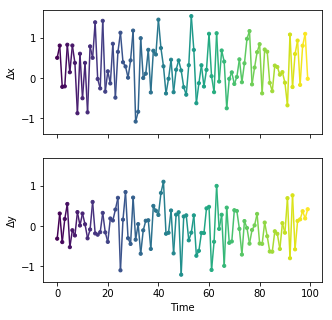

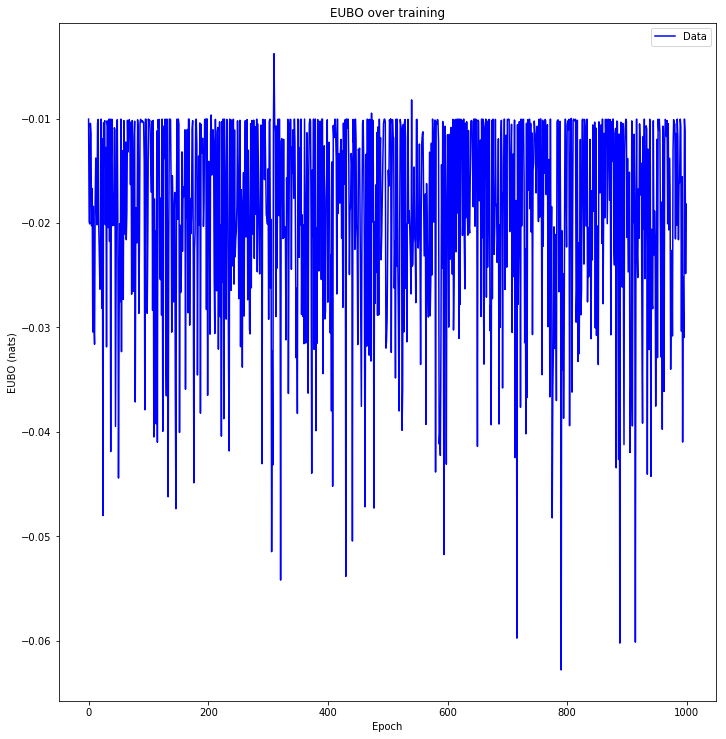

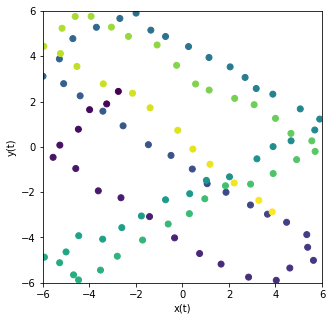

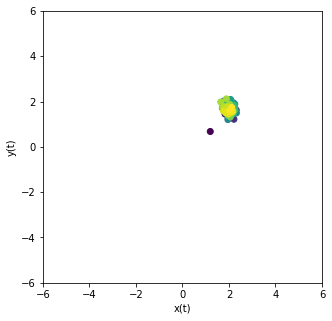

03/01/2019 16:23:54 MSE at time 0: tensor(18.7644)
03/01/2019 16:23:54 MSE at time 1: tensor(26.1049)
03/01/2019 16:23:54 MSE at time 2: tensor(33.2924)
03/01/2019 16:23:54 MSE at time 3: tensor(42.5442)
03/01/2019 16:23:54 MSE at time 4: tensor(58.0914)
03/01/2019 16:23:54 MSE at time 5: tensor(66.3348)
03/01/2019 16:23:54 MSE at time 6: tensor(52.1285)
03/01/2019 16:23:54 MSE at time 7: tensor(45.6969)
03/01/2019 16:23:54 MSE at time 8: tensor(37.4862)
03/01/2019 16:23:54 MSE at time 9: tensor(33.5812)
03/01/2019 16:23:54 MSE at time 10: tensor(37.3923)
03/01/2019 16:23:54 MSE at time 11: tensor(42.7066)
03/01/2019 16:23:54 MSE at time 12: tensor(44.3538)
03/01/2019 16:23:54 MSE at time 13: tensor(51.3790)
03/01/2019 16:23:54 MSE at time 14: tensor(53.8772)
03/01/2019 16:23:54 MSE at time 15: tensor(54.5896)
03/01/2019 16:23:54 MSE at time 16: tensor(58.2234)
03/01/2019 16:23:54 MSE at time 17: tensor(50.7158)
03/01/2019 16:23:54 MSE at time 18: tensor(44.1393)
03/01/2019 16:23:54 MS

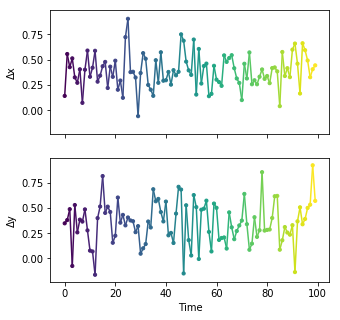

In [24]:
for i, inference_strategy in enumerate(sampling_strategies):
    logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
    for inclusive_kl in kl_directions:
        logging.info('Experimenting with %s training', 'Wake-Sleep' if inclusive_kl else 'Variational')
        for num_particles in sample_sizes:
            logging.info('Experimenting with sample size of %d', num_particles)
            sampler, tau, evidence_bounds = train_model((num_particles,), inference_strategy, inclusive_kl, plot_bounds=True)
            evaluate_inference(sampler, tau)